# Setup

First, import modules and codes from modules to run this notebook:

In [1]:
from IPython.display import display

from brightway2 import *
import bw2analyzer as bwa
import brightway2 as bw
from bw2data.parameters import *
from lci_to_bw2 import *
from bw2data.project import ProjectManager
from bw2data.parameters import (ActivityParameter, DatabaseParameter,
                                ProjectParameter, Group)

import pandas as pd
import numpy as np

import math

import pathlib

import sqlite3

import os

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

Defining a few global parameters:

In [2]:
# Defining the directory with datasets:
ROOT_DIR = "files"

In [3]:
# Defining the size of figures:
mpl.rcParams['figure.figsize'] = (16, 10)
pd.options.display.max_rows = 200

In [4]:
# Defining the path where to save figures:
path_img = os.path.abspath(os.path.join('outputs', 'IMG'))
if not os.path.exists(path_img):
    os.makedirs(path_img)
print(f'Images will be saved in {path_img}')

Images will be saved in C:\Users\souvi\Documents\These\80_Calculations\05_LCA\outputs\IMG


In [5]:
# Defining seaborn main parameters:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("paper", font_scale=1.25,
                rc={"axes.titlesize": 12, "lines.linewidth": 1,
                    "legend.fontsize": 8, "legend.title_fontsize": 10})

In [6]:
# A function used to define the thickness of x and y axis:
def style_ax(ax):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width=0.5)
        ax.set_xlabel(None)
    return ax

In [7]:
# Listing the available Brightway2 projects:
bw.projects

Brightway2 projects manager with 5 objects:
	LCA_Glazing
	LCA_Glazing_0
	LCOPT_Setup
	default
	test
Use `projects.report()` to get a report on all projects.

In [8]:
# Creating a new project or accessing an existing one:
bw.projects.set_current("LCA_Glazing")

# Locating the current project:
bw.projects.dir

'C:\\Users\\souvi\\AppData\\Local\\pylca\\Brightway3\\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab'

# List of Scenarios with their Parameters

All scenarios and their parameters for the LCA are defined in the Excel file called lca_scenarios. Here it is imported.

In [9]:
lca_scenarios = pd.ExcelFile(os.path.join(ROOT_DIR, "lca_scenarios.xlsx"))

# Printng the list of sheets in the Excel file:
print("lca_scenarios, sheet names = \n {}\n".format(lca_scenarios.sheet_names))

lca_scenarios, sheet names = 
 ['Scenarios', 'Step1', 'Step2', 'Step3', 'Step4', 'Step5', 'Step6', 'Step7', 'Step8', 'Step9', 'Step10', 'Step11', 'Step12', 'Step13', 'Step14', 'Step15', 'Step16']



Creating a set of DataFrames. One for each calculation step, which corresponds to a batch of simulations defined by a specific building configuration with different types of IGUs:

In [10]:
# Creating one DataFrame per step:
df_step1 = lca_scenarios.parse('Step1').set_index('name')
df_step2 = lca_scenarios.parse('Step2').set_index('name')
df_step3 = lca_scenarios.parse('Step3').set_index('name')
df_step4 = lca_scenarios.parse('Step4').set_index('name')
df_step5 = lca_scenarios.parse('Step5').set_index('name')
df_step6 = lca_scenarios.parse('Step6').set_index('name')
df_step7 = lca_scenarios.parse('Step7').set_index('name')
df_step8 = lca_scenarios.parse('Step8').set_index('name')
df_step9 = lca_scenarios.parse('Step9').set_index('name')
df_step10 = lca_scenarios.parse('Step10').set_index('name')
df_step11 = lca_scenarios.parse('Step11').set_index('name')
df_step12 = lca_scenarios.parse('Step12').set_index('name')
df_step13 = lca_scenarios.parse('Step13').set_index('name')
df_step14 = lca_scenarios.parse('Step14').set_index('name')
df_step15 = lca_scenarios.parse('Step15').set_index('name')
df_step16 = lca_scenarios.parse('Step16').set_index('name')

# Import of LCA Databases

Importing databases that include LCIA methods, global life cycle inventories (Ecoinvent and Biosphere 3) and those that are specific to this study (saved as Excel files in the subfolder "files").

In [11]:
# Print the databases already available in the current project:
bw.databases

Databases dictionary with 8 object(s):
	biosphere3
	ecoinvent 3.7 cut-off
	exldb_alu
	exldb_cw
	exldb_cw_eol
	exldb_igu
	exldb_sand
	exldb_spacers

## Ecoinvent and Biosphere 3

**Importing Biosphere 3:**

Biosphere 3 is the default biosphere database with all the resource and emission flows from the ecoinvent database, version 2.

In [12]:
# Importing elementary flows, LCIA methods and some other data
bw.bw2setup()

Biosphere database already present!!! No setup is needed


**Importing Ecoinvent 3.7, cut-off system model:**

For more information about the system models in ecoinvent, and especially the cut-off one, read [this](https://ecoinvent.org/the-ecoinvent-database/system-models/).

In [13]:
# Importing the ecoinvent 3.7 cut-off database, saved locally:
ei37cutdir = (r"C:\Users\souvi\Documents\These\80_Calculations\06_LCA_SystemDiagrams\02_Dataset\ecoinvent 3.7_cutoff_ecoSpold02\datasets")

if 'ecoinvent 3.7 cut-off' in databases:
    print("Database has already been imported!")
else:
    ei37cut = bw.SingleOutputEcospold2Importer(
        ei37cutdir, 'ecoinvent 3.7 cut-off')
    ei37cut.apply_strategies()
    ei37cut.statistics()
    ei37cut.write_database()

Database has already been imported!


## Excel Datasets

Import of the life cycle inventory specific to this case study and saved in the Excel files.

<font color='red'>But first, a boolean variable to specify if importing (or updating) the inventory is necessary:<font>

In [14]:
import_exldb = True

**Importing the Excel dataset relating to aluminium production, regionalised for the case study:**

In [15]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_alu.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()

    # Checking whether the import went as expected.
    # Creating an Excel sheet with process data:
    imp.write_excel()

    # Writing the data to a database to save it:
    imp.write_database()

Extracted 2 worksheets in 0.02 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.20 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


2 datasets
12 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_alu.xlsx


0% [##] 100% | ETA: 00:00:01
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 22:22:27
  Finished: 02/22/2022 22:22:27
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.24
Created database: exldb_alu


**Importing the Excel dataset relating to silica sand production, regionalised for the case study:**

In [16]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_silica_sand.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()
    imp.write_excel()
    imp.write_database()

Extracted 2 worksheets in 0.03 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.23 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


2 datasets
29 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_sand.xlsx


0% [##] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 22:22:29
  Finished: 02/22/2022 22:22:29
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.29
Created database: exldb_sand


**Importing the Excel dataset relating to the insulating glass units:**

In [17]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_igu.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location'))
    imp.match_database("exldb_alu",
                       fields=('name', 'unit', 'location', 'input'))
    imp.match_database("exldb_sand",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()
    imp.write_excel()

    # Adding the project-level parameters:
    imp.write_project_parameters()

    # Writing the data to a database to save it:
    imp.write_database()

Extracted 44 worksheets in 0.35 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.20 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
44 datasets
381 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_igu.xlsx


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 22:22:32
  Finished: 02/22/2022 22:22:32
  Total time elapsed: 00:00:00
  CPU %: 40.10
  Memory %: 1.43
Created database: exldb_igu


**Importing the Excel dataset relating to double glazing w/ different types of spacers:**

In [18]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_spacers.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location'))
    imp.match_database("exldb_igu",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()
    imp.write_excel()
    imp.write_database()

Extracted 13 worksheets in 0.10 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.20 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


Applying strategy: link_iterable_by_fields
13 datasets
178 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_spacers.xlsx


0% [#############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 22:22:34
  Finished: 02/22/2022 22:22:34
  Total time elapsed: 00:00:00
  CPU %: 146.50
  Memory %: 1.36
Created database: exldb_spacers


**Importing the Excel dataset relating to the end-of-life phase of curtain wall façades:**

In [19]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_cw_eol.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location'))
    imp.statistics()
    imp.write_excel()
    imp.write_database()

Extracted 28 worksheets in 0.22 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.20 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


28 datasets
108 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_cw_eol.xlsx


0% [############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 22:22:37
  Finished: 02/22/2022 22:22:37
  Total time elapsed: 00:00:00
  CPU %: 151.20
  Memory %: 1.38
Created database: exldb_cw_eol


**Importing the Excel dataset relating to the production and use of curtain wall façades:**

In [20]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_cw.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location'))
    imp.match_database("exldb_igu",
                       fields=('name', 'unit', 'location', 'input'))
    imp.match_database("exldb_alu",
                       fields=('name', 'unit', 'location', 'input'))
    imp.match_database("exldb_cw_eol",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()
    imp.write_excel()
    imp.write_database()

Extracted 48 worksheets in 0.29 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.21 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
48 datasets
260 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_cw.xlsx


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 22:22:39
  Finished: 02/22/2022 22:22:39
  Total time elapsed: 00:00:00
  CPU %: 100.80
  Memory %: 1.41
Created database: exldb_cw


**Checking if the imports went well:**

List databases:

In [21]:
bw.databases

Databases dictionary with 8 object(s):
	biosphere3
	ecoinvent 3.7 cut-off
	exldb_alu
	exldb_cw
	exldb_cw_eol
	exldb_igu
	exldb_sand
	exldb_spacers

Checking Excel database:

**Deleting a database, if needed:**

## Navigating through the Databases

Assigning a variable to each database to ease their use:

In [22]:
eib3db = bw.Database('biosphere3')

eicutdb = bw.Database('ecoinvent 3.7 cut-off')

exldb_alu = bw.Database('exldb_alu')
exldb_igu = bw.Database('exldb_igu')
exldb_cw = bw.Database('exldb_cw')
exldb_spacers = bw.Database('exldb_spacers')
exldb_cw_eol = bw.Database('exldb_cw_eol')

Searching for a specific activity:

# Defining the Parameters

## Overview

Checking the total number of parameters:

In [23]:
len(parameters)

61

Listing the parameters:

In [24]:
if len(ProjectParameter.select()) != 0:
    print("\033[1m", "Project parameters:", "\033[0m")
    for p in ProjectParameter.select():
        print(p.name, ":", p.amount)

print("------")
print("\033[1m", "Database parameters:", "\033[0m")
for p in DatabaseParameter.select():
    print(p.database, " > ", p.name, ":", round(p.amount, 2))

 Project parameters: 
param_g_density : 2.5
param_t_lsg : 10.0
param_t_tsg : 10.0
param_n_pvb : 2.0
param_d1 : 125.0
param_t_g_ext : 8.0
param_t_g_mid_tg : 6.0
param_t_g_uncoated_int : 8.0
------
 Database parameters: 
exldb_cw_eol  >  param_g_density : 2.5
exldb_cw_eol  >  param_t_lsg : 10.0
exldb_cw_eol  >  param_t_tsg : 10.0
exldb_cw_eol  >  param_n_pvb : 2.0
exldb_cw_eol  >  param_d1 : 125.0
exldb_cw_eol  >  param_t_g_ext : 8.0
exldb_cw_eol  >  param_t_g_mid_tg : 6.0
exldb_cw_eol  >  param_t_g_uncoated_int : 8.0
exldb_cw_eol  >  param_m_sg_g : 25.0
exldb_cw_eol  >  param_m_sg_alu : 3.31
exldb_cw_eol  >  param_m_sg_low_wood : 0.09
exldb_cw_eol  >  param_m_sg_low_silicone : 0.15
exldb_cw_eol  >  param_m_sg_high_epdm : 0.55
exldb_cw_eol  >  param_m_dg_g : 45.0
exldb_cw_eol  >  param_m_dg_alu : 3.47
exldb_cw_eol  >  param_m_dg_low_wood : 0.09
exldb_cw_eol  >  param_m_dg_low_silicone : 0.15
exldb_cw_eol  >  param_m_dg_high_epdm : 0.67
exldb_cw_eol  >  param_m_tg_g : 60.0
exldb_cw_eol  >

## Activating the Parameters

This step consists in asking Brightway2 to activate the exchanges and their formulas, when the latter rely on parameters:

In [25]:
# Including formula-defined exchanges of activities to a new group,
# for igu production:
for act in exldb_igu:
    parameters.add_exchanges_to_group("igu_param_group", act)

In [26]:
# Initialising a list of activity data from the exldb_cw_eol database:
ls_act_data_cw_eol = []

n_code = 0
for obj in DatabaseParameter.select().where(
        DatabaseParameter.database == "exldb_cw_eol"):
    ls_act_data_cw_eol.append({'name': obj.name, 'amount': obj.amount,
                               'formula': obj.formula, 'database': obj.database,
                              'code': "p_eol_"+str(n_code)})
    n_code += 1

# Entering multiple parameters and overwriting the existing ones
# in the parameter group:
parameters.new_activity_parameters(
    ls_act_data_cw_eol, "cw_eol_param_group", overwrite=True)

# Including formula-defined exchanges of activities to a new group,
# for the end-of-life dataset:
for act in exldb_cw_eol:
    parameters.add_exchanges_to_group("cw_eol_param_group", act)

In [27]:
# Same action as previously, but fot the curtain wall database:
ls_act_data_cw = []

n_code = 0
for obj in DatabaseParameter.select().where(
        DatabaseParameter.database == "exldb_cw"):
    ls_act_data_cw.append({'name': obj.name, 'amount': obj.amount,
                           'formula': obj.formula, 'database': obj.database,
                           'code': "p_"+str(n_code)})
    n_code += 1

parameters.new_activity_parameters(
    ls_act_data_cw, "cw_use_param_group", overwrite=True)

for act in exldb_cw:
    parameters.add_exchanges_to_group("cw_use_param_group", act)

And finally, the exchanges are recalculated on the basis of the "activated" formula:

In [28]:
ActivityParameter.recalculate_exchanges("igu_param_group")
ActivityParameter.recalculate_exchanges("cw_use_param_group")
ActivityParameter.recalculate_exchanges("cw_eol_param_group")

**If needed, delete the parameters:**

# LCIA Methods

This section defines the LCIA methods. They are all based on ILCD 2.0 2018 midpoint, a version by Ecoinvent of the Environmental Footprint (EF) midpoint method. Three groups are created according to the number of impact indicators included: only global warming potential, nine, or sixteen. 

For further information regarding the EF midpoint method: Fazio et al., 2018. ‘Supporting Information to the Characterisation Factors of Recommended EF Life Cycle Impact Assessment Methods: New Methods and Differences with ILCD.’ Luxembourg: The European Commission and the Joint Research Centre. http://publications.europa.eu/publication/manifestation_identifier/PUB_KJNA28888ENN.

Creating list of methods:

In [29]:
method_ilcd_gwp = (
    'ILCD 2.0 2018 midpoint', 'climate change', 'climate change total')

In [30]:
ls_method_small = [
    ('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality',
     'freshwater and terrestrial acidification'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'fossils'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'land use')
]

In [31]:
ls_method_full = [
    ('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality',
     'freshwater and terrestrial acidification'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'marine eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'non-carcinogenic effects'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'carcinogenic effects'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'ionising radiation'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'respiratory effects, inorganics'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'minerals and metals'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'dissipated water'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'fossils'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'land use')
]

# Weighting

The weighting step follows the European Environmental Footprint Methodology, which define weighting factors for each of the mid-point impact categories. See the following report:

Sala, Serenella, Alessandro Kim Cerutti, and Rana Pant. ‘Development of a Weighting Approach for the Environmental Footprint’. Luxembourg: Publications Office of the European Union, 2018. https://ec.europa.eu/environment/eussd/smgp/documents/2018_JRC_Weighting_EF.pdf.

In [32]:
# Matching impact labels between the Ecovinvent ILCD 2018 method
# and the report by Sala et al.:
dict_ilcd_to_weight = {
    ('climate change', 'climate change total'): (
        "Climate change"),
    ('human health', 'ozone layer depletion'): (
        "Ozone depletion"),
    ('human health', 'carcinogenic effects'): (
        "Human toxicity, cancer effects"),
    ('human health', 'non-carcinogenic effects'): (
        "Human toxicity, non-cancer effects"),
    ('human health', 'respiratory effects, inorganics'): (
        "Particulate matter"),
    ('human health', 'ionising radiation'): (
        "Ionizing radiation, human health"),
    ('human health', 'photochemical ozone creation'): (
        "Photochemical ozone formation, human health"),
    ('ecosystem quality', 'freshwater and terrestrial acidification'): (
        "Acidification"),
    ('ecosystem quality', 'terrestrial eutrophication'): (
        "Eutrophication, terrestrial"),
    ('ecosystem quality', 'freshwater eutrophication'): (
        "Eutrophication, freshwater"),
    ('ecosystem quality', 'marine eutrophication'): (
        "Eutrophication, marine"),
    ('ecosystem quality', 'freshwater ecotoxicity'): (
        "Ecotoxicity freshwater"),
    ('resources', 'land use'): (
        "Land use"),
    ('resources', 'dissipated water'): (
        "Water use"),
    ('resources', 'minerals and metals'): (
        "Resource use, minerals and metals"),
    ('resources', 'fossils'): (
        "Resource use, fossils")
}

In [33]:
# List of weighting factors by impact category:
dict_weighting = {"Climate change": 21.06,
                  "Ozone depletion": 6.31,
                  "Human toxicity, cancer effects": 2.13,
                  "Human toxicity, non-cancer effects": 1.84,
                  "Particulate matter": 8.96,
                  "Ionizing radiation, human health": 5.01,
                  "Photochemical ozone formation, human health": 4.78,
                  "Acidification": 6.20,
                  "Eutrophication, terrestrial": 3.71,
                  "Eutrophication, freshwater": 2.80,
                  "Eutrophication, marine": 2.96,
                  "Ecotoxicity freshwater": 1.92,
                  "Land use": 7.94,
                  "Water use": 8.51,
                  "Resource use, minerals and metals": 7.55,
                  "Resource use, fossils": 8.32
                  }

In [34]:
# Creating a DataFrame with the weighting factors:
df_weighting = pd.DataFrame.from_dict(dict_ilcd_to_weight, orient='index',
                                      columns=['Weighting factor'])

for key, value in dict_weighting.items():
    df_weighting.loc[df_weighting['Weighting factor'] == key,
                     'Weighting factor'] = value

    df_weighting.index = pd.MultiIndex.from_tuples(
        df_weighting.index, names=['Category', 'Subcategory']
    )

In [35]:
df_weighting

Weighting factor
Category          Subcategory                                              
climate change    climate change total                                21.06
human health      ozone layer depletion                                6.31
                  carcinogenic effects                                 2.13
                  non-carcinogenic effects                             1.84
                  respiratory effects, inorganics                      8.96
                  ionising radiation                                   5.01
                  photochemical ozone creation                         4.78
ecosystem quality freshwater and terrestrial acidification              6.2
                  terrestrial eutrophication                           3.71
                  freshwater eutrophication                             2.8
                  marine eutrophication                                2.96
                  freshwater ecotoxicity                               1.92
resources         land use                                             7.94
                  dissipated water                                     8.51
                  minerals and metals                                  7.55
                  fossils                                              8.32

# A Comparative LCA of Flat Glass Panes and IGUs, Cradle-to-Gate

This section studies different types of flat glass and insulating glass units, comparing the main components and different designs to understand their contribution to environmental impact.

## Flat Glass Production

A first LCA study focusing on the production of flat glass and its processing (laminated, toughened, coated...).

Listing the activities studied in this LCA:

In [36]:
# Unprocessed flat glass:
inv_fg = [act for act in exldb_igu
          if 'market for flat glass' in act['name']
          ]

inv_fg = sorted(inv_fg,
                key=lambda k: k['name']
                )

In [37]:
# Processed flat glass:
ls_fg_processed = ['market for laminated safety glass',
                   'market for tempered safety glass',
                   'market for smart glass'
                   ]

inv_fg_processed = [act for act in exldb_igu
                    for n in ls_fg_processed
                    if n in act['name']
                    and "glazing" not in act['name']
                    ]

inv_fg_processed = sorted(inv_fg_processed,
                          key=lambda k: k['name']
                          )

In [38]:
print("\033[1m",
      "List of activities related to flat glass production:", "\033[0m"
      )

for fg in (inv_fg and inv_fg_processed):
    print(fg['name'])

 List of activities related to flat glass production: 
market for laminated safety glass
market for laminated safety glass, coated
market for smart glass
market for tempered safety glass
market for tempered safety glass, coated


Defining the functional unit per glass type:

In [39]:
# Defining the functional unit for unprocessed flat glass,
# i.e., 25kg of glass to obtain a thickness of 10mm for 1m²:
fu_fg = 25

# Defining the functional unit for processed flat glass,
# i.e., 1m² with a thickness already defined as 10mm:
fu_fg_processed = 1

Conducting the LCIA:

In [40]:
# Creating a list where results will be saved:
impact_fg = []

# Calculating:
for act in inv_fg:
    lca = bw.LCA({act: fu_fg})
    lca.lci()
    for method in ls_method_small:
        lca.switch_method(method)
        lca.lcia()
        impact_fg.append((act["name"], act["location"],
                          method[1], lca.score,
                          bw.methods.get(method).get('unit')))

for act in inv_fg_processed:
    lca = bw.LCA({act: fu_fg_processed})
    lca.lci()
    for method in ls_method_small:
        lca.switch_method(method)
        lca.lcia()
        impact_fg.append((act["name"], act["location"],
                          method[1], lca.score,
                          bw.methods.get(method).get('unit')))

Creating a DataFrame with the LCIA results:

In [41]:
df_impact_fg = pd.DataFrame(impact_fg, columns=["Name",
                                                "Location",
                                                "Method",
                                                "Score",
                                                "Unit"]
                            )

df_impact_fg = (pd.pivot_table(df_impact_fg, index=["Name"],
                               columns=["Method", "Unit"],
                               values="Score"
                               )
                ).sort_values(("climate change", "kg CO2-Eq"), ascending=True)

df_impact_fg.index = df_impact_fg.index.str.replace('market for ', '')

df_impact_fg.round(2)

Method                         climate change ecosystem quality          \
Unit                                kg CO2-Eq               CTU kg P-Eq   
Name                                                                      
flat glass, uncoated                    27.11              7.08    0.00   
flat glass, coated                      28.71              9.15    0.00   
tempered safety glass                   29.22              7.31    0.00   
tempered safety glass, coated           30.86              9.41    0.00   
laminated safety glass                  36.93             12.35    0.01   
laminated safety glass, coated          37.75             13.40    0.01   
smart glass                            542.85           1338.69    0.04   

Method                                            human health             \
Unit                           mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                        
flat glass, uncoated                0.22     0.60          0.0       0.14   
flat glass, coated                  0.24     0.63          0.0       0.15   
tempered safety glass               0.23     0.62          0.0       0.15   
tempered safety glass, coated       0.24     0.65          0.0       0.15   
laminated safety glass              0.26     0.69          0.0       0.17   
laminated safety glass, coated      0.27     0.70          0.0       0.17   
smart glass                         2.27     7.39          0.0       2.21   

Method                         resources           
Unit                           megajoule   points  
Name                                               
flat glass, uncoated              344.41   104.18  
flat glass, coated                377.57   146.02  
tempered safety glass             377.22   106.57  
tempered safety glass, coated     411.04   149.25  
laminated safety glass            623.93   196.82  
laminated safety glass, coated    640.85   218.16  
smart glass                      8464.07  7881.78

Printing a bar chart showing the climate change potential of the different flat glass products:

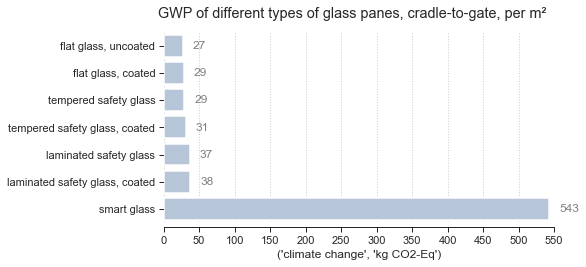

In [42]:
fig, ax = plt.subplots(figsize=(7, 3.5))

g = sns.barplot(data=df_impact_fg,
                x=("climate change", "kg CO2-Eq"),
                y=df_impact_fg.index,
                color="lightsteelblue", linewidth=1.5)

g.bar_label(g.containers[0], fmt="%.0f", padding=10, c='grey')

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 550)
plt.xticks(np.arange(0, 551, 50))

fig.suptitle(
    'GWP of different types of glass panes, cradle-to-gate, per m²')
sns.despine(left=True, offset=5)
plt.show()

Same chart, but without the smart glass:

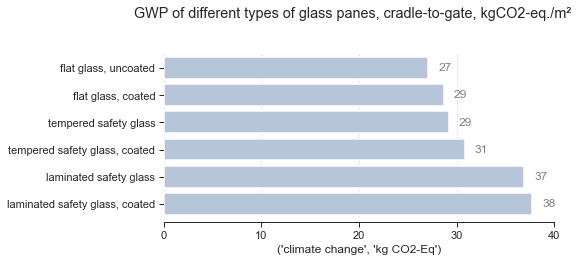

In [43]:
fig, ax = plt.subplots(figsize=(7, 3))

df_plot = df_impact_fg.drop("smart glass", axis=0)

g = sns.barplot(data=df_plot,
                x=("climate change", "kg CO2-Eq"),
                y=df_plot.index,
                color="lightsteelblue", linewidth=1.5)

g.bar_label(g.containers[0], fmt="%.0f", padding=10, c='grey')

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 40)
plt.xticks(np.arange(0, 41, 10))

fig.suptitle(
    'GWP of different types of glass panes, cradle-to-gate, kgCO2-eq./m²',
    y=1.1
)
sns.despine(left=True, offset=5)
plt.show()

Creating a DataFrame where the LCIA results are normalised to the highest value per impact category (i.e., $I_{max}= 1$):

In [44]:
df_norm_impact_fg = df_impact_fg / df_impact_fg.max()
df_norm_impact_fg.round(2)

Method                         climate change ecosystem quality          \
Unit                                kg CO2-Eq               CTU kg P-Eq   
Name                                                                      
flat glass, uncoated                     0.05              0.01    0.06   
flat glass, coated                       0.05              0.01    0.07   
tempered safety glass                    0.05              0.01    0.06   
tempered safety glass, coated            0.06              0.01    0.08   
laminated safety glass                   0.07              0.01    0.12   
laminated safety glass, coated           0.07              0.01    0.13   
smart glass                              1.00              1.00    1.00   

Method                                            human health             \
Unit                           mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                        
flat glass, uncoated                0.10     0.08         0.02       0.06   
flat glass, coated                  0.10     0.09         0.02       0.07   
tempered safety glass               0.10     0.08         0.02       0.07   
tempered safety glass, coated       0.11     0.09         0.03       0.07   
laminated safety glass              0.11     0.09         0.04       0.08   
laminated safety glass, coated      0.12     0.10         0.04       0.08   
smart glass                         1.00     1.00         1.00       1.00   

Method                         resources         
Unit                           megajoule points  
Name                                             
flat glass, uncoated                0.04   0.01  
flat glass, coated                  0.04   0.02  
tempered safety glass               0.04   0.01  
tempered safety glass, coated       0.05   0.02  
laminated safety glass              0.07   0.02  
laminated safety glass, coated      0.08   0.03  
smart glass                         1.00   1.00

In [45]:
# Normalised results, but without smart glass:
df_norm_impact_wo_smartg = (
    df_impact_fg.drop("smart glass", axis=0) /
    df_impact_fg.drop("smart glass", axis=0).max()
)
df_norm_impact_wo_smartg.round(2)

Method                         climate change ecosystem quality          \
Unit                                kg CO2-Eq               CTU kg P-Eq   
Name                                                                      
flat glass, uncoated                     0.72              0.53    0.47   
flat glass, coated                       0.76              0.68    0.59   
tempered safety glass                    0.77              0.55    0.48   
tempered safety glass, coated            0.82              0.70    0.60   
laminated safety glass                   0.98              0.92    0.94   
laminated safety glass, coated           1.00              1.00    1.00   

Method                                            human health             \
Unit                           mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                        
flat glass, uncoated                0.84     0.86         0.49       0.83   
flat glass, coated                  0.89     0.90         0.51       0.88   
tempered safety glass               0.86     0.88         0.54       0.86   
tempered safety glass, coated       0.91     0.92         0.56       0.90   
laminated safety glass              0.97     0.98         0.99       0.98   
laminated safety glass, coated      1.00     1.00         1.00       1.00   

Method                         resources         
Unit                           megajoule points  
Name                                             
flat glass, uncoated                0.54   0.48  
flat glass, coated                  0.59   0.67  
tempered safety glass               0.59   0.49  
tempered safety glass, coated       0.64   0.68  
laminated safety glass              0.97   0.90  
laminated safety glass, coated      1.00   1.00

**Now, same calculation, but using the MultiLCA class with the full list of impact categories, i.e., the 16 indicators from the ILCD midpoint method:**

In [46]:
# Defining the system with the same activities and functional units as above:
mlca_syst_fg = []

for act in inv_fg:
    mlca_syst_fg.append({act.key: fu_fg})

for act in inv_fg_processed:
    mlca_syst_fg.append({act.key: fu_fg_processed})

Conducting the LCIA:

In [47]:
bw.calculation_setups['calculation_setup'] = {'inv': mlca_syst_fg,
                                              'ia': ls_method_full}

mlca = bw.MultiLCA('calculation_setup')

# Saving the results in a DataFrame:
df_impact_mlca_fg = pd.DataFrame(data=mlca.results, columns=mlca.methods)

Reorganisating a bit the DataFrame:

In [48]:
# Listing the activities concerned:
activities = [(get_activity(key), amount)
              for dct in mlca.func_units
              for key, amount in dct.items()
              ]

# Creating a DataFrame with activities info:
df_fu = pd.DataFrame([(x['name'], x['database'], x['code'],
                       x['location'], x['unit'], y)
                      for x, y in activities],
                     columns=('Database', 'Code', 'Name',
                              'Location', 'Unit', 'Amount')
                     )

# Merging activities info and LCIA results:
df_impact_mlca_fg = pd.concat([df_fu, df_impact_mlca_fg], axis=1
                              ).set_index("Name").drop(
    ["Database", "Code", "Location", "Unit", "Amount"], axis=1
)

# Renaming the columns with multi-index, according to LCIA method:
df_impact_mlca_fg.columns = pd.MultiIndex.from_tuples(
    df_impact_mlca_fg.columns, names=(
        'Method', 'Category', 'Subcategory')
)

# Sorting results:
df_impact_mlca_fg = df_impact_mlca_fg.sort_values(
    ('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total'),
    ascending=True)

In [49]:
with pd.option_context("display.max_rows", None,
                       "display.max_columns", None,
                       "display.float_format", '{:12.1e}'.format):
    display(df_impact_mlca_fg["ILCD 2.0 2018 midpoint"])

Category                    climate change      ecosystem quality  \
Subcategory           climate change total freshwater ecotoxicity   
Name                                                                
market_glass_uncoated              2.7e+01                7.1e+00   
market_glass_coated                2.9e+01                9.1e+00   
market_tsg                         2.9e+01                7.3e+00   
market_tsg_coated                  3.1e+01                9.4e+00   
market_lsg                         3.7e+01                1.2e+01   
market_lsg_coated                  3.8e+01                1.3e+01   
market_smartglass                  5.4e+02                1.3e+03   

Category                                                        \
Subcategory           freshwater and terrestrial acidification   
Name                                                             
market_glass_uncoated                                  2.2e-01   
market_glass_coated                                    2.4e-01   
market_tsg                                             2.3e-01   
market_tsg_coated                                      2.4e-01   
market_lsg                                             2.6e-01   
market_lsg_coated                                      2.7e-01   
market_smartglass                                      2.3e+00   

Category                                                               \
Subcategory           freshwater eutrophication marine eutrophication   
Name                                                                    
market_glass_uncoated                   2.5e-03               5.2e-02   
market_glass_coated                     3.2e-03               5.4e-02   
market_tsg                              2.6e-03               5.3e-02   
market_tsg_coated                       3.2e-03               5.6e-02   
market_lsg                              5.0e-03               6.0e-02   
market_lsg_coated                       5.4e-03               6.2e-02   
market_smartglass                       4.2e-02               6.8e-01   

Category                                                     human health  \
Subcategory           terrestrial eutrophication non-carcinogenic effects   
Name                                                                        
market_glass_uncoated                    6.0e-01                  1.0e-06   
market_glass_coated                      6.3e-01                  1.4e-06   
market_tsg                               6.2e-01                  1.0e-06   
market_tsg_coated                        6.5e-01                  1.4e-06   
market_lsg                               6.9e-01                  1.9e-06   
market_lsg_coated                        7.0e-01                  2.1e-06   
market_smartglass                        7.4e+00                  7.5e-05   

Category                                                       \
Subcategory           carcinogenic effects ionising radiation   
Name                                                            
market_glass_uncoated              2.4e-07            3.1e+00   
market_glass_coated                3.4e-07            3.9e+00   
market_tsg                         2.5e-07            3.2e+00   
market_tsg_coated                  3.5e-07            4.0e+00   
market_lsg                         4.3e-07            9.2e+00   
market_lsg_coated                  4.9e-07            9.6e+00   
market_smartglass                  1.1e-05            5.9e+01   

Category                                                                  \
Subcategory           ozone layer depletion photochemical ozone creation   
Name                                                                       
market_glass_uncoated               2.7e-06                      1.4e-01   
market_glass_coated                 2.9e-06                      1.5e-01   
market_tsg                          3.0e-06                      1.5e-01   
market_tsg_coated                   3.2

Creating a DataFrame where the LCIA results are normalised to the highest value per impact category (i.e., $I_{max}= 1$):

In [50]:
df_norm_impact_mlca_fg = (
    df_impact_mlca_fg.drop("market_smartglass")
    / df_impact_mlca_fg.drop("market_smartglass").max()
)

# Reorganising the DataFrame columns:
df_norm_impact_mlca_fg.columns = (
    df_norm_impact_mlca_fg.columns.droplevel([0, 1])
)

Printing a heatmap with the normalised results (1 = maximum impact):

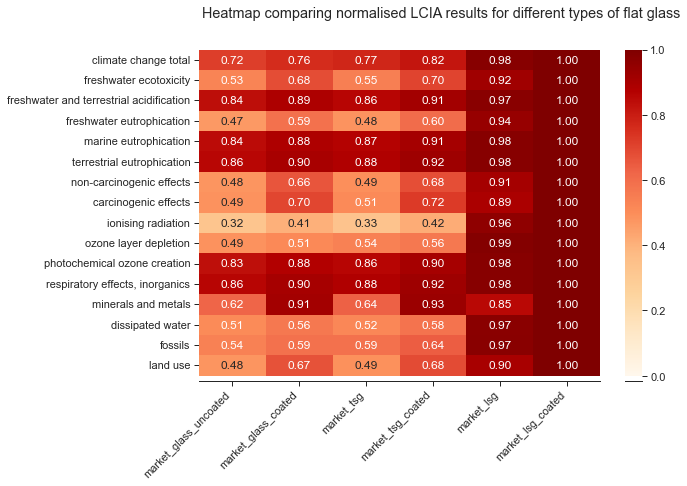

In [51]:
fig, ax = plt.subplots(figsize=(9, 6))

df_plot = df_norm_impact_mlca_fg.T

ax = sns.heatmap(df_plot, cmap="OrRd", vmin=0, vmax=1, annot=True, fmt='.2f')

ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)

fig.suptitle(
    'Heatmap comparing normalised LCIA results'
    ' for different types of flat glass')

sns.despine(left=True, offset=5)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

plt.show()

Printing a chart giving an overview of the environmental impact of each flat glass product according to each of the 16 indicators:

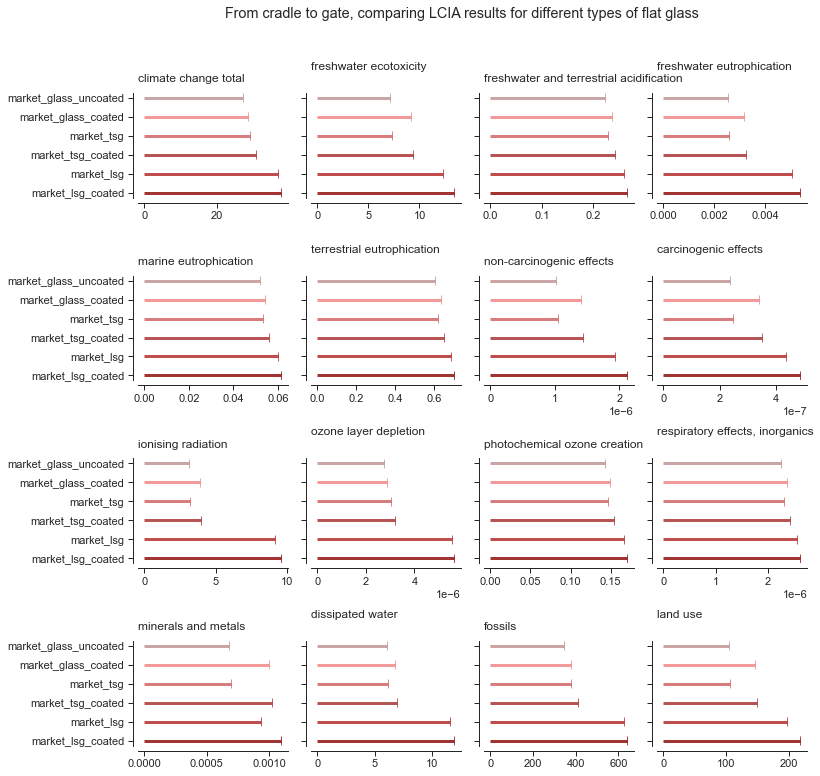

In [52]:
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(12, 12))

df_plot = df_impact_mlca_fg.drop("market_smartglass")
df_plot.columns = (df_plot.columns.droplevel([0, 1]))

c = ["rosybrown", "lightcoral", "indianred",
     "brown", "firebrick", "darkred"]

n = 0

for row in range(4):
    for col in range(4):
        col_name = df_plot.columns[n]
        ax = axes[row][col]

        ax.hlines(y=df_plot.index, xmin=0, xmax=df_plot[col_name],
                  linewidth=3, colors=c, alpha=0.8)

        sns.scatterplot(y=df_plot.index, x=df_plot[col_name],
                        hue=df_plot.index, s=80, marker="|",
                        palette=c, ax=ax)

        if (n % 2) == 0:
            ax.set_title(col_name, y=1.05, x=0,
                         ha='left', multialignment='left')
        else:
            ax.set_title(col_name, y=1.17, x=0,
                         ha='left', multialignment='left')

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        ax.get_legend().remove()

        n += 1

fig.subplots_adjust(wspace=0.15, hspace=0.75)

fig.suptitle(
    'From cradle to gate, comparing LCIA results' +
    ' for different types of flat glass')
sns.despine(offset=5)
plt.show()

**Weighted environmental impact:**

Comparing the different types of glass pane according to a single indicator calculated using the PEF weighting factors:

In [53]:
# Defining a new DataFrame with the weighted values,
# i.e., multiplication of the impacts by df_weighting:
df_weighted_fg = pd.DataFrame(
    (df_impact_mlca_fg["ILCD 2.0 2018 midpoint"]
     .multiply(df_weighting["Weighting factor"].T, axis=1) / 100
     ).sum(axis=1), columns=['Weighted impact']
)

df_weighted_fg = df_weighted_fg.sort_values("Weighted impact",
                                            ascending=True
                                            )

df_weighted_fg

,Weighted impact
Name,
market_glass_uncoated,43.487143
market_tsg,46.874804
market_glass_coated,50.047313
market_tsg_coated,53.566178
market_lsg,77.051885
market_lsg_coated,80.397571
market_smartglass,1477.659478


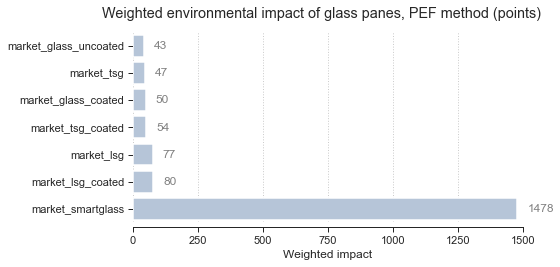

In [54]:
# Printing a barplot figure with the weighted results:
fig, ax = plt.subplots(figsize=(7, 3.5))

g = sns.barplot(data=df_weighted_fg,
                x="Weighted impact",
                y=df_weighted_fg.index,
                color="lightsteelblue", linewidth=1.5)

g.bar_label(g.containers[0], fmt="%.0f", padding=10, c='grey')

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 1500)
plt.xticks(np.arange(0, 1501, 250))

fig.suptitle('Weighted environmental impact of glass panes,'
             ' PEF method (points)')
sns.despine(left=True, offset=5)
plt.show()

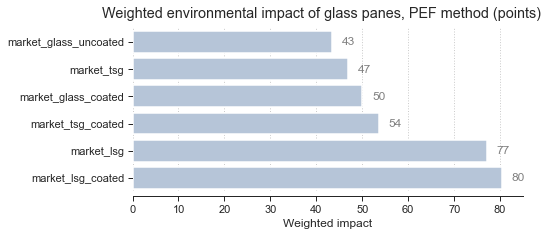

In [55]:
# Printing a barplot figure with the weighted results w/o smart glass:
fig, ax = plt.subplots(figsize=(7, 3))

df_plot = df_weighted_fg.drop("market_smartglass")

g = sns.barplot(data=df_plot,
                x="Weighted impact",
                y=df_plot.index,
                color="lightsteelblue", linewidth=1.5)

g.bar_label(g.containers[0], fmt="%.0f", padding=10, c='grey')

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 85)
plt.xticks(np.arange(0, 81, 10))

fig.suptitle('Weighted environmental impact of glass panes,'
             ' PEF method (points)')
sns.despine(left=True, offset=5)
plt.show()

## A Comparative Analysis of Spacers, Sealants and Insulating Gases, Cradle-to-Gate

### Comparative Analysis of Spacers

Selecting the activities and defining the functional unit:

In [56]:
# List of IGUs (production activities) with different types of spacer and sealant:
inv_spacers = [act for act in bw.Database("exldb_spacers")
               if 'krypton' not in act['name']
               and 'xenon' not in act['name']
               and 'air' not in act['name']]

# 1 m² of IGU:
fu_spacers = [{igu: 1} for igu in inv_spacers]

In [57]:
print("\033[1m", "List of the activities assessed:", "\033[0m")

for fu in fu_spacers:
    for key, value in fu.items():
        print(key["name"])

 List of the activities assessed: 
double glazing production, dual-seal composite plastic, argon
double glazing production, slicone foam, argon
double glazing production, thermoplastic PIB, argon
double glazing production, dual-seal steel, argon
double glazing production, composite with corrugated metal, argon
double glazing production, dual-seal aluminium, argon
double glazing production, thermally broken aluminium, argon
double glazing production, epdm foam, argon
double glazing production, without spacer, argon
double glazing production, single-seal aluminium, argon


Conducting the LCIA:

In [58]:
impact_spacers = []

for igu in inv_spacers:
    lca = bw.LCA({igu: 1})
    lca.lci()
    for method in ls_method_full:
        lca.switch_method(method)
        lca.lcia()
        impact_spacers.append((igu["name"], igu["location"],
                               method[1], method[2], lca.score,
                               bw.methods.get(method).get('unit'))
                              )

Creating a DataFrame with the LCIA results:

In [59]:
# Creating the DataFrame:
df_impact_spacers = pd.DataFrame(
    impact_spacers,
    columns=["Name", "Location", "Category", "Subcategory", "Score", "Unit"]
)

# And reorganising it:
df_impact_spacers = pd.pivot_table(
    df_impact_spacers, index=["Name"],
    columns=["Category", "Subcategory", "Unit"], values="Score"
)

df_impact_spacers = df_impact_spacers.sort_values(
    ("climate change", "climate change total", "kg CO2-Eq"), ascending=True
)

# Simplifying the index:
df_impact_spacers.index = (df_impact_spacers.index
                           .str.replace('double glazing production, ', '')
                           .str.replace(', argon', '')
                           )

In [60]:
with pd.option_context("display.max_rows", None,
                       "display.max_columns", None,
                       "display.float_format", '{:12.1e}'.format):
    display(df_impact_spacers)

Category                              climate change  \
Subcategory                     climate change total   
Unit                                       kg CO2-Eq   
Name                                                   
without spacer                               4.5e+01   
composite with corrugated metal              4.6e+01   
epdm foam                                    4.6e+01   
single-seal aluminium                        4.7e+01   
dual-seal aluminium                          4.7e+01   
dual-seal steel                              4.7e+01   
thermally broken aluminium                   4.7e+01   
thermoplastic PIB                            4.7e+01   
slicone foam                                 4.8e+01   
dual-seal composite plastic                  5.9e+01   

Category                                               ecosystem quality  \
Subcategory                     freshwater and terrestrial acidification   
Unit                                                           mol H+-Eq   
Name                                                                       
without spacer                                                   3.7e-01   
composite with corrugated metal                                  3.7e-01   
epdm foam                                                        3.8e-01   
single-seal aluminium                                            3.8e-01   
dual-seal aluminium                                              3.8e-01   
dual-seal steel                                                  3.8e-01   
thermally broken aluminium                                       3.8e-01   
thermoplastic PIB                                                3.8e-01   
slicone foam                                                     3.8e-01   
dual-seal composite plastic                                      4.4e-01   

Category                                                \
Subcategory                     freshwater ecotoxicity   
Unit                                               CTU   
Name                                                     
without spacer                                 1.3e+01   
composite with corrugated metal                1.4e+01   
epdm foam                                      1.5e+01   
single-seal aluminium                          1.7e+01   
dual-seal aluminium                            1.7e+01   
dual-seal steel                                1.7e+01   
thermally broken aluminium                     1.7e+01   
thermoplastic PIB                              1.5e+01   
slicone foam                                   1.5e+01   
dual-seal composite plastic                    2.0e+01   

Category                                                   \
Subcategory                     freshwater eutrophication   
Unit                                              kg P-Eq   
Name                                                        
without spacer                                    4.6e-03   
composite with corrugated metal                   4.9e-03   
epdm foam                                         5.0e-03   
single-seal aluminium                             5.2e-03   
dual-seal aluminium                               5.2e-03   
dual-seal steel                                   5.2e-03   
thermally broken aluminium                        5.3e-03   
thermoplastic PIB                                 5.2e-03   
slicone foam                                      5.5e-03   
dual-seal composite plastic                       9.4e-03   

Category                                               \
Subcategory                     marine eutrophication   
Unit                                          kg N-Eq   
Name                                                    
without spacer                                8.5e-02   
composite with corrugated metal               8.6e-02   
epdm foam                                     8.6e-02   
single-seal aluminium                         8.7e-02   
dual-seal aluminium       

Printing a bar chart showing the climate change potential of the different flat glass products:

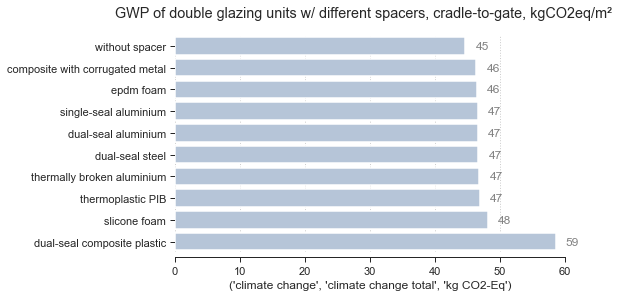

In [61]:
fig, ax = plt.subplots(figsize=(7, 4))

g = sns.barplot(data=df_impact_spacers,
                x=("climate change", "climate change total", "kg CO2-Eq"),
                y=df_impact_spacers.index,
                color="lightsteelblue", linewidth=1.5)

g.bar_label(g.containers[0], fmt="%.0f", padding=10, c='grey')

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 60)
plt.xticks(np.arange(0, 61, 10))

fig.suptitle(
    'GWP of double glazing units w/ different spacers,'
    ' cradle-to-gate, kgCO2eq/m²')
sns.despine(left=True, offset=5)
plt.show()

Normalising the results according to the highest value:

In [62]:
df_norm_impact_spacers = df_impact_spacers / df_impact_spacers.max()

Printing a heatmap with the normalised results (1 = maximum impact):

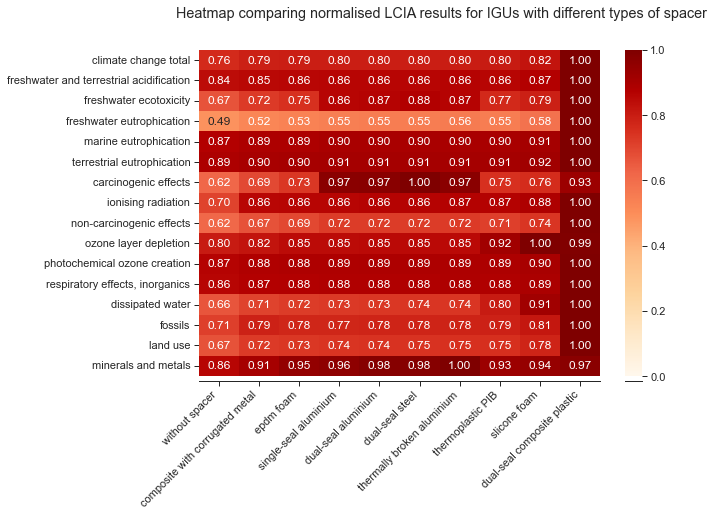

In [63]:
fig, ax = plt.subplots(figsize=(9, 6))

y_axis_labels = []
for label in df_norm_impact_spacers.columns:
    y_axis_labels.append(label[1])

df_plot = df_norm_impact_spacers.T

ax = sns.heatmap(df_plot, cmap="OrRd", vmin=0, vmax=1, annot=True, fmt='.2f',
                 yticklabels=y_axis_labels)

ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)

fig.suptitle(
    'Heatmap comparing normalised LCIA results'
    ' for IGUs with different types of spacer')
sns.despine(left=True, offset=5)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

plt.show()

Printing the full LCIA results:

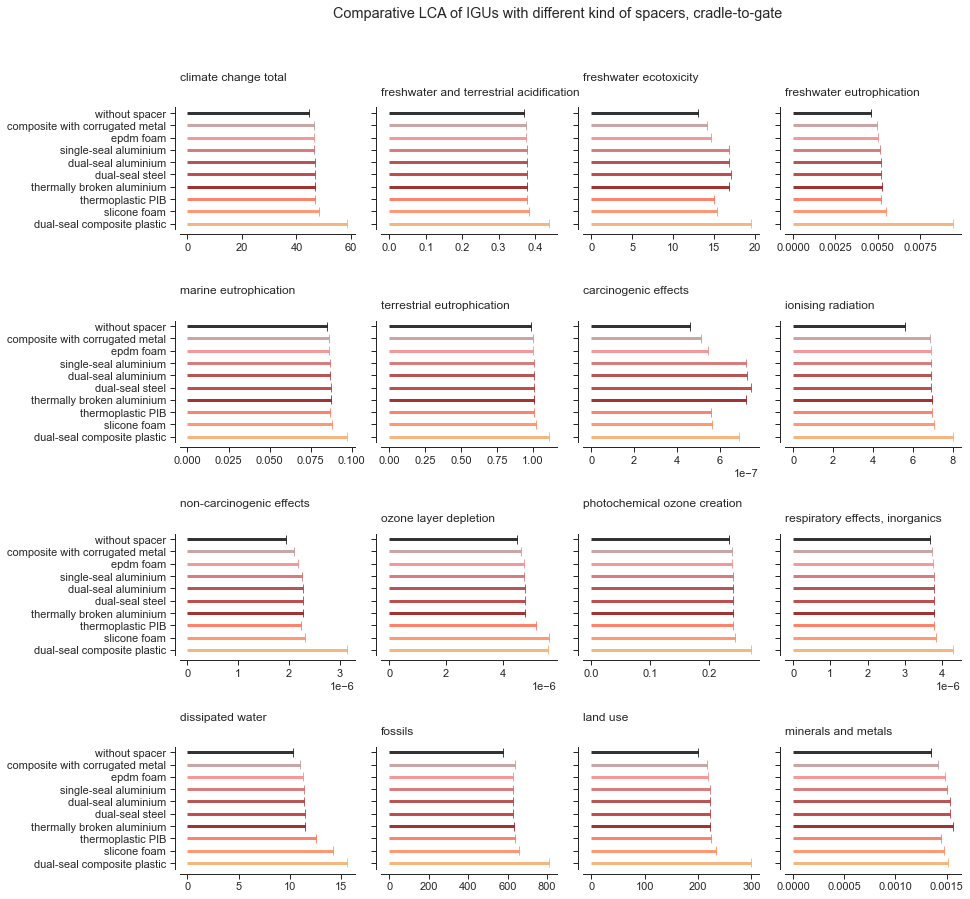

In [64]:
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(14, 14))

c = ["black", "rosybrown", "lightcoral", "indianred",
     "brown", "firebrick", "darkred",
     "tomato", "coral", "sandybrown"]

n = 0

for row in range(4):
    for col in range(4):
        col_name = df_impact_spacers.columns[n]
        ax = axes[row][col]

        ax.hlines(y=df_impact_spacers.index,
                  xmin=0, xmax=df_impact_spacers[col_name],
                  linewidth=3, colors=c, alpha=0.8
                  )

        sns.scatterplot(y=df_impact_spacers.index,
                        x=df_impact_spacers[col_name],
                        hue=df_impact_spacers.index,
                        s=80, marker="|", palette=c, ax=ax
                        )

        if (n % 2) == 0:
            ax.set_title(col_name[1], y=1.17, x=0,
                         ha='left', multialignment='left')
        else:
            ax.set_title(col_name[1], y=1.05, x=0,
                         ha='left', multialignment='left')

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        ax.get_legend().remove()

        n += 1

fig.subplots_adjust(wspace=0.15, hspace=0.75)

fig.suptitle(
    'Comparative LCA of IGUs with different kind of spacers, cradle-to-gate')
sns.despine(offset=5)
plt.show()

**Weighted environmental impact:**

Weighting the LCIA results according to the PEF weighting factors:

In [65]:
# First, dropping the unit row index to ease the calculation:
df_weighted_spacers = df_impact_spacers.copy()
df_weighted_spacers.columns = df_weighted_spacers.columns.droplevel(2)

# Defining a new DataFrame with the weighted values,
# i.e., multiplication of the impacts by df_weighting:
df_weighted_spacers = pd.DataFrame(
    (df_weighted_spacers.multiply(
        df_weighting["Weighting factor"].T, axis=1) / 100
     ).sum(axis=1), columns=['Weighted impact']
)

df_weighted_spacers = df_weighted_spacers.sort_values("Weighted impact",
                                                      ascending=True
                                                      )

df_weighted_spacers

,Weighted impact
Name,
without spacer,74.934996
epdm foam,81.205578
single-seal aluminium,81.340000
composite with corrugated metal,81.558729
dual-seal aluminium,81.623840
dual-seal steel,81.657879
thermally broken aluminium,82.080301
thermoplastic PIB,82.420927
slicone foam,85.408988


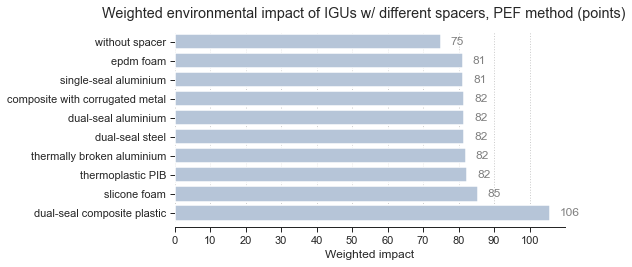

In [66]:
# Printing a barplot figure with the weighted results:
fig, ax = plt.subplots(figsize=(7, 3.5))

g = sns.barplot(data=df_weighted_spacers,
                x="Weighted impact",
                y=df_weighted_spacers.index,
                color="lightsteelblue", linewidth=1.5)

g.bar_label(g.containers[0], fmt="%.0f", padding=10, c='grey')

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 110)
plt.xticks(np.arange(0, 101, 10))

fig.suptitle('Weighted environmental impact of IGUs w/ different spacers,'
             ' PEF method (points)')
sns.despine(left=True, offset=5)
plt.show()

### Comparative Analysis of Insulating Gases

Listing the activities and defining the functional unit

In [67]:
# List of the production activities of similar IGU,
# w/ different insulating gases:
inv_gas = [act for act in bw.Database("exldb_spacers")
           if 'thermally broken aluminium' in act['name']
           ]

# 1 m² of IGU:
fu_gas = [{igu: 1} for igu in inv_gas]

In [68]:
print("\033[1m", "List of the activities assessed:", "\033[0m")

for fu in fu_gas:
    for key, value in fu.items():
        print(key["name"])

 List of the activities assessed: 
double glazing production, thermally broken aluminium, argon
double glazing production, thermally broken aluminium, air
double glazing production, thermally broken aluminium, xenon
double glazing production, thermally broken aluminium, krypton


Conducting the LCIA:

In [69]:
# Creating a list where results will be saved:
impact_gas = []

for igu in inv_gas:
    lca = bw.LCA({igu: 1})
    lca.lci()
    for method in ls_method_full:
        lca.switch_method(method)
        lca.lcia()
        impact_gas.append((igu["name"], igu["location"],
                           method[1], method[2], lca.score,
                           bw.methods.get(method).get('unit')))

Organising the results in a DataFrame:

In [70]:
# Creating a DataFrame:
df_impact_gas = pd.DataFrame(
    impact_gas,
    columns=["Name", "Location", "Category", "Subcategory", "Score", "Unit"]
)

# Reorganising it:
df_impact_gas = pd.pivot_table(
    df_impact_gas, index=["Name"],
    columns=["Category", "Subcategory", "Unit"], values="Score"
)

# Sorting the values:
df_impact_gas = df_impact_gas.sort_values(
    ("climate change", "climate change total", "kg CO2-Eq"), ascending=True
)

# Simplifying the index:
df_impact_gas.index = (df_impact_gas.index
                       .str.replace('double glazing production, ', '')
                       .str.replace('thermally broken aluminium, ', '')
                       )

In [71]:
with pd.option_context("display.max_rows", None,
                       "display.max_columns", None,
                       "display.float_format", '{:12.1e}'.format):
    display(df_impact_gas)

Category          climate change                        ecosystem quality  \
Subcategory climate change total freshwater and terrestrial acidification   
Unit                   kg CO2-Eq                                mol H+-Eq   
Name                                                                        
air                      4.7e+01                                  3.8e-01   
argon                    4.7e+01                                  3.8e-01   
krypton                  5.1e+01                                  4.0e-01   
xenon                    6.4e+01                                  4.7e-01   

Category                                                      \
Subcategory freshwater ecotoxicity freshwater eutrophication   
Unit                           CTU                   kg P-Eq   
Name                                                           
air                        1.7e+01                   5.2e-03   
argon                      1.7e+01                   5.3e-03   
krypton                    1.8e+01                   7.6e-03   
xenon                      2.3e+01                   2.2e-02   

Category                                                      \
Subcategory marine eutrophication terrestrial eutrophication   
Unit                      kg N-Eq                   mol N-Eq   
Name                                                           
air                       8.7e-02                    1.0e+00   
argon                     8.7e-02                    1.0e+00   
krypton                   9.2e-02                    1.1e+00   
xenon                     1.0e-01                    1.2e+00   

Category            human health                                              \
Subcategory carcinogenic effects ionising radiation non-carcinogenic effects   
Unit                        CTUh         kg U235-Eq                     CTUh   
Name                                                                           
air                      7.2e-07            6.9e+00                  2.3e-06   
argon                    7.3e-07            7.0e+00                  2.3e-06   
krypton                  7.7e-07            7.7e+00                  2.6e-06   
xenon                    9.7e-07            1.7e+01                  4.0e-06   

Category                                                        \
Subcategory ozone layer depletion photochemical ozone creation   
Unit                   kg CFC-11.                   kg NMVOC-.   
Name                                                             
air                       4.8e-06                      2.4e-01   
argon                     4.8e-06                      2.4e-01   
krypton                   4.9e-06                      2.5e-01   
xenon                     5.6e-06                      2.8e-01   

Category                                           resources               \
Subcategory respiratory effects, inorganics dissipated water      fossils   
Unit                             disease i.       m3 water-.    megajoule   
Name                                                                        
air                                 3.8e-06          1.1e+01      6.3e+02   
argon                               3.8e-06          1.1e+01      6.3e+02   
krypton                             4.0e-06          1.3e+01      7.1e+02   
xenon                               4.0e-06          2.2e+01      1.0e+03   

Category                                      
Subcategory     land use minerals and metals  
Unit              points            kg Sb-Eq  
Name                                          
air              2.2e+02             1.6e-03  
argon            2.2e+02             1.6e-03  
krypton          2.4e+02             1.6e-03  
xenon            3.3e+02             1.7e-03

Normalising the results according to the highest value:

In [72]:
df_norm_impact_gas = df_impact_gas / df_impact_gas.max()

Printing a heatmap with the normalised results (1 = maximum impact):

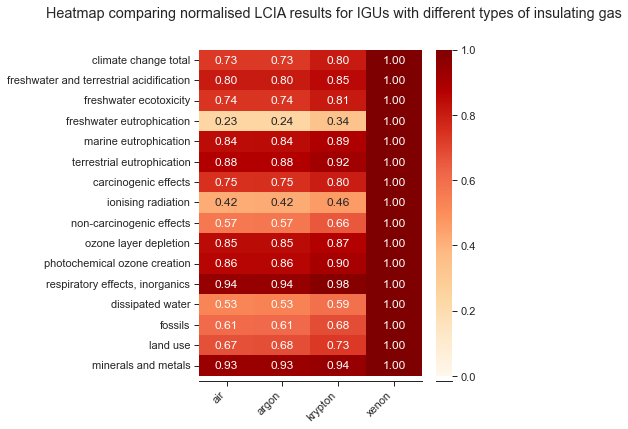

In [73]:
fig, ax = plt.subplots(figsize=(5, 6))

y_axis_labels = []
for label in df_norm_impact_gas.columns:
    y_axis_labels.append(label[1])

df_plot = df_norm_impact_gas.T

ax = sns.heatmap(df_plot, cmap="OrRd", vmin=0, vmax=1, annot=True, fmt='.2f',
                 yticklabels=y_axis_labels)

ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)

fig.suptitle(
    'Heatmap comparing normalised LCIA results'
    ' for IGUs with different types of insulating gas')
sns.despine(left=True, offset=5)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

plt.show()

Printing the full LCIA results:

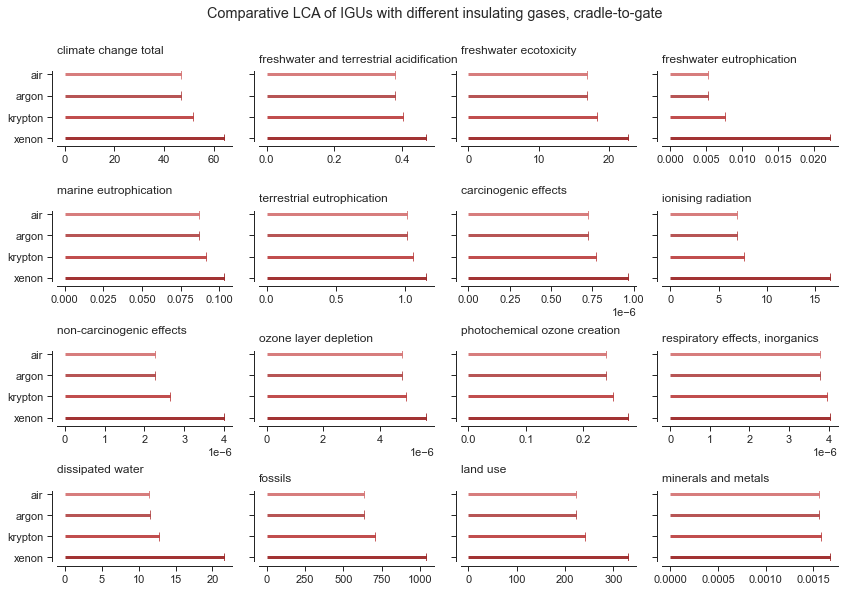

In [74]:
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(14, 9))

c = ["indianred", "brown", "firebrick", "darkred"]

n = 0

for row in range(4):
    for col in range(4):
        col_name = df_impact_gas.columns[n]
        ax = axes[row][col]

        ax.hlines(y=df_impact_gas.index,
                  xmin=0, xmax=df_impact_gas[col_name],
                  linewidth=3, colors=c, alpha=0.8)

        sns.scatterplot(y=df_impact_gas.index,
                        x=df_impact_gas[col_name],
                        hue=df_impact_gas.index, s=80, marker="|",
                        palette=c, ax=ax)

        if (n % 2) == 0:
            ax.set_title(col_name[1], y=1.17, x=0,
                         ha='left', multialignment='left')
        else:
            ax.set_title(col_name[1], y=1.05, x=0,
                         ha='left', multialignment='left')

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        ax.get_legend().remove()

        n += 1

fig.subplots_adjust(wspace=0.15, hspace=1)

fig.suptitle(
    'Comparative LCA of IGUs with different insulating gases, cradle-to-gate'
)
sns.despine(offset=5)
plt.show()

**Weighted environmental impact:**

Weighting the LCIA results according to the PEF weighting factors:

In [75]:
# Dropping the unit row index to ease the calculation:
df_weighted_gas = df_impact_gas.copy()
df_weighted_gas.columns = df_weighted_gas.columns.droplevel(2)

# Defining a new DataFrame with the weighted values,
# i.e., multiplication of the impacts by df_weighting:
df_weighted_gas = pd.DataFrame(
    (df_weighted_gas.multiply(
        df_weighting["Weighting factor"].T, axis=1) / 100
     ).sum(axis=1), columns=['Weighted impact']
)

df_weighted_gas = df_weighted_gas.sort_values("Weighted impact",
                                              ascending=True
                                              )

df_weighted_gas

,Weighted impact
Name,
air,81.844345
argon,82.080301
krypton,90.650686
xenon,129.406049


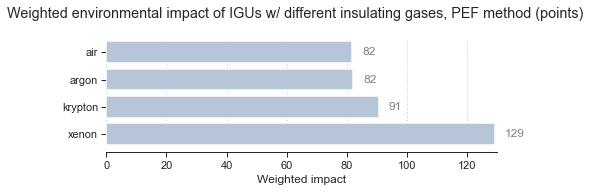

In [76]:
# Printing a barplot figure with the weighted results:
fig, ax = plt.subplots(figsize=(7, 2))

g = sns.barplot(data=df_weighted_gas,
                x="Weighted impact",
                y=df_weighted_gas.index,
                color="lightsteelblue", linewidth=1.5)

g.bar_label(g.containers[0], fmt="%.0f", padding=10, c='grey')

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 130)
plt.xticks(np.arange(0, 121, 20))

fig.suptitle('Weighted environmental impact of IGUs '
             'w/ different insulating gases,'
             ' PEF method (points)', y=1.1)
sns.despine(left=True, offset=5)
plt.show()

## From Single to Triple Glazing: A Comparative LCA of IGUs, Cradle-to-Gate

Listing the IGUs (market activities) and the functional units:

In [77]:
# List of the market actitivities relating to the glazing products studied:
inv_igus = [act for act in bw.Database("exldb_igu")
            if 'market' in act['name']
            and ('glazing' in act['name']
            or 'vacuum' in act['name'])
            ]

# 1 m² of IGU:
fu_igus = [{igu: 1} for igu in inv_igus]

In [78]:
print("\033[1m", "List of the activities assessed:", "\033[0m")

for fu in fu_igus:
    for key, value in fu.items():
        print(key["name"])

 List of the activities assessed: 
market for single glazing, lsg
market for triple glazing, lsg, two coatings, krypton
market for single glazing, lsg, coated
market for double glazing, lsg, two coatings, xenon
market for triple glazing, lsg, two coatings, xenon
market for double glazing, lsg, vacuum
market for double glazing, lsg, coated
market for double glazing, lsg, two coatings
market for triple glazing, coated
market for double glazing, lsg
market for triple glazing, lsg, coated
market for triple glazing, lsg, two coatings
market for smart glass, double glazing
market for double glazing, lsg, coated, krypton
market for double glazing, coated


Conducting the LCIA:

In [79]:
impact_igus = []

for igu in inv_igus:
    lca = bw.LCA({igu: 1})
    lca.lci()
    for method in ls_method_full:
        lca.switch_method(method)
        lca.lcia()
        impact_igus.append((igu["name"], igu["location"],
                            method[1], method[2], lca.score,
                            bw.methods.get(method).get('unit')))

Creating a DataFrame with the LCIA results:

In [80]:
# Creating a new DataFrame from the impact list:
df_impact_igus = pd.DataFrame(
    impact_igus,
    columns=["Name", "Location", "Category", "Subcategory", "Score", "Unit"]
)

# Reorganising it:
df_impact_igus = pd.pivot_table(
    df_impact_igus, index=["Name"],
    columns=["Category", "Subcategory", "Unit"], values="Score"
)

# Sorting the values:
df_impact_igus = df_impact_igus.sort_values(
    ("climate change", "climate change total", "kg CO2-Eq"), ascending=True
)

# Simplifying the index:
df_impact_igus.index = df_impact_igus.index.str.replace('market for ', '')

In [81]:
with pd.option_context("display.max_rows", None,
                       "display.max_columns", None,
                       "display.float_format", '{:12.2e}'.format):
    display(df_impact_igus)

Category                                         climate change  \
Subcategory                                climate change total   
Unit                                                  kg CO2-Eq   
Name                                                              
single glazing, lsg                                    3.80e+01   
single glazing, lsg, coated                            3.88e+01   
double glazing, coated                                 4.81e+01   
double glazing, lsg                                    6.22e+01   
double glazing, lsg, coated                            6.34e+01   
double glazing, lsg, two coatings                      6.43e+01   
double glazing, lsg, vacuum                            6.54e+01   
triple glazing, coated                                 6.60e+01   
double glazing, lsg, coated, krypton                   6.86e+01   
triple glazing, lsg, two coatings                      8.14e+01   
triple glazing, lsg, coated                            8.17e+01   
double glazing, lsg, two coatings, xenon               8.38e+01   
triple glazing, lsg, two coatings, krypton             9.17e+01   
triple glazing, lsg, two coatings, xenon               1.20e+02   
smart glass, double glazing                            7.01e+02   

Category                                                          ecosystem quality  \
Subcategory                                freshwater and terrestrial acidification   
Unit                                                                      mol H+-Eq   
Name                                                                                  
single glazing, lsg                                                        2.65e-01   
single glazing, lsg, coated                                                2.71e-01   
double glazing, coated                                                     3.84e-01   
double glazing, lsg                                                        4.55e-01   
double glazing, lsg, coated                                                4.65e-01   
double glazing, lsg, two coatings                                          4.72e-01   
double glazing, lsg, vacuum                                                4.69e-01   
triple glazing, coated                                                     5.27e-01   
double glazing, lsg, coated, krypton                                       4.91e-01   
triple glazing, lsg, two coatings                                          6.11e-01   
triple glazing, lsg, coated                                                6.09e-01   
double glazing, lsg, two coatings, xenon                                   5.76e-01   
triple glazing, lsg, two coatings, krypton                                 6.63e-01   
triple glazing, lsg, two coatings, xenon                                   8.19e-01   
smart glass, double glazing                                                3.29e+00   

Category                                                           \
Subcategory                                freshwater ecotoxicity   
Unit                                                          CTU   
Name                                                                
single glazing, lsg                                      1.42e+01   
single glazing, lsg, coated                              1.52e+01   
double glazing, coated                                   1.95e+01   
double glazing, lsg                                      2.48e+01   
double glazing, lsg, coated                              2.65e+01   
double glazing, lsg, two coatings                        2.75e+01   
double glazing, lsg, vacuum                              2.36e+01   
triple glazing, coated                                   2.73e+01   
double glazing, lsg, coated, krypton                     2.81e+01   
triple glazing, lsg, two coatings                        3.32e+01   
triple glazing, lsg, coated                              3.51e+01   
double glazing, lsg, two coatings, xe

Normalising the results according to the highest value:

In [82]:
# With all the IGUs:
df_norm_impact_igus = df_impact_igus / df_impact_igus.max()

In [83]:
# ... and without the smart double glazing:
df_norm_impact_igus_wo_smartg = (
    df_impact_igus.drop("smart glass, double glazing", axis=0) /
    df_impact_igus.drop("smart glass, double glazing", axis=0).max()
)

Printing a heatmap with the normalised results (1 = maximum impact):

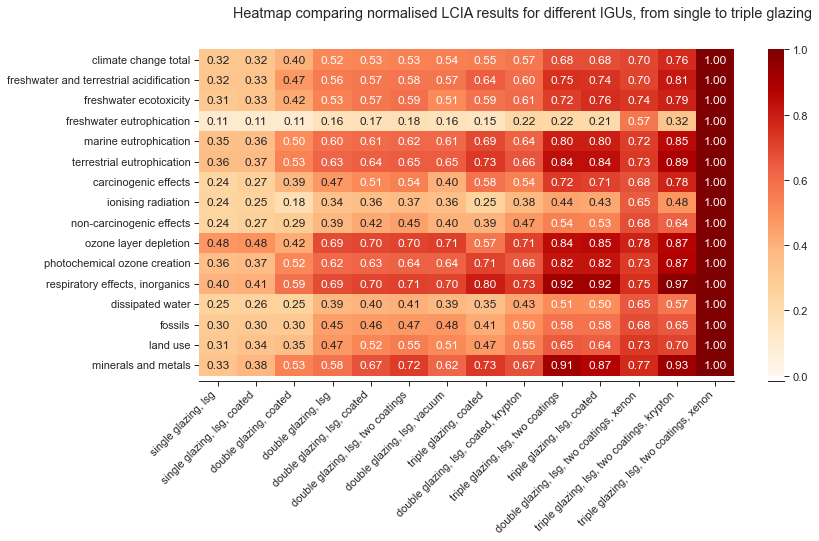

In [84]:
fig, ax = plt.subplots(figsize=(12, 6))

y_axis_labels = []
for label in df_norm_impact_igus_wo_smartg.columns:
    y_axis_labels.append(label[1])

df_plot = df_norm_impact_igus_wo_smartg.T

ax = sns.heatmap(df_plot, cmap="OrRd", vmin=0, vmax=1, annot=True, fmt='.2f',
                 yticklabels=y_axis_labels)

ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)

fig.suptitle(
    'Heatmap comparing normalised LCIA results'
    ' for different IGUs, from single to triple glazing')
sns.despine(left=True, offset=5)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

plt.show()

Printing the full LCIA results:

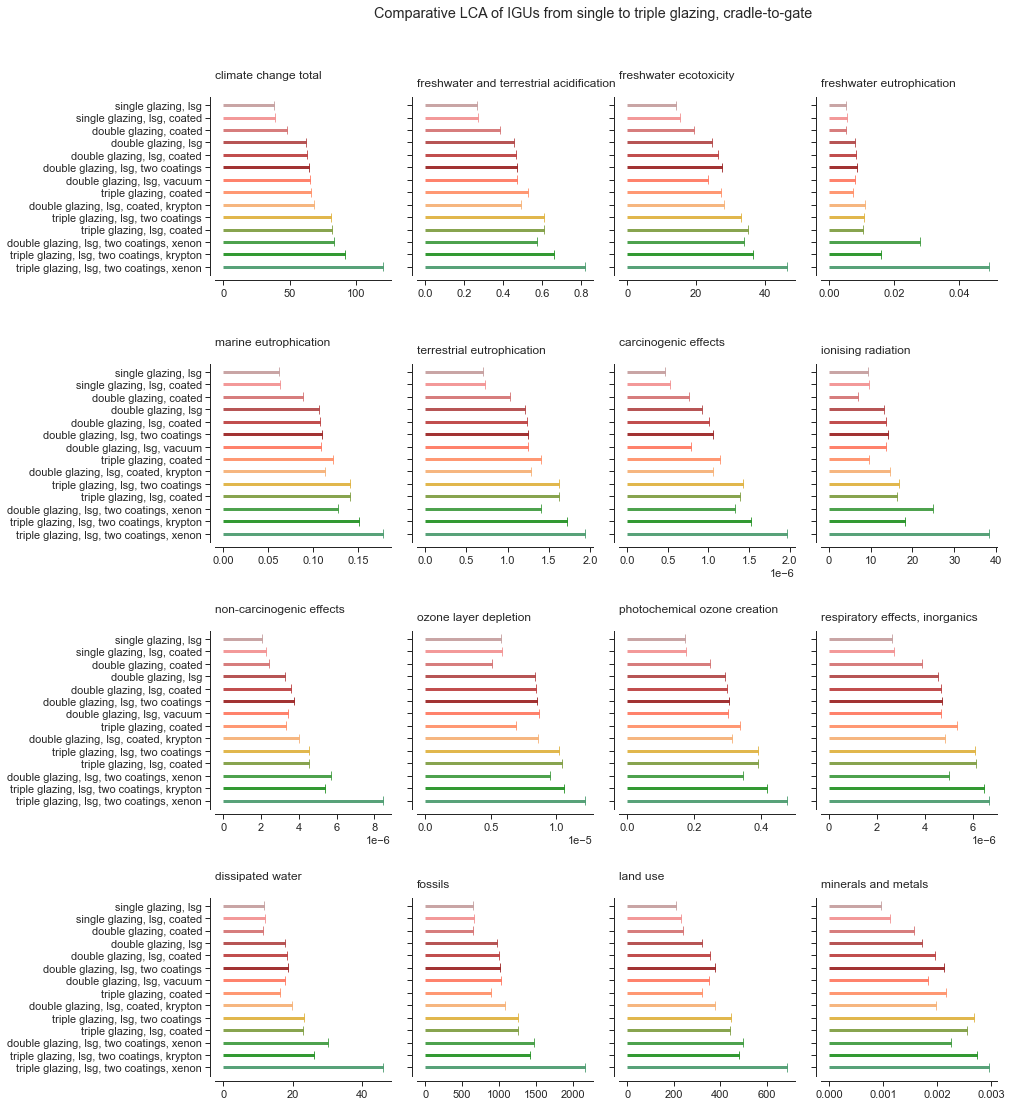

In [85]:
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(14, 18))

df_plot = df_impact_igus.drop("smart glass, double glazing")

c = ["rosybrown", "lightcoral", "indianred",
     "brown", "firebrick", "darkred",
     "tomato", "coral", "sandybrown",
     "goldenrod", "olivedrab", "forestgreen",
     "green", "seagreen"
     ]

n = 0

for row in range(4):
    for col in range(4):
        col_name = df_plot.columns[n]
        ax = axes[row][col]

        ax.hlines(y=df_plot.index, xmin=0, xmax=df_plot[col_name],
                  linewidth=3, colors=c, alpha=0.8)

        sns.scatterplot(y=df_plot.index, x=df_plot[col_name],
                        hue=df_plot.index, s=80, marker="|",
                        palette=c, ax=ax)

        if (n % 2) == 0:
            ax.set_title(col_name[1], y=1.07, x=0,
                         ha='left', multialignment='left')
        else:
            ax.set_title(col_name[1], y=1.025, x=0,
                         ha='left', multialignment='left')

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        ax.get_legend().remove()

        n += 1

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle(
    'Comparative LCA of IGUs from single to triple glazing, cradle-to-gate',
    y=0.95
)
sns.despine(offset=5)
plt.show()

**Weighted environmental impact:**

Comparing different types of IGUs according to a single indicator calculated using PEF weighting factors:

In [86]:
# Dropping the unit row index to ease the calculation:
df_weighted_igus = df_impact_igus.copy()
df_weighted_igus.columns = df_weighted_igus.columns.droplevel(2)

# Defining a new DataFrame with the weighted values,
# i.e., multiplication of the impacts by df_weighting:
df_weighted_igus = pd.DataFrame(
    (df_weighted_igus.multiply(
        df_weighting["Weighting factor"].T, axis=1) / 100
     ).sum(axis=1), columns=['Weighted impact']
)

df_weighted_igus = df_weighted_igus.sort_values("Weighted impact",
                                                ascending=True
                                                )

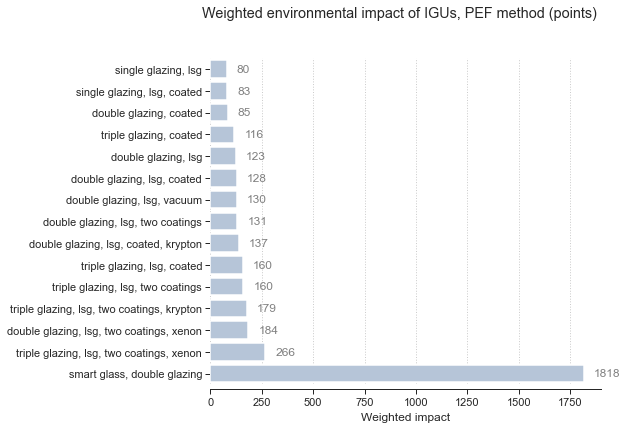

In [87]:
# Printing a barplot figure with the weighted results:
fig, ax = plt.subplots(figsize=(7, 6))

g = sns.barplot(data=df_weighted_igus,
                x="Weighted impact",
                y=df_weighted_igus.index,
                color="lightsteelblue", linewidth=1.5)

g.bar_label(g.containers[0], fmt="%.0f", padding=10, c='grey')

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 1900)
plt.xticks(np.arange(0, 1901, 250))

fig.suptitle('Weighted environmental impact of IGUs,'
             ' PEF method (points)', y=1)
sns.despine(left=True, offset=5)
plt.show()

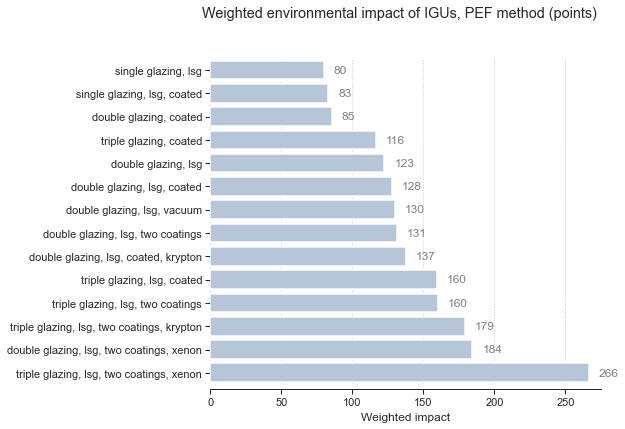

In [88]:
# Printing a barplot figure with the weighted results:
fig, ax = plt.subplots(figsize=(7, 6))

df_plot = df_weighted_igus.drop("smart glass, double glazing")

g = sns.barplot(data=df_plot,
                x="Weighted impact",
                y=df_plot.index,
                color="lightsteelblue", linewidth=1.5)

g.bar_label(g.containers[0], fmt="%.0f", padding=10, c='grey')

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 275)
plt.xticks(np.arange(0, 251, 50))

fig.suptitle('Weighted environmental impact of IGUs,'
             ' PEF method (points)', y=1)
sns.despine(left=True, offset=5)
plt.show()

# LCA of Curtain Wall Systems, from Cradle to Gate

In this section, the glazing units are integrated into curtain walls. The latter range from the classic mullion and transom system, to a unitised system (closed cavity façade, CCF) and a double skin façade (DSF). The scope of the LCA is still from cradle to gate, while an uncertainty analysis is conducted.

## Environmental Impact of Curtain Wall Systems

Selecting first the activities and defining the functional unit:

In [89]:
# List of market activities relating to the production of curtain walls:
inv_cw = [act for act in bw.Database("exldb_cw")
          if 'market for curtain wall' in act['name']
          # and 'xenon' not in act['name']
          # and 'air' not in act['name']
          ]

# 1 m² of façade:
fu_cw = [{cw: 1} for cw in inv_cw]

In [90]:
print("\033[1m", "List of the activities assessed:", "\033[0m")

for fu in fu_cw:
    for key, value in fu.items():
        print(key["name"])

 List of the activities assessed: 
market for curtain wall, double glazing, two coatings, high perf alu frame
market for curtain wall, ccf
market for curtain wall, smart glazing, high perf alu frame
market for curtain wall, triple glazing, two coatings, high perf alu frame
market for curtain wall, triple glazing, two coatings, krypton, high perf alu frame
market for curtain wall, double glazing, coated, high perf alu frame
market for curtain wall, double glazing, coated, krypton, high perf alu frame
market for curtain wall, double glazing, low perf alu frame
market for curtain wall, triple glazing, coated, high perf alu frame
market for curtain wall, single glazing, coated, low perf alu frame
market for curtain wall, vacuum double glazing, coated, high perf alu frame
market for curtain wall, single glazing, low perf alu frame
market for curtain wall, double skin facade
market for curtain wall, triple glazing, two coatings, xenon, high perf alu frame


Conducting the LCIA:

In [91]:
impact_cw = []

for cw in inv_cw:
    lca = bw.LCA({cw: 1})
    lca.lci()
    for method in ls_method_full:
        lca.switch_method(method)
        lca.lcia()
        impact_cw.append((cw["name"], cw["location"],
                          method[1], method[2], lca.score,
                          bw.methods.get(method).get('unit')))

Organising the results in a DataFrame:

In [92]:
# Creating the DataFrame:
df_impact_cw = pd.DataFrame(
    impact_cw,
    columns=["Name", "Location", "Category", "Subcategory", "Score", "Unit"]
)

# Reorganising it:
df_impact_cw = pd.pivot_table(
    df_impact_cw, index=["Name"],
    columns=["Category", "Subcategory", "Unit"], values="Score"
)

# Sorting the values:
df_impact_cw = df_impact_cw.sort_values(
    ("climate change", "climate change total", "kg CO2-Eq"), ascending=True
)

# Simplifying the index:
df_impact_cw.index = (df_impact_cw.index
                      .str.replace('market for curtain wall, ', '')
                      )

In [93]:
with pd.option_context("display.max_rows", None,
                       "display.max_columns", None,
                       "display.float_format", '{:12.2e}'.format):
    display(df_impact_cw)

Category                                                 climate change  \
Subcategory                                        climate change total   
Unit                                                          kg CO2-Eq   
Name                                                                      
single glazing, low perf alu frame                             1.32e+02   
single glazing, coated, low perf alu frame                     1.33e+02   
double glazing, low perf alu frame                             1.59e+02   
double glazing, coated, high perf alu frame                    1.63e+02   
double glazing, two coatings, high perf alu frame              1.64e+02   
vacuum double glazing, coated, high perf alu frame             1.65e+02   
double glazing, coated, krypton, high perf alu ...             1.68e+02   
triple glazing, two coatings, high perf alu frame              1.88e+02   
triple glazing, coated, high perf alu frame                    1.88e+02   
triple glazing, two coatings, krypton, high per...             1.98e+02   
triple glazing, two coatings, xenon, high perf ...             2.25e+02   
double skin facade                                             2.89e+02   
ccf                                                            4.35e+02   
smart glazing, high perf alu frame                             7.74e+02   

Category                                                                  ecosystem quality  \
Subcategory                                        freshwater and terrestrial acidification   
Unit                                                                              mol H+-Eq   
Name                                                                                          
single glazing, low perf alu frame                                                 9.13e-01   
single glazing, coated, low perf alu frame                                         9.20e-01   
double glazing, low perf alu frame                                                 1.12e+00   
double glazing, coated, high perf alu frame                                        1.15e+00   
double glazing, two coatings, high perf alu frame                                  1.15e+00   
vacuum double glazing, coated, high perf alu frame                                 1.15e+00   
double glazing, coated, krypton, high perf alu ...                                 1.17e+00   
triple glazing, two coatings, high perf alu frame                                  1.34e+00   
triple glazing, coated, high perf alu frame                                        1.34e+00   
triple glazing, two coatings, krypton, high per...                                 1.39e+00   
triple glazing, two coatings, xenon, high perf ...                                 1.54e+00   
double skin facade                                                                 2.04e+00   
ccf                                                                                3.06e+00   
smart glazing, high perf alu frame                                                 3.88e+00   

Category                                                                   \
Subcategory                                        freshwater ecotoxicity   
Unit                                                                  CTU   
Name                                                                        
single glazing, low perf alu frame                               1.98e+02   
single glazing, coated, low perf alu frame                       1.99e+02   
double glazing, low perf alu frame                               2.14e+02   
double glazing, coated, high perf alu frame                      2.18e+02   
double glazing, two coatings, high perf alu frame                2.19e+02   
vacuum double glazing, coated, high perf alu frame               2.15e+02   
double glazing, coated, krypton, high perf alu ...               2.20e+02   
triple glazing, two coatings, high perf alu frame                2.40e+02   
triple glazing

In [94]:
# Simplifying again the index to print the graph as clearly as possible:
df_impact_cw.index = (df_impact_cw.index
                      .str.replace(', high perf alu frame', '')
                      .str.replace(', low perf alu frame', '')
                      )

Normalising the results according to the highest value:

In [95]:
# With each curtain wall system:
df_norm_impact_cw = df_impact_cw / df_impact_cw.max()

In [96]:
# ... and without the smart double glazing:
df_norm_impact_cw_wo_smartg = (
    df_impact_cw.drop("smart glazing", axis=0) /
    df_impact_cw.drop("smart glazing", axis=0).max()
)

Printing a heatmap with the normalised results (1 = maximum impact):

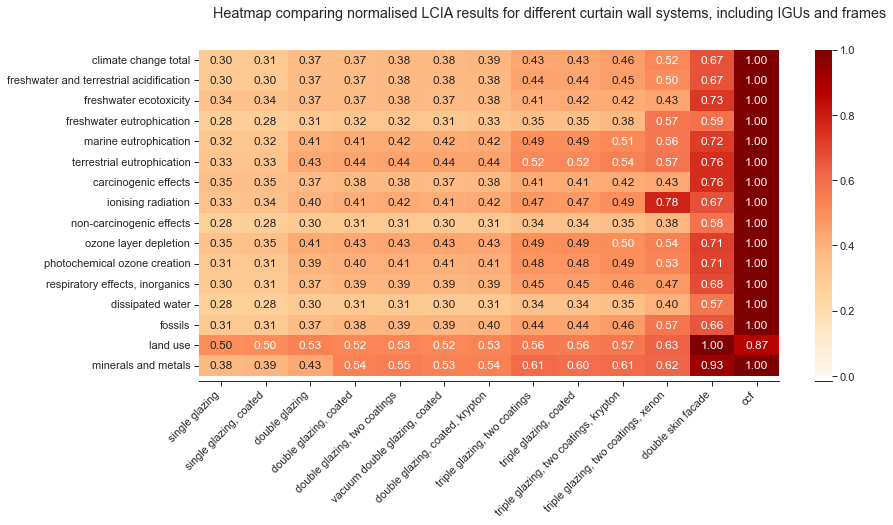

In [97]:
fig, ax = plt.subplots(figsize=(13, 6))

y_axis_labels = []
for label in df_norm_impact_cw_wo_smartg.columns:
    y_axis_labels.append(label[1])

df_plot = df_norm_impact_cw_wo_smartg.T

ax = sns.heatmap(df_plot, cmap="OrRd", vmin=0, vmax=1, annot=True, fmt='.2f',
                 yticklabels=y_axis_labels)

ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)

fig.suptitle('Heatmap comparing normalised LCIA results'
             ' for different curtain wall systems, including IGUs and frames'
             )

sns.despine(left=True, offset=5)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

plt.show()

Printing the full LCIA results:

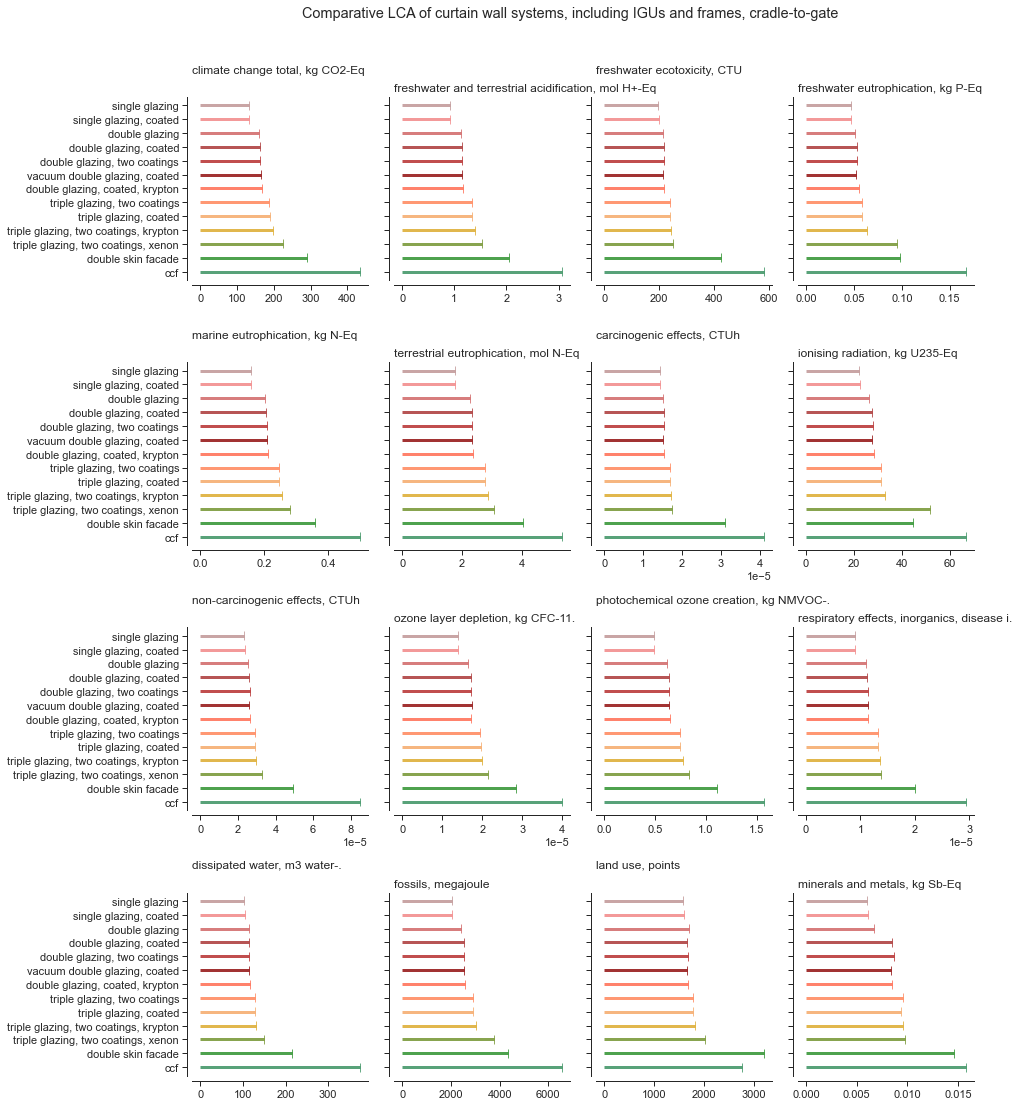

In [98]:
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(14, 18))

df_plot = df_impact_cw.drop("smart glazing")

c = ["rosybrown", "lightcoral", "indianred",
     "brown", "firebrick", "darkred",
     "tomato", "coral", "sandybrown",
     "goldenrod", "olivedrab", "forestgreen",
     "seagreen"
     ]

n = 0

for row in range(4):
    for col in range(4):
        col_name = df_plot.columns[n]
        ax = axes[row][col]

        ax.hlines(y=df_plot.index, xmin=0, xmax=df_plot[col_name],
                  linewidth=3, colors=c, alpha=0.8)

        sns.scatterplot(y=df_plot.index, x=df_plot[col_name],
                        hue=df_plot.index, s=80, marker="|",
                        palette=c, ax=ax)

        if (n % 2) == 0:
            ax.set_title(f"{col_name[1]}, {col_name[2]}", y=1.1, x=0,
                         ha='left', multialignment='left')
        else:
            ax.set_title(f"{col_name[1]}, {col_name[2]}", y=1, x=0,
                         ha='left', multialignment='left')

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        ax.get_legend().remove()

        n += 1

fig.subplots_adjust(wspace=0.15, hspace=0.45)

fig.suptitle('Comparative LCA of curtain wall systems, '
             'including IGUs and frames, cradle-to-gate',
             y=0.95
             )

sns.despine(offset=5)
plt.show()

**Weighted environmental impact:**

Comparing different types of curatin wall systems according to a single indicator calculated using PEF weighting factors:

In [99]:
# Dropping the unit row index to ease the calculation:
df_weighted_cw = df_impact_cw.copy()
df_weighted_cw.columns = df_weighted_cw.columns.droplevel(2)

# Defining a new DataFrame with the weighted values,
# i.e., multiplication of the impacts by df_weighting:
df_weighted_cw = pd.DataFrame(
    (df_weighted_cw.multiply(
        df_weighting["Weighting factor"].T, axis=1) / 100
     ).sum(axis=1), columns=['Weighted impact']
)

df_weighted_cw = df_weighted_cw.sort_values("Weighted impact",
                                            ascending=True
                                            )

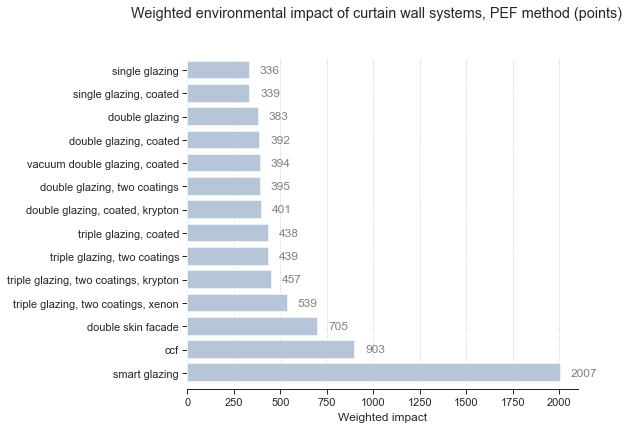

In [100]:
# Printing a barplot figure with the weighted results:
fig, ax = plt.subplots(figsize=(7, 6))

g = sns.barplot(data=df_weighted_cw,
                x="Weighted impact",
                y=df_weighted_cw.index,
                color="lightsteelblue", linewidth=1.5)

g.bar_label(g.containers[0], fmt="%.0f", padding=10, c='grey')

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 2100)
plt.xticks(np.arange(0, 2001, 250))

fig.suptitle('Weighted environmental impact of curtain wall systems,'
             ' PEF method (points)', y=1)
sns.despine(left=True, offset=5)
plt.show()

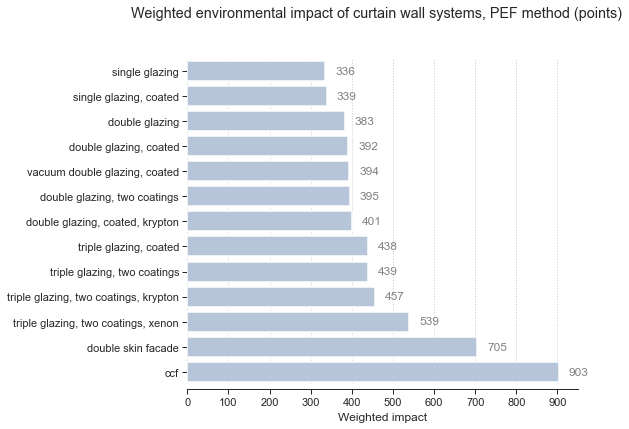

In [101]:
# Printing a barplot figure with the weighted results:
fig, ax = plt.subplots(figsize=(7, 6))

df_plot = df_weighted_cw.drop("smart glazing")

g = sns.barplot(data=df_plot,
                x="Weighted impact",
                y=df_plot.index,
                color="lightsteelblue", linewidth=1.5)

g.bar_label(g.containers[0], fmt="%.0f", padding=10, c='grey')

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 950)
plt.xticks(np.arange(0, 901, 100))

fig.suptitle('Weighted environmental impact of curtain wall systems,'
             ' PEF method (points)', y=1)
sns.despine(left=True, offset=5)
plt.show()

**Contribution analysis: considering the share of glazing in the climate change potential of the curtain walls:**

Creating a new DataFrame with the results specific to the climate change potential:

In [102]:
# Data relating to the impact of IGUs:
df_contribution_igu = (
    df_impact_igus["climate change", "climate change total"].copy()
)

for igu in df_contribution_igu.index:
    if "lsg" not in igu:
        df_contribution_igu = df_contribution_igu.drop(igu)

df_contribution_igu.index = (df_contribution_igu.index
                             .str.replace(", lsg", "")
                             .str.replace("double glazing, vacuum",
                                          "vacuum double glazing, coated")
                             .str.replace("", "")
                             )

df_contribution_igu.columns = pd.MultiIndex.from_tuples(
    [("IGU", "kg CO2-Eq")], names=['Scope', 'Unit']
)

In [103]:
# Data relating to the impact of curtain walls:
df_cw_gwp = df_impact_cw["climate change", "climate change total"].copy()

df_cw_gwp.columns = pd.MultiIndex.from_tuples(
    [("CW", "kg CO2-Eq")], names=['Scope', 'Unit']
)

In [104]:
# Merging the two DataFrames in a new one:
df_contribution_gwp = pd.concat([df_cw_gwp, df_contribution_igu], axis=1)

df_contribution_gwp[("IGU", "kg CO2-Eq")]["double skin facade"] = (
    df_contribution_gwp[("IGU", "kg CO2-Eq")]["single glazing, coated"]
    + df_contribution_gwp[("IGU", "kg CO2-Eq")]["double glazing, coated"]
)

df_contribution_gwp[("IGU", "kg CO2-Eq")]["ccf"] = (
    df_contribution_gwp[("IGU", "kg CO2-Eq")]["single glazing, coated"]
    + df_contribution_gwp[("IGU", "kg CO2-Eq")]["double glazing, coated"]
)

df_contribution_gwp = df_contribution_gwp.drop(
    ["double glazing, two coatings, xenon", "smart glazing"]
)

Displaying the climate change impact of the different curtain wall configurations, with the share relating to glazing production:

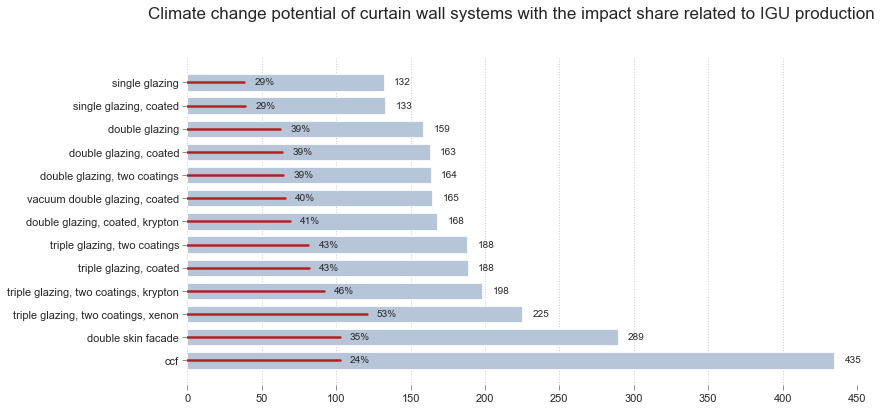

In [105]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(x=df_contribution_gwp[("CW", "kg CO2-Eq")],
            y=df_contribution_gwp.index,
            color="lightsteelblue", ax=ax
            )

ls_plot = df_contribution_gwp.index

# Plot an indicator line for IGU contribution:
for ix, a in enumerate(ax.patches):
    y_start = a.get_y()
    height = a.get_height()

    x1 = (df_contribution_gwp[("IGU", "kg CO2-Eq")]
          .loc[ls_plot[ix]]
          )

    ax.plot([0, x1],
            [y_start+height/2, y_start+height/2],
            '-', c='firebrick', linewidth=2.5)

    ax.set(xlim=(0, 450), ylabel="", xlabel="kg CO2-Eq.")

    # Write total impact:
    x_text = (df_contribution_gwp[("CW", "kg CO2-Eq")]
              .loc[ls_plot[ix]]
              )
    y_text = y_start+(height/2)

    s = str("%.0f" % (df_contribution_gwp[("CW", "kg CO2-Eq")]
                      .loc[ls_plot[ix]])
            )

    ax.text(x_text+7, y_text+0.1, s, fontsize=10)

    # Write IGU contribution:
    x_text_igu = (df_contribution_gwp[("IGU", "kg CO2-Eq")]
                  .loc[ls_plot[ix]]
                  )
    y_text_igu = y_start+(height/2)

    s_igu = str("%.0f" % (df_contribution_gwp[("IGU", "kg CO2-Eq")]
                          .loc[ls_plot[ix]]
                          / df_contribution_gwp[("CW", "kg CO2-Eq")]
                          .loc[ls_plot[ix]] * 100
                          ) + "%"
                )

    ax.text(x_text_igu+7, y_text_igu+0.1, s_igu, fontsize=10)

ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

style_ax(ax)

# Adjust the width of the bars:
for patch in ax.patches:
    value = 0.7
    current_height = patch.get_height()
    diff = current_height - value
    patch.set_height(value)
    # recenter the bar:
    patch.set_y(patch.get_y() + diff*0.5)

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle("Climate change potential of curtain wall systems"
             " with the impact share related to IGU production",
             fontsize=17, y=1)
sns.despine(left=True, bottom=True, offset=5)
plt.show()

The same contribution analysis but for the other indicators:

In [106]:
# Selecting the indicator within the column index:
i = 15

# Defining the index for displaying the chart below:
i_1 = df_impact_cw.columns[i][0]
i_2 = df_impact_cw.columns[i][1]
i_3 = df_impact_cw.columns[i][2]

print(i_1, ", ", i_2, ", ", i_3)

resources ,  minerals and metals ,  kg Sb-Eq


In [107]:
# Data relating to the impact of IGUs:
df_contribution_igu = (
    df_impact_igus[i_1, i_2].copy()
)

for igu in df_contribution_igu.index:
    if "lsg" not in igu:
        df_contribution_igu = df_contribution_igu.drop(igu)

df_contribution_igu.index = (df_contribution_igu.index
                             .str.replace(", lsg", "")
                             .str.replace("double glazing, vacuum",
                                          "vacuum double glazing, coated")
                             .str.replace("", "")
                             )

df_contribution_igu.columns = pd.MultiIndex.from_tuples(
    [("IGU", i_3)], names=['Scope', 'Unit']
)

# Data relating to the impact of curtain walls:
df_contribution_cw = df_impact_cw[i_1, i_2].copy()

df_contribution_cw.columns = pd.MultiIndex.from_tuples(
    [("CW", i_3)], names=['Scope', 'Unit']
)

# Merging the two DataFrames in a new one:
df_contribution = pd.concat([df_contribution_cw, df_contribution_igu],
                            axis=1
                            )

df_contribution[("IGU", i_3)]["double skin facade"] = (
    df_contribution[("IGU", i_3)]["single glazing, coated"]
    + df_contribution[("IGU", i_3)]["double glazing, coated"]
)

df_contribution[("IGU", i_3)]["ccf"] = (
    df_contribution[("IGU", i_3)]["single glazing, coated"]
    + df_contribution[("IGU", i_3)]["double glazing, coated"]
)

df_contribution = df_contribution.drop(
    ["double glazing, two coatings, xenon", "smart glazing"]
)

Displaying the climate change impact of the different curtain wall configurations, with the share relating to glazing production:

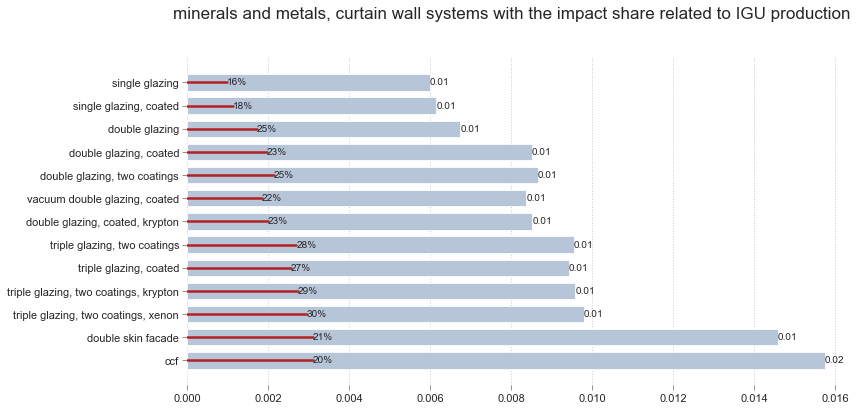

In [108]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(x=df_contribution[("CW", i_3)],
            y=df_contribution.index,
            color="lightsteelblue", ax=ax
            )

ls_plot = df_contribution.index

# Plot an indicator line for IGU contribution:
for ix, a in enumerate(ax.patches):
    y_start = a.get_y()
    height = a.get_height()

    x1 = (df_contribution[("IGU", i_3)]
          .loc[ls_plot[ix]]
          )

    ax.plot([0, x1],
            [y_start+height/2, y_start+height/2],
            '-', c='firebrick', linewidth=2.5)

    ax.set(ylabel="", xlabel=i_3)
    ax.set_xlim(xmin=0)

    # Write total impact:
    x_text = (df_contribution[("CW", i_3)]
              .loc[ls_plot[ix]]
              )
    y_text = y_start+(height/2)

    s = str("%.2f" % (df_contribution[("CW", i_3)]
                      .loc[ls_plot[ix]])
            )

    ax.text(x_text, y_text+0.1, s, fontsize=10)

    # Write IGU contribution:
    x_text_igu = (df_contribution[("IGU", i_3)]
                  .loc[ls_plot[ix]]
                  )
    y_text_igu = y_start+(height/2)

    s_igu = str("%.0f" % (df_contribution[("IGU", i_3)]
                          .loc[ls_plot[ix]]
                          / df_contribution[("CW", i_3)]
                          .loc[ls_plot[ix]] * 100
                          ) + "%"
                )

    ax.text(x_text_igu, y_text_igu+0.1, s_igu, fontsize=10)

ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

style_ax(ax)

# Adjust the width of the bars:
for patch in ax.patches:
    value = 0.7
    current_height = patch.get_height()
    diff = current_height - value
    patch.set_height(value)
    # recenter the bar:
    patch.set_y(patch.get_y() + diff*0.5)

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle(f"{i_2}, curtain wall systems"
             " with the impact share related to IGU production",
             fontsize=17, y=1)
sns.despine(left=True, bottom=True, offset=5)
plt.show()

## Uncertainty Analysis through Monte Carlo Simulation

Defining the number of iterations:

In [109]:
n_runs = 500

### Monte Carlo Simulations, Single Activity and Single Indicator

Defining the activity:

In [110]:
act = "market for curtain wall, double glazing, coated, high perf alu frame"

for fu in fu_cw:
    for key, value in fu.items():
        if act in str(key):
            print(key)
            mc_fu = fu

'market for curtain wall, double glazing, coated, high perf alu frame' (square meter, BE, ('building components', 'windows'))


Conducting the Monte Carlo simulations for the ILCD climate change indicator:

In [111]:
mc = MonteCarloLCA(mc_fu, method_ilcd_gwp)
ls_mc_results = [next(mc) for n in range(n_runs)]

Analysing the results:

In [112]:
pd.DataFrame(ls_mc_results).describe()

,0
count,500.000000
mean,179.740915
std,10.990472
min,156.762479
25%,172.984470
50%,178.394029
75%,185.392566
max,263.722335


Displaying a bar chart with the results:

market for curtain wall, double glazing, coated, high perf alu frame
1 m²


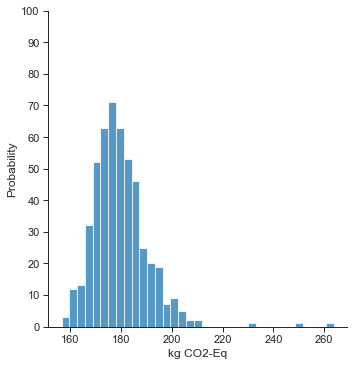

In [113]:
sns.displot(data=ls_mc_results)

plt.ylabel("Probability")
plt.xlabel(methods[method_ilcd_gwp]["unit"])

plt.yticks(np.arange(0, 101, 10))

for key, value in mc_fu.items():
    print(key["name"])
    print(value, "m²")

### Monte Carlo Simulations of Different IGUs

Defining a boolean value to conduct or not the Monte Carlo Simulations. According to run number, it can take a some time. If False is chosen, data from the csv file are retrived (if the file exists):

In [114]:
mc_bool = False

Checking which activity and method is analysed here:

In [115]:
mc_fu

{'market for curtain wall, double glazing, coated, high perf alu frame' (square meter, BE, ('building components', 'windows')): 1}

In [116]:
mc = MonteCarloLCA(mc_fu, ls_method_full[0])
# method_ilcd_gwp
# ls_method_small
# ls_method_full

In [117]:
ls_method_full[0]

('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total')

Conducting the Monte Carlo simulations using the ILCD midpoint method for climate change potential:

In [118]:
if mc_bool:

    simulations = []
    ls_col = []

    for n in range(n_runs):
        next(mc)
        ls_mcresults = []
        for fu in fu_cw:
            mc.redo_lcia(fu)
            ls_mcresults.append(mc.score)

        simulations.append(ls_mcresults)

    for fu in fu_cw:
        a = [label for label, q in fu.items()]
        ls_col.append(a[0]["name"])

    df_mc_result_gwp = pd.DataFrame(simulations, columns=ls_col)

    df_mc_result_gwp.to_csv('outputs\lca\mc_results_cw_gwp.csv')

else:
    # Retrieve the DataFrame from results already saved in csv file:
    if os.path.isfile('outputs\lca\mc_results_cw_gwp.csv'):
        df_mc_result_gwp_csv = (
            pd.read_csv('outputs\lca\mc_results_cw_gwp.csv'))

        df_mc_result_gwp_csv = df_mc_result_gwp_csv.rename(
            columns={"Unnamed: 0": "Iteration"}
        ).set_index("Iteration")

        df_mc_result_gwp = df_mc_result_gwp_csv
        print("MonteCarlo simulation data retrieved from the csv file!")

    else:
        print("MonteCarlo DataFrame is empty!")

MonteCarlo simulation data retrieved from the csv file!


Conducting the Monte Carlo simulations using the ILCD midpoint method for ozone layer depletion potential:

In [119]:
mc = MonteCarloLCA(mc_fu, ls_method_full[9])
# method_ilcd_gwp
# ls_method_small
# ls_method_full

In [120]:
ls_method_full[9]

('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion')

In [121]:
if mc_bool:

    simulations = []
    ls_col = []

    for n in range(n_runs):
        next(mc)
        ls_mcresults = []
        for fu in fu_cw:
            mc.redo_lcia(fu)
            ls_mcresults.append(mc.score)

        simulations.append(ls_mcresults)

    for fu in fu_cw:
        a = [label for label, q in fu.items()]
        ls_col.append(a[0]["name"])

    df_mc_result_odp = pd.DataFrame(simulations, columns=ls_col)

    df_mc_result_odp.to_csv('outputs\lca\mc_results_cw_odp.csv')

else:
    # Retrieve the DataFrame from results already saved in csv file:
    if os.path.isfile('outputs\lca\mc_results_cw_odp.csv'):
        df_mc_result_odp_csv = (
            pd.read_csv('outputs\lca\mc_results_cw_odp.csv'))

        df_mc_result_odp_csv = df_mc_result_odp_csv.rename(
            columns={"Unnamed: 0": "Iteration"}
        ).set_index("Iteration")

        df_mc_result_odp = df_mc_result_odp_csv
        print("MonteCarlo simulation data retrieved from the csv file!")

    else:
        print("MonteCarlo DataFrame is empty!")

MonteCarlo simulation data retrieved from the csv file!


In [122]:
# Simplifying the column names:
df_mc_result_gwp.columns = (df_mc_result_gwp.columns
                            .str.replace('market for curtain wall, ', '')
                            )

df_mc_result_odp.columns = (df_mc_result_odp.columns
                            .str.replace('market for curtain wall, ', '')
                            )

**Describing the results relating to ozone layer depletion potential:**

In [123]:
with pd.option_context("display.max_rows", None,
                       "display.max_columns", None,
                       "display.float_format", '{:5.2e}'.format):
    display(df_mc_result_odp.describe().T
            .sort_values("mean", ascending=True)
           )


,count,mean,std,min,25%,50%,75%,max
"single glazing, low perf alu frame",5.00e+02,1.79e-05,4.48e-06,1.12e-05,1.51e-05,1.70e-05,1.95e-05,4.95e-05
"single glazing, coated, low perf alu frame",5.00e+02,1.80e-05,4.51e-06,1.13e-05,1.52e-05,1.71e-05,1.96e-05,4.98e-05
"double glazing, low perf alu frame",5.00e+02,2.11e-05,4.93e-06,1.33e-05,1.79e-05,2.02e-05,2.31e-05,5.53e-05
"double glazing, coated, high perf alu frame",5.00e+02,2.22e-05,5.70e-06,1.33e-05,1.85e-05,2.12e-05,2.42e-05,6.42e-05
"double glazing, two coatings, high perf alu frame",5.00e+02,2.23e-05,5.72e-06,1.33e-05,1.86e-05,2.13e-05,2.43e-05,6.45e-05
"double glazing, coated, krypton, high perf alu frame",5.00e+02,2.24e-05,5.75e-06,1.34e-05,1.87e-05,2.15e-05,2.45e-05,6.49e-05
"vacuum double glazing, coated, high perf alu frame",5.00e+02,2.24e-05,5.68e-06,1.35e-05,1.88e-05,2.15e-05,2.45e-05,6.42e-05
"triple glazing, two coatings, high perf alu frame",5.00e+02,2.51e-05,6.18e-06,1.51e-05,2.11e-05,2.41e-05,2.76e-05,6.96e-05
"triple glazing, coated, high perf alu frame",5.00e+02,2.54e-05,6.33e-06,1.52e-05,2.13e-05,2.42e-05,2.78e-05,7.19e-05
"triple glazing, two coatings, krypton, high perf alu frame",5.00e+02,2.55e-05,6.28e-06,1.53e-05,2.15e-05,2.45e-05,2.81e-05,7.09e-05


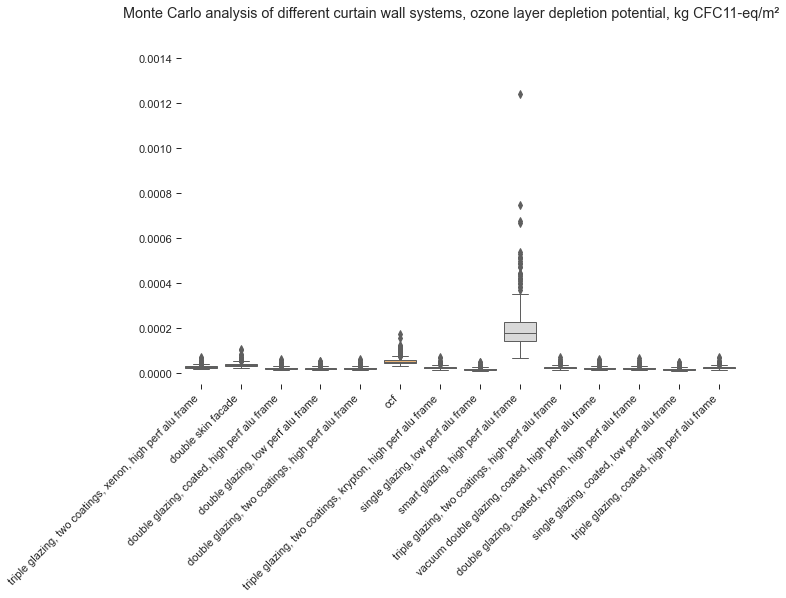

In [124]:
fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.boxplot(data=df_mc_result_odp, palette="Set3")

ax.set(ylabel="", xlabel="")
plt.yticks(np.arange(0, 0.0015, 0.0002))

sns.despine(left=True, bottom=True, offset=5)

fig.suptitle(
    'Monte Carlo analysis of different curtain wall systems, '
    'ozone layer depletion potential, kg CFC11-eq/m²', y=1
)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

Displaying the same graph, but without the curtain wall with smart glazing:

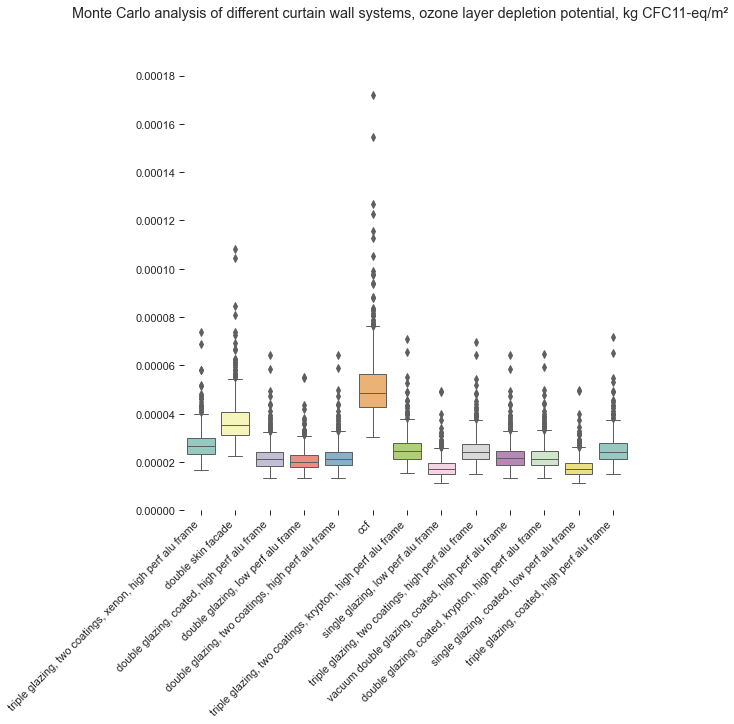

In [125]:
fig, ax = plt.subplots(figsize=(8, 8))

ax = sns.boxplot(
    data=df_mc_result_odp[
        [x for x in df_mc_result_odp.columns if 'smart glazing' not in x]
    ], palette="Set3"
)

ax.set(ylabel="", xlabel="")
plt.yticks(np.arange(0, 0.0002, 0.00002))

sns.despine(left=True, bottom=True, offset=5)

fig.suptitle(
    'Monte Carlo analysis of different curtain wall systems, '
    'ozone layer depletion potential, kg CFC11-eq/m²', y=1
)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

**Describing the results relating to climate change potential:**

In [126]:
df_mc_result_gwp.describe().round(1).T.sort_values("mean", ascending=True)

,count,mean,std,min,25%,50%,75%,max
"single glazing, low perf alu frame",500.0,146.4,10.1,124.5,140.2,144.9,150.8,225.5
"single glazing, coated, low perf alu frame",500.0,147.4,10.1,125.5,141.2,145.9,151.9,226.4
"double glazing, low perf alu frame",500.0,174.6,10.5,151.6,168.1,173.1,179.4,253.4
"double glazing, coated, high perf alu frame",500.0,179.5,10.6,156.4,173.1,178.0,184.5,257.7
"double glazing, two coatings, high perf alu frame",500.0,180.4,10.6,157.4,174.0,178.8,185.6,258.5
"vacuum double glazing, coated, high perf alu frame",500.0,181.2,10.6,158.0,174.8,179.7,186.4,259.4
"double glazing, coated, krypton, high perf alu frame",500.0,184.8,10.7,160.9,178.2,183.2,189.8,263.5
"triple glazing, two coatings, high perf alu frame",500.0,206.5,11.1,182.3,199.8,204.8,212.1,284.1
"triple glazing, coated, high perf alu frame",500.0,206.7,11.1,182.3,200.0,205.2,212.2,284.4
"triple glazing, two coatings, krypton, high perf alu frame",500.0,217.1,11.4,191.3,209.9,215.4,222.6,295.9


Displaying a boxplot graph with the results of the Monte Carlo analysis:

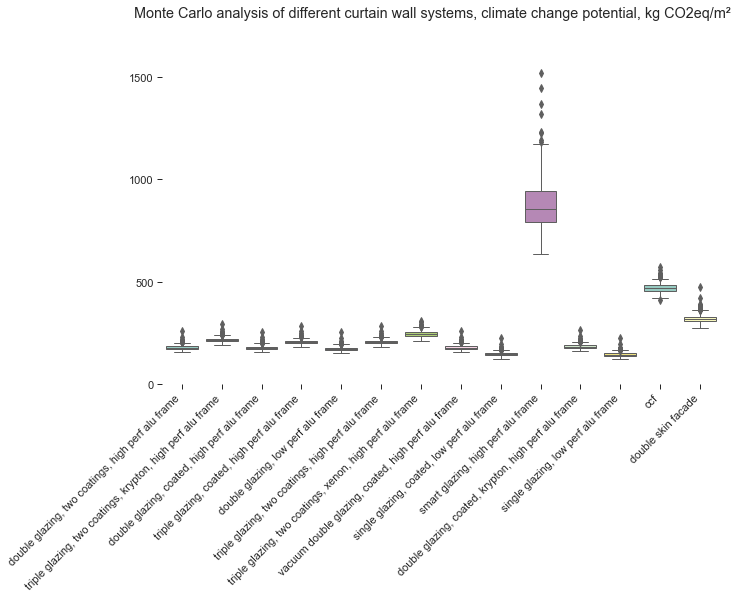

In [127]:
fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.boxplot(data=df_mc_result_gwp, palette="Set3")

ax.set(ylabel="", xlabel="")
plt.yticks(np.arange(0, 1501, 500))

sns.despine(left=True, bottom=True, offset=5)

fig.suptitle(
    'Monte Carlo analysis of different curtain wall systems, '
    'climate change potential, kg CO2eq/m²', y=1
)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

Displaying the same graph, but without the curtain wall with smart glazing:

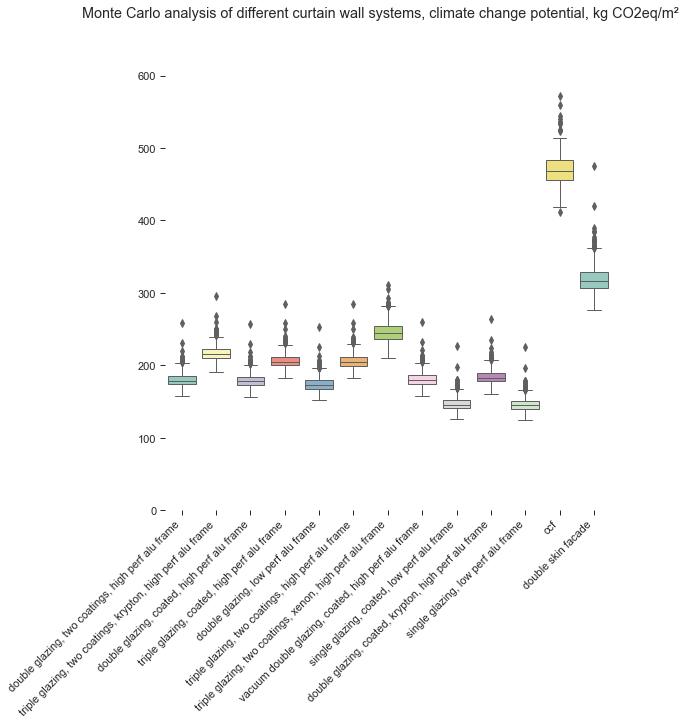

In [128]:
fig, ax = plt.subplots(figsize=(8, 8))

ax = sns.boxplot(
    data=df_mc_result_gwp[
        [x for x in df_mc_result_gwp.columns if 'smart glazing' not in x]
    ], palette="Set3"
)

ax.set(ylabel="", xlabel="")
plt.yticks(np.arange(0, 601, 100))

sns.despine(left=True, bottom=True, offset=5)

fig.suptitle(
    'Monte Carlo analysis of different curtain wall systems, '
    'climate change potential, kg CO2eq/m²', y=1
)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

Displaying a boxplot graph, but only for curtain wall systems with double glazing:

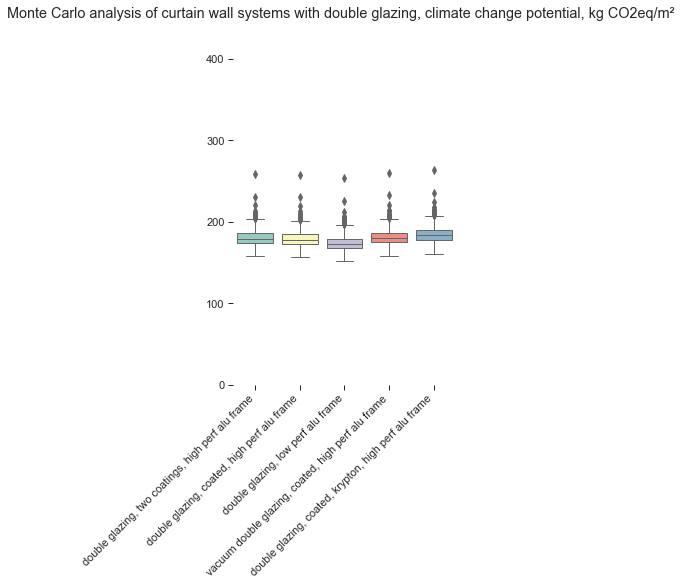

In [129]:
fig, ax = plt.subplots(figsize=(4, 6))

ax = sns.boxplot(
    data=df_mc_result_gwp[
        [x for x in df_mc_result_gwp.columns if 'double glazing' in x]
    ], palette="Set3"
)

ax.set(ylabel="", xlabel="")
plt.yticks(np.arange(0, 401, 100))

sns.despine(left=True, bottom=True, offset=5)

fig.suptitle(
    'Monte Carlo analysis of curtain wall systems with double glazing, '
    'climate change potential, kg CO2eq/m²', y=1
)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

Displaying a boxplot graph, but only for curtain wall systems with triple glazing:

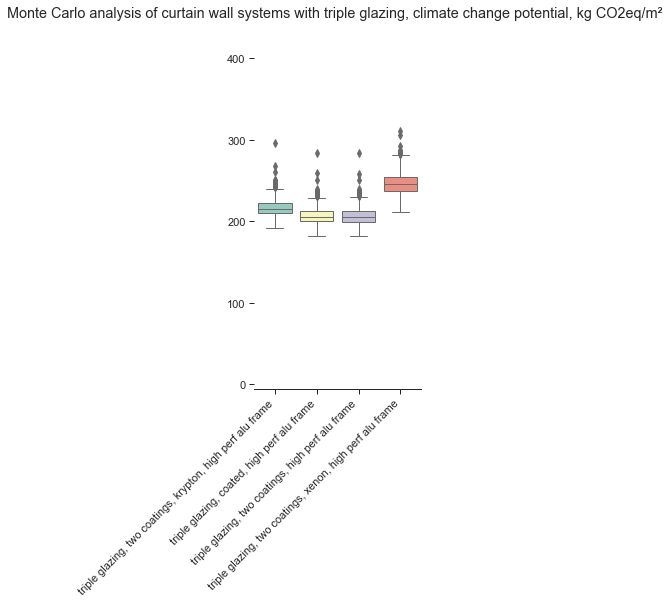

In [130]:
fig, ax = plt.subplots(figsize=(3, 6))

ax = sns.boxplot(
    data=df_mc_result_gwp[
        [x for x in df_mc_result_gwp.columns if 'triple glazing' in x]
    ], palette="Set3"
)

ax.set(ylabel="", xlabel="")
plt.yticks(np.arange(0, 401, 100))

sns.despine(left=True, offset=5)

fig.suptitle(
    'Monte Carlo analysis of curtain wall systems with triple glazing, '
    'climate change potential, kg CO2eq/m²', y=1
)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

### Monte Carlo Analysis for Multiple Impact Categories

Extending the Monte Carlo analysis to all impact categories defined by the ILCD midpoint method:

In [131]:
# Defining a function to conduct the MC simulations:
def multiImpactMonteCarloLCA(fu, ls_methods, nruns):

    mc_lca = bw.MonteCarloLCA(fu)
    mc_lca.lci()

    c_matrices = {}

    for method in ls_methods:
        mc_lca.switch_method(method)
        c_matrices[method] = mc_lca.characterization_matrix

    results = np.empty((len(ls_methods), nruns))

    for iteration in range(nruns):
        next(mc_lca)
        for method_index, method in enumerate(ls_methods):
            results[method_index, iteration] = (
                c_matrices[method]*mc_lca.inventory).sum()

    return results

In [132]:
act_mc_multi_impact = (
    "market for curtain wall, double glazing, coated, high perf alu frame"
)

for fu in fu_cw:
    for key, value in fu.items():
        if act_mc_multi_impact in str(key):
            print(key["name"])
            mc_multi_impact_fu = fu

market for curtain wall, double glazing, coated, high perf alu frame


In [183]:
if mc_bool:
    mc_results = multiImpactMonteCarloLCA(mc_multi_impact_fu,
                                          ls_method_full,
                                          n_runs
                                          )

    df_multiimpact_mc_results = pd.DataFrame(data=mc_results,
                                             index=ls_method_full).T

    df_multiimpact_mc_results.index.name = 'Iteration'

    df_multiimpact_mc_results.columns = pd.MultiIndex.from_tuples(
        df_multiimpact_mc_results.columns, names=['Method',
                                                  'Category',
                                                  'Subcategory']
    )

    df_multiimpact_mc_results.unstack().to_csv(
        'outputs\lca\multiimpact_mc_results.csv', index=True
    )

else:
    if os.path.isfile('outputs\lca\multiimpact_mc_results.csv'):
        df_multiimpact_mc_results_csv = (
            pd.read_csv('outputs\lca\multiimpact_mc_results.csv'))
        df_multiimpact_mc_results_csv = (df_multiimpact_mc_results_csv
                                         .pivot_table(
                                             values='0',
                                             index=['Iteration'],
                                             columns=['Method',
                                                      'Category',
                                                      'Subcategory']
                                         )
                                        )

        df_multiimpact_mc_results=df_multiimpact_mc_results_csv
        print("MonteCarlo simulation data retrieved from the csv file!")

    else:
        print("MonteCarlo DataFrame is empty!")

MonteCarlo simulation data retrieved from the csv file!


In [184]:
df_multiimpact_mc_results["ILCD 2.0 2018 midpoint"].describe()

Category          climate change                        ecosystem quality  \
Subcategory climate change total freshwater and terrestrial acidification   
count                 500.000000                               500.000000   
mean                  180.665298                                 1.314063   
std                    13.160955                                 0.146774   
min                   157.456091                                 1.102577   
25%                   172.692889                                 1.237769   
50%                   178.175264                                 1.285611   
75%                   186.144632                                 1.362071   
max                   260.857280                                 2.559534   

Category                                                      \
Subcategory freshwater ecotoxicity freshwater eutrophication   
count                   500.000000                500.000000   
mean                    356.031996                  0.084871   
std                     169.313926                  0.041192   
min                     121.584606                  0.027950   
25%                     253.840371                  0.057062   
50%                     315.575981                  0.077361   
75%                     417.389647                  0.100987   
max                    2011.702977                  0.470734   

Category                                                      \
Subcategory marine eutrophication terrestrial eutrophication   
count                  500.000000                 500.000000   
mean                     0.240242                   2.779079   
std                      0.021753                   0.464603   
min                      0.199284                   2.161629   
25%                      0.226618                   2.522465   
50%                      0.236272                   2.678137   
75%                      0.248227                   2.889208   
max                      0.373178                   7.247018   

Category            human health                                              \
Subcategory carcinogenic effects ionising radiation non-carcinogenic effects   
count                 500.000000         500.000000               500.000000   
mean                    0.000024          56.159393                 0.000048   
std                     0.000015          85.054680                 0.000289   
min                    -0.000009           9.666992                -0.002101   
25%                     0.000015          22.809139                -0.000095   
50%                     0.000021          33.489296                 0.000026   
75%                     0.000030          57.982761                 0.000192   
max                     0.000171        1173.497234                 0.001321   

Category                                                        \
Subcategory ozone layer depletion photochemical ozone creation   
count                  500.000000                   500.000000   
mean                     0.000022                     0.755332   
std                      0.000005                     0.070990   
min                      0.000014                     0.605114   
25%                      0.000019                     0.710786   
50%                      0.000021                     0.741787   
75%                      0.000025                     0.781166   
max                      0.000057                     1.160771   

Category                                           resources               \
Subcategory respiratory effects, inorganics dissipated water      fossils   
count                            500.000000       500.000000   500.000000   
mean                               0.000014       123.469831  2897.843545   
std                                0.000003        10.557754   290.237756   
min                                0.000010        99.097128  2276.397366   
25%                    

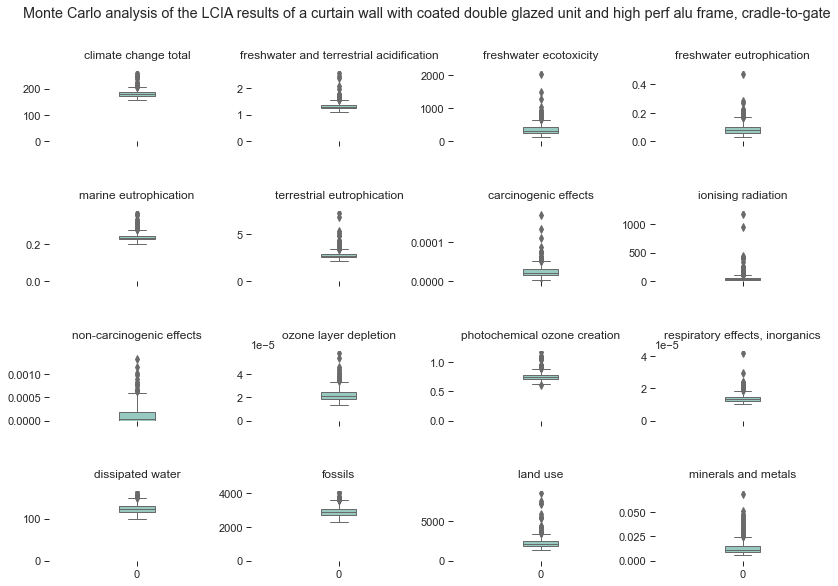

In [185]:
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=True, sharey=False,
                         figsize=(14, 9))

df_plot = df_multiimpact_mc_results['ILCD 2.0 2018 midpoint']

n = 0

for row in range(4):
    for col in range(4):
        ax = axes[row][col]
        i = df_plot.columns[n]
        sns.boxplot(data=df_plot[i], palette="Set3", width=0.2, ax=ax)

        n += 1

        ax.set(xlabel="", ylabel="")
        ax.set_ylim(ymin=0)
        ax.set_title(i[1], y=1.1)

fig.subplots_adjust(wspace=0.15, hspace=1)

fig.suptitle(
    'Monte Carlo analysis of the LCIA results of a curtain wall with '
    'coated double glazed unit and high perf alu frame, cradle-to-gate'
)
sns.despine(left=True, bottom=True, offset=5)
plt.show()

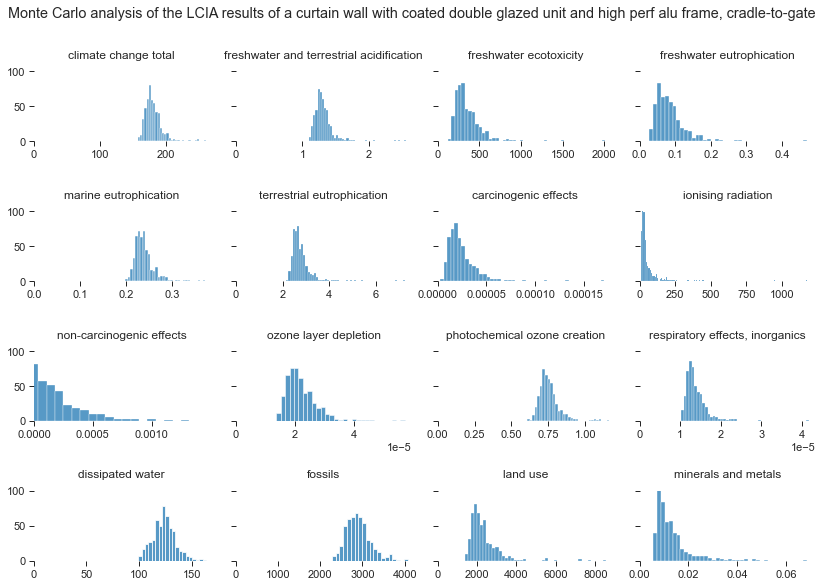

In [186]:
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(14, 9))

df_plot = df_multiimpact_mc_results['ILCD 2.0 2018 midpoint']

n = 0

for row in range(4):
    for col in range(4):
        ax = axes[row][col]
        i = df_plot.columns[n]
        sns.histplot(data=df_plot[i], ax=ax)

        n += 1

        ax.set(xlabel="", ylabel="")
        ax.set_ylim(ymin=0, ymax=100)
        ax.set_xlim(xmin=0)
        ax.set_title(i[1], y=1.1)

fig.subplots_adjust(wspace=0.15, hspace=1)

fig.suptitle(
    'Monte Carlo analysis of the LCIA results of a curtain wall with '
    'coated double glazed unit and high perf alu frame, cradle-to-gate'
)
sns.despine(left=True, bottom=True, offset=5)
plt.show()

# Import Results from the BEM

This section imports the results of the building energy modelling carried out on the case study concerning the replacement of the curtain wall of an office building in Brussels. The data on energy use serve to conduct the LCA on the use phase of the previously analysed facades.

For more information regarding the building energy modelling, see the notebook "01_BEM" in that same project folder.

## Function to Retrieve Data from the CSV Files Saved during Previous Simulations

In [187]:
# Open the df_end_use_allsteps from the csv file:
# Avoid re-running energy simulations (time consuming):
if os.path.isfile('outputs\steps_dir\df_end_use_allsteps.csv'):
    df_end_use_allsteps_csv = (
        pd.read_csv('outputs\steps_dir\df_end_use_allsteps.csv'))
    df_end_use_allsteps_csv = df_end_use_allsteps_csv.pivot_table(
        values='0', index=['EndUse'], columns=['Run name', 'FuelType'])

    df_end_use_allsteps = df_end_use_allsteps_csv

A function to retrieve the df_step dataframes saved as csv, i.e. DataFrame with the main assumptions and results (natural gas and electricity) specific to each simulation run:

To assess the indirect impact of glazing replacement on energy use in the building, the natural gas and electricity use results for each scenario are subtracted by the initial scenario, where the exact same glazing is kept. 

In [188]:
def retrieve_df_step(n_step, df_step):
    """
    If a df_step.csv exists, retrieve the data and create a dataframe
        wich replace the one currently in use in the notebook.
        Avoid re-running energy simulation (time consuming).

    Parameters
    ----------
    n_step: number of the step
    df_step: a dataframe. followed by a number (e.g. step4), 
    identify the step with simulation runs and main results

    Returns
    -------
    df_step: update with csv data or exactly the same as the one in the input

    """

    # Does the csv exist
    # and check if the existing df_step includes simulation results:
    if os.path.isfile(f"outputs\steps_dir\df_step"+str(n_step)+".csv"):
        df_step = (
            pd.read_csv(f"outputs\steps_dir\df_step"+str(n_step)+".csv")
            .set_index(['name']))

        print("df_step ", n_step, "updated with csv data")
    else:
        print("existing df_step ", n_step, "kept in place")

    return df_step

## Post-Process Data from the Building Energy Simulations

As a reminder: df_step units are MJ/m² of glazed façade for natural gas, and kWh/m² for electricity use.

In [189]:
df_step1 = retrieve_df_step(1, df_step1)
df_step1.name = "df_step1"
df_step2 = retrieve_df_step(2, df_step2)
df_step2.name = "df_step2"
df_step3 = retrieve_df_step(3, df_step3)
df_step3.name = "df_step3"
df_step4 = retrieve_df_step(4, df_step4)
df_step4.name = "df_step4"
df_step5 = retrieve_df_step(5, df_step5)
df_step5.name = "df_step5"
df_step6 = retrieve_df_step(6, df_step6)
df_step6.name = "df_step6"
df_step7 = retrieve_df_step(7, df_step7)
df_step7.name = "df_step7"
df_step8 = retrieve_df_step(8, df_step8)
df_step8.name = "df_step8"
df_step9 = retrieve_df_step(9, df_step9)
df_step9.name = "df_step9"
df_step10 = retrieve_df_step(10, df_step10)
df_step10.name = "df_step10"
df_step11 = retrieve_df_step(11, df_step11)
df_step11.name = "df_step11"
df_step12 = retrieve_df_step(12, df_step12)
df_step12.name = "df_step12"
df_step13 = retrieve_df_step(13, df_step13)
df_step13.name = "df_step13"
df_step14 = retrieve_df_step(14, df_step14)
df_step14.name = "df_step14"
df_step15 = retrieve_df_step(15, df_step15)
df_step15.name = "df_step15"
df_step16 = retrieve_df_step(16, df_step16)
df_step16.name = "df_step16"

df_step  1 updated with csv data
df_step  2 updated with csv data
df_step  3 updated with csv data
df_step  4 updated with csv data
df_step  5 updated with csv data
df_step  6 updated with csv data
df_step  7 updated with csv data
df_step  8 updated with csv data
df_step  9 updated with csv data
df_step  10 updated with csv data
df_step  11 updated with csv data
df_step  12 updated with csv data
df_step  13 updated with csv data
df_step  14 updated with csv data
df_step  15 updated with csv data
df_step  16 updated with csv data


As explained in the chapter dedicated to the methodological framework of this LCA, the contribution of each square metre of glazed façade under study is estimated following a consequential approach. This means that the initial state of the building, defined by an old double glazing called "dg_init_bronze" and an inefficient aluminium frame, is the reference state from which the impact of the new façade is calculated. For each given building configuration, the energy use in the initial state is substracted from the energy use of the whole building.

*(energy use with glazing x) - (energy use with the old glazing) = (energy flow for the life cycle inventory of glazing x)*

In [190]:
# Initial HVAC configuration, "inefficient" fan coils (steps 1, 2, 3),
# Subtraction of energy use by that in the initial scenario:
if not df_step1.loc[df_step1["glazing"] == "dg_init_bronze"].empty:
    i_gas = float(
        df_step1.loc[df_step1["glazing"] == "dg_init_bronze", "natural_gas"])
    i_elec = float(
        df_step1.loc[df_step1["glazing"] == "dg_init_bronze", "elec_use"])

    for df_step in [df_step1, df_step2, df_step3]:
        df_step["natural_gas"] = (df_step["natural_gas"] - i_gas)
        df_step["elec_use"] = (df_step["elec_use"] - i_elec)

else:
    print("DG_init not in step 1! energy use not substracted by dg_init!")

In [191]:
# Second building configuration w/ optimised VAV system (steps 4, 5, 8, 9),
# Subtraction of energy use by that in the initial scenario:
if not df_step4.loc[df_step4["glazing"] == "dg_init_bronze"].empty:
    i_gas = float(
        df_step4.loc[df_step4["glazing"] == "dg_init_bronze", "natural_gas"])
    i_elec = float(
        df_step4.loc[df_step4["glazing"] == "dg_init_bronze", "elec_use"])

    for df_step in [df_step4, df_step5, df_step8, df_step9,
                    df_step10, df_step11, df_step12, df_step13]:
        df_step["natural_gas"] = (df_step["natural_gas"] - i_gas)
        df_step["elec_use"] = (df_step["elec_use"] - i_elec)

else:
    print("DG_init not in step 4! energy use not substracted by dg_init!")

In [192]:
# Third building configuration w/ a fully electrified VRF system (steps 6, 7):
# Subtraction of energy use by that in the initial scenario:
if not df_step6.loc[df_step6["glazing"] == "dg_init_bronze"].empty:
    i_gas = float(
        df_step6.loc[df_step6["glazing"] == "dg_init_bronze", "natural_gas"])
    i_elec = float(
        df_step6.loc[df_step6["glazing"] == "dg_init_bronze", "elec_use"])

    for df_step in [df_step6, df_step7]:
        df_step["natural_gas"] = (df_step["natural_gas"] - i_gas)
        df_step["elec_use"] = (df_step["elec_use"] - i_elec)

else:
    print("DG_init not in step 6! energy use not substracted by dg_init!")

In [193]:
# Last configuration with RCP 8.5 weather data (steps 14, 15, 16),
# Subtraction of energy use by that in the initial scenario:
for df_step in [df_step14, df_step15, df_step16]:
    if not df_step.loc[df_step["glazing"] == "dg_init_bronze"].empty:
        i_gas = float(
            df_step.loc[df_step["glazing"] == "dg_init_bronze", "natural_gas"])
        i_elec = float(
            df_step.loc[df_step["glazing"] == "dg_init_bronze", "elec_use"])

        df_step["natural_gas"] = (df_step["natural_gas"] - i_gas)
        df_step["elec_use"] = (df_step["elec_use"] - i_elec)

    else:
        print("DG_init not in step ", df_step.name,
              "! energy use not substracted by dg_init!")

# Impact Assessment of the Whole Life Cycle of Curtain Walls Retrofitting

## Setup of the LCA

Defining first the activity of dismantling, and thus disposal, of the existing curtain wall:

In [194]:
out_old_cw = exldb_cw.get('dismantling_cw_old_dg')
# Check:
print('My activity is:\n', out_old_cw)

My activity is:
 'curtain wall, dismantling, old double glazing' (square meter, BE, ('building components', 'windows'))


Defining then the production activity of the new curtain wall:

In [195]:
prod_cw = exldb_cw.get('production_cw')
# Check:
print('My activity is:\n', prod_cw)

My activity is:
 'curtain wall, production' (square meter, BE, ('building components', 'windows'))


And the use phase activity (not linked to production):

In [196]:
use_bldg_w_cw = exldb_cw.get('use_glazed_office_bldg')
# Check:
print('My activity is:\n', use_bldg_w_cw)

My activity is:
 'use of glazed office building, hvac and lighting' (square meter, BE, ('building components', 'windows'))


And another use phase activity, but linked to the production phase:

In [197]:
prod_and_use_cw = exldb_cw.get('use_cw')
# Check:
print('My activity is:\n', prod_and_use_cw)

My activity is:
 'use of curtain wall' (square meter, BE, ('building components', 'windows'))


Defining a maintenance activity:

In [198]:
repair_cw = exldb_cw.get('maintenance_cw')
# Check:
print('My activity is:\n', repair_cw)

My activity is:
 'curtain wall, maintenance' (square meter, BE, ('building components', 'windows'))


And finally, the end-of-life activity:

In [199]:
eol_cw = exldb_cw.get('eol_cw')
# Check:
print('My activity is:\n', eol_cw)

My activity is:
 'curtain wall, end of life' (square meter, BE, ('building components', 'windows'))


Checking the parameter related to the lifespan (years):

In [200]:
lifespan = [p.amount for p in DatabaseParameter.select()
            if p.name == 'param_lifespan'][0]

## Functions to Perform the LCAs

The following functions conduct the LCIA according to activities and parameters set in the df_step DataFrame, i.e., including the type of glazing, the use or not of shading devices and contribution of each glazing to the building energy use:

In [201]:
def lca_cw_gwp(df_step, act, fu):
    """
    Perform a simple lca for different scenarios 
    according to parameters defined in df_step

    Parameters
    ----------
    df_step: DataFrame with list of parameters and their values
    act: activity to assess
    fu: functional unit

    Returns
    -------
    ls_results: list of values for IPCC GWP
    """

    # A list to save the results:
    ls_results = []

    # Defining a new dataframe only with parameters useful for the LCIA:
    df_param = df_step.drop(['glazing',
                             'heating_setpoint',
                             'cooling_setpoint'], axis=1
                            )

    # Converting the dataframe in a numpy array:
    val_np = df_param.to_numpy()

    n_scenario = 0

    for v in val_np:
        name_scenario = df_param.index[n_scenario]
        n_scenario += 1

        for i in range(len(df_param.columns)):
            # Change parameters according to column.index:
            param_name = df_param.columns[i]
            n = df_param.columns.get_loc(param_name)

            (ActivityParameter.update(amount=v[n])
             .where(ActivityParameter.name == f'param_{param_name}').execute())

        ActivityParameter.recalculate_exchanges("cw_use_param_group")
        ActivityParameter.recalculate_exchanges("cw_eol_param_group")

        # Conducting the LCIA:
        lca = LCA({act: fu}, method_ilcd_gwp)
        lca.lci()
        lca.lcia()
        ls_results.append({'run': name_scenario, 'result': lca.score})

    return ls_results

The next function performs a multi_method LCIA, with the impact categories listed in "ls_method_small", according to activities and parameter set:

In [202]:
# Reminder of the small list of impact categories:
for method in ls_method_small:
    print(method[1], ": ", method[2])

climate change :  climate change total
ecosystem quality :  freshwater ecotoxicity
ecosystem quality :  freshwater and terrestrial acidification
ecosystem quality :  freshwater eutrophication
ecosystem quality :  terrestrial eutrophication
human health :  ozone layer depletion
human health :  photochemical ozone creation
resources :  fossils
resources :  land use


In [203]:
def lca_cw_mlca_small(df_step, act, fu):
    """
    Perform a multi-method lca for different scenarios 
    according to parameters defined in df_step.

    Parameters
    ----------
    df_step: DataFrame with list of parameters and their values
    act: activity to assess
    fu: functional unit

    Returns
    -------
    ls_mlca_small_results: list of values
    """

    # A list to save the results:
    ls_mlca_small_results = []

    # Defining a new dataframe only with parameters useful for the LCIA:
    df_param = df_step.drop(['glazing',
                             'heating_setpoint',
                             'cooling_setpoint'], axis=1
                            )

    # Converting dataframe in a numpy array:
    val_np = df_param.to_numpy()

    n_scenario = 0

    for v in val_np:
        name_scenario = df_param.index[n_scenario]
        n_scenario += 1

        for i in range(len(df_param.columns)):
            # Change parameters according to column.index:
            param_name = df_param.columns[i]
            n = df_param.columns.get_loc(param_name)

            (ActivityParameter.update(amount=v[n])
             .where(ActivityParameter.name == f'param_{param_name}')
             .execute()
             )

        ActivityParameter.recalculate_exchanges("cw_use_param_group")
        ActivityParameter.recalculate_exchanges("cw_eol_param_group")

        lca = LCA({act: fu})
        lca.lci()

        # Conducting the LCIA:
        for method in ls_method_small:
            lca.switch_method(method)
            lca.lcia()
            ls_mlca_small_results.append((name_scenario,
                                         method[1], method[2],
                                         lca.score,
                                         bw.methods.get(method).get('unit'))
                                         )

    return ls_mlca_small_results

The next function performs a multi_method LCIA, with the impact categories listed in "ls_method_full", according to activities and parameter set:

In [204]:
# Reminder of the full list of impact categories:
for method in ls_method_full:
    print(method[1], ": ", method[2])

climate change :  climate change total
ecosystem quality :  freshwater ecotoxicity
ecosystem quality :  freshwater and terrestrial acidification
ecosystem quality :  freshwater eutrophication
ecosystem quality :  marine eutrophication
ecosystem quality :  terrestrial eutrophication
human health :  non-carcinogenic effects
human health :  carcinogenic effects
human health :  ionising radiation
human health :  ozone layer depletion
human health :  photochemical ozone creation
human health :  respiratory effects, inorganics
resources :  minerals and metals
resources :  dissipated water
resources :  fossils
resources :  land use


In [205]:
def lca_cw_mlca_full(df_step, act, fu):
    """
    Perform a multi-method lca for different scenarios 
    according to parameters defined in df_step.
    Methods= ReCiPe: GWP100, ODPinf, PMFP, POFP

    Parameters
    ----------
    df_step: DataFrame with list of parameters and their values
    act: activity to assess
    fu: functional unit

    Returns
    -------
    ls_mlca_full_results: list of values
    """

    # A list to save the results:
    ls_mlca_full_results = []

    # Defining a new dataframe only with parameters useful for the LCIA:
    df_param = df_step.drop(['glazing', 'heating_setpoint',
                             'cooling_setpoint'], axis=1)

    # Converting dataframe in a numpy array:
    val_np = df_param.to_numpy()

    n_scenario = 0

    for v in val_np:
        name_scenario = df_param.index[n_scenario]
        n_scenario += 1

        for i in range(len(df_param.columns)):
            param_name = df_param.columns[i]
            n = df_param.columns.get_loc(param_name)

            (ActivityParameter.update(amount=v[n])
             .where(ActivityParameter.name == f'param_{param_name}').execute())

        ActivityParameter.recalculate_exchanges("cw_use_param_group")
        ActivityParameter.recalculate_exchanges("cw_eol_param_group")

        lca = LCA({act: fu})
        lca.lci()

        # Conducting the LCIA:
        for method in ls_method_full:
            lca.switch_method(method)
            lca.lcia()
            ls_mlca_full_results.append((name_scenario,
                                        method[1], method[2],
                                        lca.score,
                                        bw.methods.get(method).get('unit'))
                                        )

    return ls_mlca_full_results

A little function to transform a list of mlca_results into a DataFrame:

In [206]:
def ls_to_df_mlca(ls):
    """
    A little function to transform the ls_mlca_results 
    in a readable DataFrame

    Parameters
    ----------
    ls: the list

    Returns
    -------
    df: the DataFrame
    """

    # DataFrame to then work w/ results:
    df = pd.DataFrame(ls,
                      columns=["Name",
                               "Category",
                               "Subcategory",
                               "Score",
                               "Unit"
                               ]
                      )

    df = pd.pivot_table(df,
                        index=["Name"],
                        columns=["Category",
                                 "Subcategory",
                                 "Unit"
                                 ],
                        values="Score"
                        )

    return df

A function to save mlca_full_results in a DataFrame, for each simulation run and LCA phase:

In [207]:
def ls_to_df_mlca_full(step, ls, act, df_results):
    """
    A function to append a list of mlca results in a DataFrame, 
        with values organised per simulation run (index), 
        and LCA phase (columns).

    Parameters
    ----------
    step: correspond to the batch of simulation runs: step_1, 2...
    ls: the list of results.
    df_results: a DataFrame where LCA results will be saved.
    act: activity for which the LCA has been done.

    Returns
    -------
    df_results
    """

    # New DataFrame from list of results:
    df_temp = pd.DataFrame(ls,
                           columns=["Name",
                                    "Category",
                                    "Subcategory",
                                    "Score",
                                    "Unit"
                                    ]
                           )

    # Add information regarding the step:
    df_temp["Step"] = step
    # Add information regarding the LCA phase:
    df_temp["LCA Phase"] = str(act["name"])

    # Pivot the DataFrame:
    df_temp = pd.pivot_table(df_temp,
                             index=["Step",
                                    "Name"
                                    ],
                             columns=["LCA Phase",
                                      "Category",
                                      "Subcategory",
                                      "Unit"
                                      ],
                             values="Score"
                             )
    # Merge with existing results:
    if df_results.empty:
        df_results = df_temp
        print("empty, df_results replaced")
    else:
        # Merge by columns_to_use:
        df_results = pd.concat(
            [df_results, df_temp[~df_temp.index.isin(df_results.index)]]
        )
        df_results.update(df_temp)

    return df_results

A function to conduct a multi-LCA per activity and save the results in a DataFrame, for each simulation run and each LCA phase:

In [208]:
def full_lca_to_df(step, df_step, df_results, fu):
    """
    A function to conduct an LCA, using the function lca_cw_mlca_full,
        and append a list of mlca results in a DataFrame, using the 
        function: ls_to_df_mlca_full, 
        with values organised per simulation run (index),
        and LCA phase (columns).

    Parameters
    ----------
    step: correspond to the batch of simulation runs: step_1, 2...
    df_step: DataFrame with list of parameters and their values

    Returns
    -------
    df_results: a DataFrame where LCA results are saved,
        simulation run as index, LCA phase and impact indicators as columns.
    """

    for act in [prod_cw, use_bldg_w_cw, repair_cw, eol_cw]:
        ls = lca_cw_mlca_full(df_step, act, fu)
        df_results = ls_to_df_mlca_full(step, ls, act, df_results)

    return df_results

## Life Cycle Impact Assessment of Curtain Wall Systems, Cradle-to-Grave

###  Calculation

This section conducts the full life cycle assessment according to the ILCD midpoint method. The impact is assessed for each configuration and life cycle phase and then saved.

<font color="red">The following boolean defines whether the LCIA if conducted (True) or if the csv file, where previous results are stored, is directly imported (False).</font>

If the calculation is undertaken, be patient, it takes time!

In [231]:
# Conducting the LCIA?
calc_lcia = False

In [232]:
if calc_lcia:
    # Initialise a DataFrame:
    df_mlca_full_raw_results = pd.DataFrame()

    # LCIA calculation:
    ls_df_step = [
        df_step1, df_step2, df_step3, df_step4,
        df_step5, df_step6, df_step7, df_step8,
        df_step9, df_step10, df_step11, df_step12,
        df_step13, df_step14, df_step15, df_step16
    ]

    n = 1
    for df in ls_df_step:
        step = "step_"+str(n)
        df_mlca_full_raw_results = full_lca_to_df(step, 
                                                  df,
                                                  df_mlca_full_raw_results, 
                                                  1
                                                  )
        n += 1

    # Save df_mlca_full_raw_results to csv:
    df_mlca_full_raw_results.unstack([0, 1]).to_csv(
        'outputs\lca\df_mlca_full_raw_results.csv', index=True)

else:
    # Open the csv file, to avoid recalculating the impacts:
    if os.path.isfile('outputs\lca\df_mlca_full_raw_results.csv'):
        df_mlca_full_raw_results = (
            pd.read_csv('outputs\lca\df_mlca_full_raw_results.csv')
        )
        df_mlca_full_raw_results = df_mlca_full_raw_results.pivot_table(
            values='0',
            index=['Step', 'Name'],
            columns=['LCA Phase', 'Category', 'Subcategory', 'Unit']
        )

    else:
        print("df_mlca_full_raw_results does not exist!")

In [233]:
df_mlca_full_raw_results.head()

LCA Phase               curtain wall, end of life  \
Category                           climate change   
Subcategory                  climate change total   
Unit                                    kg CO2-Eq   
Step   Name                                         
step_1 a_a_2126_dg_init                  2.217209   
       a_b_2126_dg0                      2.217209   
       a_c_2126_sg1                      1.437564   
       a_d_2126_sg2                      1.437564   
       a_e_2126_dg1                      3.876129   

LCA Phase                                                         \
Category                                       ecosystem quality   
Subcategory             freshwater and terrestrial acidification   
Unit                                                   mol H+-Eq   
Step   Name                                                        
step_1 a_a_2126_dg_init                                 0.010066   
       a_b_2126_dg0                                     0.010066   
       a_c_2126_sg1                                     0.006009   
       a_d_2126_sg2                                     0.006009   
       a_e_2126_dg1                                     0.010314   

LCA Phase                                                                 \
Category                                                                   
Subcategory             freshwater ecotoxicity freshwater eutrophication   
Unit                                       CTU                   kg P-Eq   
Step   Name                                                                
step_1 a_a_2126_dg_init               4.239562                  0.000168   
       a_b_2126_dg0                   4.239562                  0.000168   
       a_c_2126_sg1                   2.516453                  0.000100   
       a_d_2126_sg2                   2.516453                  0.000100   
       a_e_2126_dg1                   4.387775                  0.000172   

LCA Phase                                                                 \
Category                                                                   
Subcategory             marine eutrophication terrestrial eutrophication   
Unit                                  kg N-Eq                   mol N-Eq   
Step   Name                                                                
step_1 a_a_2126_dg_init              0.003623                   0.039469   
       a_b_2126_dg0                  0.003623                   0.039469   
       a_c_2126_sg1                  0.002161                   0.023537   
       a_d_2126_sg2                  0.002161                   0.023537   
       a_e_2126_dg1                  0.003720                   0.040517   

LCA Phase                                                        \
Category                        human health                      
Subcategory             carcinogenic effects ionising radiation   
Unit                                    CTUh         kg U235-Eq   
Step   Name                                                       
step_1 a_a_2126_dg_init         4.432451e-08           0.154242   
       a_b_2126_dg0             4.432451e-08           0.154242   
       a_c_2126_sg1             2.792164e-08           0.091402   
       a_d_2126_sg2             2.792164e-08           0.091402   
       a_e_2126_dg1             4.556280e-08           0.155522   

LCA Phase                                                               ...  \
Category                                                                ...   
Subcategory             non-carcinogenic effects ozone layer depletion  ...   
Unit                                        CTUh            kg CFC-11.  ...   
Step   Name                                                             ...   
step_1 a_a_2126_dg_init             2.605557e-07          3.954436e-07  ...   
       a_b_2126_dg0                 2.605557e-07          3.954436e-07  ...   
       a_c_2126_sg1                 1.6005

### Navigating trough the LCIA Result DataFrame

Listing the impact categories:

In [234]:
df_ilcd_methods = pd.DataFrame()
n = 0
ls_n = []
ls_ic = []
ls_ic_details = []
ls_u = []
for method in ls_method_full:
    ls_n.append(n + 1)
    ls_ic.append(method[1])
    ls_ic_details.append(method[2])
    ls_u.append(bw.methods.get(method).get('unit'))
    n += 1

df_ilcd_methods["Category"] = ls_ic
df_ilcd_methods["Subcategory"] = ls_ic_details
df_ilcd_methods["Unit"] = ls_u
df_ilcd_methods["#"] = ls_n

df_ilcd_methods = df_ilcd_methods.set_index(["Category", "#"])
df_ilcd_methods

Subcategory        Unit
Category          #                                                       
climate change    1                       climate change total   kg CO2-Eq
ecosystem quality 2                     freshwater ecotoxicity         CTU
                  3   freshwater and terrestrial acidification   mol H+-Eq
                  4                  freshwater eutrophication     kg P-Eq
                  5                      marine eutrophication     kg N-Eq
                  6                 terrestrial eutrophication    mol N-Eq
human health      7                   non-carcinogenic effects        CTUh
                  8                       carcinogenic effects        CTUh
                  9                         ionising radiation  kg U235-Eq
                  10                     ozone layer depletion  kg CFC-11.
                  11              photochemical ozone creation  kg NMVOC-.
                  12           respiratory effects, inorganics  disease i.
resources         13                       minerals and metals    kg Sb-Eq
                  14                          dissipated water  m3 water-.
                  15                                   fossils   megajoule
                  16                                  land use      points

Selecting the impact category to display:

In [235]:
# Define the rank of the impact category (#):
n = 1

Selecting the analysis step, or simulation batch, with series of simulation runs:

In [236]:
step = "step_9"

Displaying the LCIA results:

In [237]:
ic = df_ilcd_methods.xs(n, level=1)["Subcategory"][0]
df_mlca_full_raw_results.loc[step].xs(ic, axis=1,
                                      level=2, drop_level=False
                                      )

LCA Phase,"curtain wall, end of life","curtain wall, maintenance","curtain wall, production","use of glazed office building, hvac and lighting"
Category,climate change,climate change,climate change,climate change
Subcategory,climate change total,climate change total,climate change total,climate change total
Unit,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq
Name,,,,
i_a_2126_dg_init_vav_int,2.427897,3.880656,629.429028,-13.176920
i_b_2126_dg5k,4.086817,3.880656,638.530570,-615.039111
i_c_2126_tg5k,5.042309,3.880656,668.781787,-761.598415
i_d_2126_tg5x,5.042309,3.880656,695.894835,-745.787559
i_e_2126_ccf,9.271069,3.880656,905.335287,-849.053410
i_f_2126_dg_vacuum,8.173959,3.880656,635.440184,-591.803384


### LCIA of the Disposal Phase of the Existing Curtain Wall

The case study focuses on the replacement of a curtain wall. The first step therefore consists of disassembling the existing glazing and frame and disposing of them.

In [238]:
# Conducting the LCIA of the disposal phase ("out_old_cw" activity):
ls_mlca_oldcw_results = []

lca = bw.LCA({out_old_cw: 1})
lca.lci()
for method in ls_method_full:
    lca.switch_method(method)
    lca.lcia()
    ls_mlca_oldcw_results.append((method[1], method[2], 
                                  lca.score,
                                  bw.methods.get(method).get('unit')))

In [239]:
# Organising the DataFrame with the LCIA results:
df_mlca_oldcw_results = pd.DataFrame(ls_mlca_oldcw_results,
                                     columns=["Category",
                                              "Subcategory",
                                              "Score",
                                              "Unit"]
                                     )

df_mlca_oldcw_results = pd.pivot_table(df_mlca_oldcw_results,
                                       columns=["Category",
                                                "Subcategory",
                                                "Unit"],
                                       values="Score"
                                       )

df_mlca_oldcw_results

Category          climate change                        ecosystem quality  \
Subcategory climate change total freshwater and terrestrial acidification   
Unit                   kg CO2-Eq                                mol H+-Eq   
Score                   2.217209                                 0.010066   

Category                                                      \
Subcategory freshwater ecotoxicity freshwater eutrophication   
Unit                           CTU                   kg P-Eq   
Score                     4.239562                  0.000168   

Category                                                      \
Subcategory marine eutrophication terrestrial eutrophication   
Unit                      kg N-Eq                   mol N-Eq   
Score                    0.003623                   0.039469   

Category            human health                                              \
Subcategory carcinogenic effects ionising radiation non-carcinogenic effects   
Unit                        CTUh         kg U235-Eq                     CTUh   
Score               4.432451e-08           0.154242             2.605557e-07   

Category                                                        \
Subcategory ozone layer depletion photochemical ozone creation   
Unit                   kg CFC-11.                   kg NMVOC-.   
Score                3.954436e-07                     0.011283   

Category                                           resources             \
Subcategory respiratory effects, inorganics dissipated water    fossils   
Unit                             disease i.       m3 water-.  megajoule   
Score                          1.674613e-07         0.287208  27.764659   

Category                                    
Subcategory   land use minerals and metals  
Unit            points            kg Sb-Eq  
Score        39.309361            0.000039

# Post-Processing and Data Analysis

## Calculating the Environmental Impact over 40 years of Service Life

In this section, the LCIA results are combined to construct the environmental trajectory of each scenario over 40 years of service life. This means that the existing curtain wall is first dismantled, then a new one is produced, installed and used for 40 years with maintenance steps every 10 years, and finally comes its end of life. The following code therefore describes each of these steps in a new DataFrame.

In [401]:
df_lca_lifespan = pd.DataFrame(
    {'Year': np.arange(lifespan+2),
     'Step': 'ref',
     'Scenario': 'no_retrofit',
     'Category': 'All',
     'Subcategory': 'All',
     'Unit': 'None',
     'Score': 0
     }
)

df_lca_lifespan = df_lca_lifespan.pivot(index='Year',
                                        columns=['Step',
                                                 'Scenario',
                                                 'Category',
                                                 'Subcategory',
                                                 'Unit'
                                                 ],
                                        values='Score'
                                        )

In [403]:
# Defining the columns, one for each simulation run:
for run in df_mlca_full_raw_results.reset_index(level=0).index:
    n_step = df_mlca_full_raw_results.reset_index(level=0)["Step"].loc[run]
    for method in ls_method_full:
        i = method[1]
        ic = method[2]
        u = bw.methods.get(method).get('unit')
        # define a new column:
        df_lca_lifespan[n_step, run, i, ic, u] = 0

df_lca_lifespan = df_lca_lifespan.drop("ref", axis=1)

C:\Users\souvi\AppData\Local\Temp/ipykernel_2744/2770712685.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lca_lifespan[n_step, run, i, ic, u] = 0


In [244]:
# LCIA over the 40 years of the service life of the curtain wall:
for step, run, i, ic, u in df_lca_lifespan.columns:
    # First phase of the LCA, disposal of the existing curtain wall
    # and production/construction of the new curtain wall:
    df_lca_lifespan.loc[0][step, run, i, ic, u] = (
        df_mlca_oldcw_results[i, ic, u]
        + df_mlca_full_raw_results.reset_index(level=0).loc[run][
            "curtain wall, production", i, ic, u
        ]
    )

    # Second phase, use of the curtain wall, indirect energy use impacts:
    for y in range(1, 41):
        df_lca_lifespan.loc[y][step, run, i, ic, u] = (
            df_lca_lifespan.loc[y-1][step, run, i, ic, u] +
            df_mlca_full_raw_results.reset_index(level=0).loc[run][
                "use of glazed office building, hvac and lighting", i, ic, u
            ]
        )

        if (y == 12 or y == 22 or y == 32):
            # Impacts relating to maintenance, every 10y:
            df_lca_lifespan.loc[y][step, run, i, ic, u] += (
                df_mlca_full_raw_results.reset_index(level=0).loc[run][
                    "curtain wall, maintenance", i, ic, u
                ]
            )

    # Last phase, end-of-life of the new curtain wall:
    df_lca_lifespan.loc[41][step, run, i, ic, u] = (
        df_lca_lifespan.loc[40][step, run, i, ic, u] +
        df_mlca_full_raw_results.reset_index(level=0).loc[run][
            "curtain wall, end of life", i, ic, u
        ]
    )

Post-processing the LCA results to take into consideration climate change:

In [245]:
# Names for the simulations run in 2020 which corresponds
# to the same configuration as the one integrating climate change,
# step_14: step_5; step_15: step_10; step_16: step_11:
run_cc = {
    "n_a_2126_dg_init_cc": "e_a_2126_dg_init_vav_int",
    "n_b_2126_dg0_cc": "e_b_2126_dg0_vav_int",
    "n_c_2126_dg4_cc": "e_h_2126_dg4_vav_int",
    "n_d_2126_dg5_cc": "e_i_2126_dg5_vav_int",
    "n_e_2126_dg6_cc": "e_j_2126_dg6_vav_int",
    "n_f_2126_tg4_cc": "e_n_2126_tg4_vav_int",
    "n_g_2126_tg5_cc": "e_o_2126_tg5_vav_int",
    "n_h_2126_tg6_cc": "e_p_2126_tg6_vav_int",
    "o_a_2124_dg_init_cc": "j_a_2124_dg_init",
    "o_b_2124_dg0_cc": "j_b_2124_dg0",
    "o_c_2124_dg4_cc": "j_c_2124_dg4",
    "o_d_2124_dg5_cc": "j_d_2124_dg5",
    "o_e_2124_dg6_cc": "j_e_2124_dg6",
    "o_f_2124_tg4_cc": "j_f_2124_tg4",
    "o_g_2124_tg5_cc": "j_g_2124_tg5",
    "o_h_2124_tg6_cc": "j_h_2124_tg6",
    "p_a_1927_dg_init_cc": "k_a_1927_dg_init_ext",
    "p_b_1927_dg0_cc": "k_b_1927_dg0_ext",
    "p_c_1927_dg4_cc": "k_c_1927_dg4_ext",
    "p_d_1927_dg5_cc": "k_d_1927_dg5_ext",
    "p_e_1927_dg6_cc": "k_e_1927_dg6_ext",
    "p_f_1927_tg4_cc": "k_f_1927_tg4_ext",
    "p_g_1927_tg5_cc": "k_g_1927_tg5_ext",
    "p_h_1927_tg6_cc": "k_h_1927_tg6_ext"
}

In [246]:
# Corresponding simulations:
steps_cc = {"step_14": "step_5",
            "step_15": "step_10",
            "step_16": "step_11"
            }

In [248]:
# LCIA over 40years for climate change scenario:
for step, run, i, ic, u in df_lca_lifespan.columns:
    if step in steps_cc.keys():

        # Modification of the first year in use:
        df_lca_lifespan.loc[1][step, run, i, ic, u] = (
            df_lca_lifespan.loc[1][steps_cc[step],
                                   run_cc[run],
                                   i, ic, u
                                   ]
        )

        # Delete data between year 1 and year 40:
        for y in range(2, 40):
            df_lca_lifespan.loc[y][step, run, i, ic, u] = np.nan

        # Interpolate between year 1 and year 40:
        df_lca_lifespan[step, run, i, ic, u].interpolate(
            method='linear',
            limit_direction='forward',
            axis=0
        )

        # Last phase, end-of-life of the new curtain wall:
        df_lca_lifespan.loc[41][step, run, i, ic, u] += (
            df_mlca_full_raw_results.reset_index(level=0).loc[run][
                "curtain wall, end of life", i, ic, u
            ]
        )

In [257]:
df_lca_lifespan["step_11"].xs(
    "climate change total", axis=1, level=2, drop_level=False)

Scenario,k_a_1927_dg_init_ext,k_b_1927_dg0_ext,k_c_1927_dg4_ext,k_d_1927_dg5_ext,k_e_1927_dg6_ext,k_f_1927_tg4_ext,k_g_1927_tg5_ext,k_h_1927_tg6_ext
Category,climate change,climate change,climate change,climate change,climate change,climate change,climate change,climate change
Subcategory,climate change total,climate change total,climate change total,climate change total,climate change total,climate change total,climate change total,climate change total
Unit,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq
Year,,,,,,,,
0.0,631,631,635,635,636,661,661,661
1.0,-749,-705,-564,-641,-585,647,951,-189
2.0,-2129,-2041,-1763,-1917,-1806,633,1241,-1039
3.0,-3509,-3377,-2962,-3193,-3027,619,1531,-1889
4.0,-4889,-4713,-4161,-4469,-4248,605,1821,-2739
5.0,-6269,-6049,-5360,-5745,-5469,591,2111,-3589


## Setup to Create the Graphs

Defining a function to divide/multiply the y-axis by a thousand, if needed:

In [258]:
def thousand_divide(x, pos):
    # The two args are the value and tick position
    return '%1.1f' % (x*1e-3)

def thousand_multiply(x, pos):
    # The two args are the value and tick position
    return '%1.1f' % (x*1e+3)

In [259]:
formatter = FuncFormatter(thousand_divide)

In [260]:
# Add a row index to sort by step (column indexing):
df_lca_lifespan = df_lca_lifespan.T

# Add a row to sort by IGU type (column indexing):
ls_igu = []
for code in df_lca_lifespan.index.get_level_values('Scenario'):
    if "dg_init" in code:
        ls_igu.append("dg_init")
    if "dg0" in code:
        ls_igu.append("dg0")
    if "sg" in code:
        ls_igu.append("sg")
    if (("dg1" in code) or ("dg2" in code) or ("dg3" in code)
            or ("dg4" in code) or ("dg5" in code) or ("dg6" in code)):
        ls_igu.append("dg")
    if (("tg1" in code) or ("tg2" in code) or ("tg3" in code)
            or ("tg4" in code) or ("tg5" in code) or ("tg6" in code)):
        ls_igu.append("tg")
    if "dg_vacuum" in code:
        ls_igu.append("dg_vacuum")
    if "dg_smart" in code:
        ls_igu.append("dg_smart")
    if "dsf" in code:
        ls_igu.append("dsf")
    if "ccf" in code:
        ls_igu.append("ccf")

df_lca_lifespan.loc[:, ('IGU')] = ls_igu

df_lca_lifespan = df_lca_lifespan.reset_index().set_index(
    ["Step", "Scenario", "IGU", "Category", "Subcategory", "Unit"]
).T

In [287]:
def plot_lca_40(step_lines, impact_cat, ls_lineplot,
                ylim_min, ylim_max, ylim_gap,
                conv_factor):
    """
    Plot the curves according to the data defined in ls_lineplot 
        (i.e. sg, dg, dg_init, tg).
        x = 40 years of service life. 41 year corresponds to the end 
        of timeline including 1 year of deconstruction.

    Parameters
    ----------
    step_lines: a string, step where the simulations and LCA results 
        are taken from, plot as curves
    impact_cat: an int which correspond to the reference number 
        in df_ilcd_methods
    ls_lineplot: list of simulation runs to plot, according to simplified 
        igu name (i.e. sg, dg, dg_init, tg)
    ylim_min: an integer, minimum value of the y-axis.
    ylim_max: an integer, maximum value of the y-axis.
    ylim_gap: gap between each ytick.
    conv_factor: to scale the y-axis values.

    Returns
    -------
    df: the DataFrame with impact values at year = 41
    """

    ls_impact_eol = {}

    # Defining the LCA results to plot:
    ic = df_ilcd_methods.xs(impact_cat, level=1)["Subcategory"][0]
    i = df_ilcd_methods.index[df_ilcd_methods['Subcategory'] == ic][0][0]
    unit = df_ilcd_methods.xs(impact_cat, level=1)["Unit"][0]
    df_lca_step = df_lca_lifespan[step_lines].xs(ic,
                                                 axis=1, level=3,
                                                 drop_level=False
                                                 ) * conv_factor

    print(step)
    print(i, ", ", ic)
    print("Unit is:", unit, ". With conversion factor:", conv_factor)

    fig, ax = plt.subplots(figsize=(9, 3))

    # Evolution of the GWP over 40 years:
    for run, igu, i, ic, u in df_lca_step.columns:
        # Then, we plot the curves:
        if ('dg_init' in run) and ('dg_init' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, ic, u].tolist(),
                         color='black',
                         ax=ax
                         )

        elif ('dg0' in run) and ('dg0' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, ic, u].tolist(),
                         color='black',
                         linestyle='--',
                         ax=ax
                         )

        elif ('sg' in run) and ('sg' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, ic, u].tolist(),
                         color='lightsalmon',
                         ax=ax
                         )

        elif ('dg' in run) and ('dg' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, ic, u].tolist(),
                         color='darksalmon',
                         ax=ax
                         )

        elif ('tg' in run) and ('tg' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, ic, u].tolist(),
                         color='firebrick',
                         ax=ax
                         )

        elif ('dg_vacuum' in run) and ('dg_vacuum' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, ic, u].tolist(),
                         color='cornflowerblue',
                         ax=ax
                         )

        elif ('dg_smart' in run) and ('dg_smart' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, ic, u].tolist(),
                         color='royalblue',
                         ax=ax
                         )

        elif ('dsf' in run) and ('dsf' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, ic, u].tolist(),
                         color='darkgreen',
                         ax=ax
                         )

        elif ('ccf' in run) and ('ccf' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, ic, u].tolist(),
                         color='midnightblue',
                         ax=ax
                         )
        else:
            continue

        # Update the dictionary with value at year = 41:
        ls_impact_eol[run] = df_lca_step.loc[41][run, igu, i, ic, u]

    ax.set_xlim(0, 41)
    ax.axhline(y=0, c='grey', linestyle='-', linewidth=0.75)

    ax.set_ylim(ylim_min, ylim_max)
    plt.yticks(np.arange(ylim_min, ylim_max+1, ylim_gap))
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

    style_ax(ax)

    sns.despine(offset=5, bottom=True, left=True)
    plt.show()

    df = pd.DataFrame.from_dict(ls_impact_eol, orient='index',
                                columns=['impact at year = 41, '+str(u)])

    return df

In [321]:
def plot_multilca_40(step, impact_cat, var,
                     ylim_min, ylim_max, ylim_gap,
                     conv_factor):
    """
    Plot the curves of the specific step over 40 years.
        x = 40 years of service life. 41 year corresponds to the end 
        of timeline including 1 year of deconstruction.

    Parameters
    ----------
    step: a string, step where the simulations and LCA results 
        are taken from, plot as curves
    impact_cat: an int which correspond to the reference number 
        in df_ilcd_methods
    var: string, "Scenario" or "IGU".
    ylim_min: an integer, minimum value of the y-axis.
    ylim_max: an integer, maximum value of the y-axis.
    ylim_gap: gap between each ytick.
    conv_factor: to scale the y-axis values.


    Returns
    -------
    df: the DataFrame with impact values at year = 41
    """

    ls_impact_eol = {}

    # Defining the LCA results to plot:
    ic = df_ilcd_methods.xs(impact_cat, level=1)["Subcategory"][0]
    i = df_ilcd_methods.index[df_ilcd_methods['Subcategory'] == ic][0][0]
    unit = df_ilcd_methods.xs(impact_cat, level=1)["Unit"][0]

    print(step)
    print(i, ",", ic)
    print("Unit is:", unit, ". With conversion factor:", conv_factor)

    df_lca_step = df_lca_lifespan[step].xs(ic, 
                                           axis=1,
                                           level=3,
                                           drop_level=False
                                           ) * conv_factor

    df_lca_step.columns = df_lca_step.columns.droplevel([2, 3])
    df_plot = df_lca_step.stack(level=[0, 1])

    col_name = df_plot.columns[0]
    df_plot = df_plot.reset_index()

    # Plot each year's time series in its own facet
    g = sns.relplot(
        data=df_plot,
        x="Year", y=col_name, col=var, hue="Scenario",
        kind="line", palette="crest", linewidth=1.5, zorder=5,
        col_wrap=2, height=2.5, aspect=1.5, legend=False,
    )

    # Iterate over each subplot to customize further
    for year, ax in g.axes_dict.items():

        # Add the title as an annotation within the plot
        ax.text(.1, .95, year, transform=ax.transAxes,
                fontweight="bold", fontsize=12)

        # Plot every year's time series in the background
        sns.lineplot(
            data=df_plot, x="Year", y=col_name, units="Scenario",
            estimator=None, color=".7", linewidth=0.5, ax=ax,
        )

        style_ax(ax)

        ax.set_ylim(ylim_min, ylim_max)
        plt.yticks(np.arange(ylim_min, (ylim_max+1), ylim_gap))

        ax.set_xlim(0, 41)
        plt.xticks(np.arange(0, 42, 10))

    g.set_titles("")
    g.set_axis_labels("", "")
    g.tight_layout()

    for run in df_lca_step.columns:
        ls_impact_eol[run[0]] = df_lca_step.loc[41][run]

    df = pd.DataFrame.from_dict(ls_impact_eol, orient='index',
                                columns=['impact at year = 41, '+str(u)])

    return df

In [294]:
df_lca_lifespan["step_15"].xs(
    "climate change total", axis=1, level=3, drop_level=False)

Scenario,o_a_2124_dg_init_cc,o_b_2124_dg0_cc,o_c_2124_dg4_cc,o_d_2124_dg5_cc,o_e_2124_dg6_cc,o_f_2124_tg4_cc,o_g_2124_tg5_cc,o_h_2124_tg6_cc
IGU,dg_init,dg0,dg,dg,dg,tg,tg,tg
Category,climate change,climate change,climate change,climate change,climate change,climate change,climate change,climate change
Subcategory,climate change total,climate change total,climate change total,climate change total,climate change total,climate change total,climate change total,climate change total
Unit,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq
Year,,,,,,,,
0.0,160,160,165,165,165,190,190,190
1.0,-93,20,-256,-227,-24,-1075,-1098,-1169
2.0,160,1070,-1259,-923,-599,-1210,-1152,-664
3.0,160,1525,-1971,-1467,-981,-1910,-1823,-1091
4.0,160,1980,-2683,-2011,-1363,-2610,-2494,-1518


Reminder of the impact categories and their reference numbers:

In [295]:
df_ilcd_methods

Subcategory        Unit
Category          #                                                       
climate change    1                       climate change total   kg CO2-Eq
ecosystem quality 2                     freshwater ecotoxicity         CTU
                  3   freshwater and terrestrial acidification   mol H+-Eq
                  4                  freshwater eutrophication     kg P-Eq
                  5                      marine eutrophication     kg N-Eq
                  6                 terrestrial eutrophication    mol N-Eq
human health      7                   non-carcinogenic effects        CTUh
                  8                       carcinogenic effects        CTUh
                  9                         ionising radiation  kg U235-Eq
                  10                     ozone layer depletion  kg CFC-11.
                  11              photochemical ozone creation  kg NMVOC-.
                  12           respiratory effects, inorganics  disease i.
resources         13                       minerals and metals    kg Sb-Eq
                  14                          dissipated water  m3 water-.
                  15                                   fossils   megajoule
                  16                                  land use      points

## Step 1-3: Initial Configuration with Different Glazing Types

### Step 1: Different Glazing Types, w/o Shading Devices, Fan Coil Chiller w/ Boiler

step_1
climate change ,  climate change total
Unit is: kg CO2-Eq . With conversion factor: 0.001


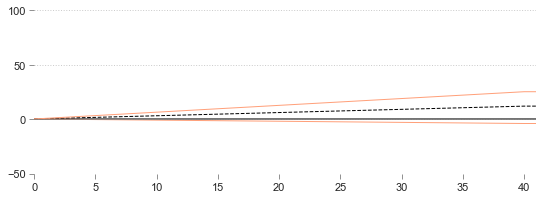

,"impact at year = 41, kg CO2-Eq"
a_a_2126_dg_init,0.171
a_b_2126_dg0,11.971
a_c_2126_sg1,25.224
a_d_2126_sg2,-4.012


In [296]:
# Define the simulation step, plot as curves:
step = "step_1"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_igu = ['dg_init', 'sg', "dg0"]
conv_factor = 0.001

# plot:
plot_lca_40(step, impact_cat, ls_igu,
            -50, 100, 50, conv_factor
            )

step_1
climate change ,  climate change total
Unit is: kg CO2-Eq . With conversion factor: 0.001


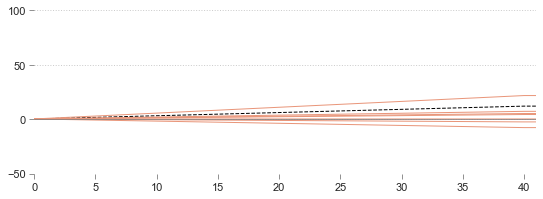

,"impact at year = 41, kg CO2-Eq"
a_a_2126_dg_init,0.171
a_b_2126_dg0,11.971
a_e_2126_dg1,21.697
a_f_2126_dg2,5.177
a_g_2126_dg3,7.177
a_h_2126_dg4,-7.779
a_i_2126_dg5,-2.541
a_j_2126_dg6,4.257


In [297]:
ls_igu = ['dg', "dg0"]

# plot:
plot_lca_40(step, impact_cat, ls_igu,
            -50, 100, 50, conv_factor
            )

step_1
climate change ,  climate change total
Unit is: kg CO2-Eq . With conversion factor: 0.001


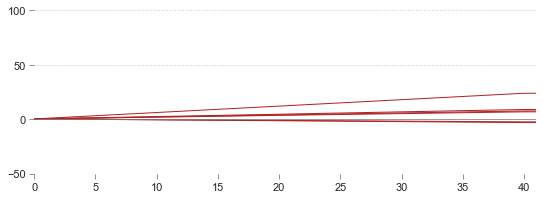

,"impact at year = 41, kg CO2-Eq"
a_k_2126_tg1,23.803
a_l_2126_tg2,8.883
a_m_2126_tg3,6.723
a_n_2126_tg4,-3.115
a_o_2126_tg5,-2.515
a_p_2126_tg6,7.523


In [298]:
ls_igu = ['tg']

# plot:
plot_lca_40(step, impact_cat, ls_igu,
            -50, 100, 50, conv_factor
            )

Another kind of plot:

step_1
climate change , climate change total
Unit is: kg CO2-Eq . With conversion factor: 0.001


,"impact at year = 41, points"
a_a_2126_dg_init,0.171
a_b_2126_dg0,11.971
a_c_2126_sg1,25.224
a_d_2126_sg2,-4.012
a_e_2126_dg1,21.697
a_f_2126_dg2,5.177
a_g_2126_dg3,7.177
a_h_2126_dg4,-7.779
a_i_2126_dg5,-2.541
a_j_2126_dg6,4.257


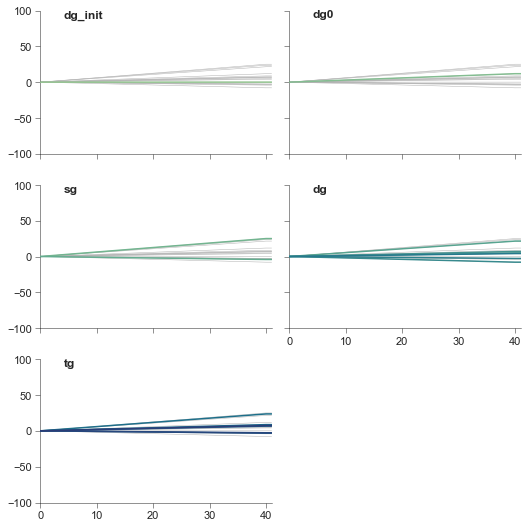

In [322]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_1"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Step 2: Different Glazing Types, with Interior Shading Devices, Fan Coil Chiller w/ Boiler

step_2
climate change , climate change total
Unit is: kg CO2-Eq . With conversion factor: 0.001


,"impact at year = 41, points"
b_a_2126_dg_init_int,-0.341
b_b_2126_dg0_int,8.642
b_c_2126_sg1_int,22.535
b_d_2126_sg2_int,-4.186
b_e_2126_dg1_int,17.288
b_f_2126_dg2_int,3.808
b_g_2126_dg3_int,5.888
b_h_2126_dg4_int,-7.231
b_i_2126_dg5_int,-2.755
b_j_2126_dg6_int,3.249


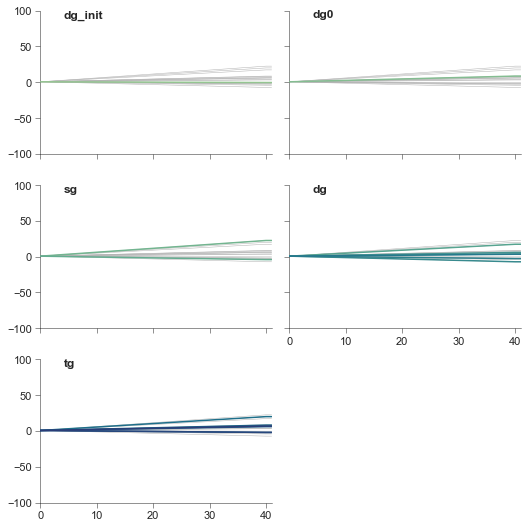

In [323]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_2"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Step 3: Different Glazing Types, w/ Exterior Shading Devices, Fan Coil Chiller w/ Boiler

step_3
climate change , climate change total
Unit is: kg CO2-Eq . With conversion factor: 0.001


,"impact at year = 41, points"
c_a_2126_dg_init_ext,-15.355
c_b_2126_dg0_ext,-17.275
c_c_2126_sg1_ext,-2.468
c_d_2126_sg2_ext,-18.022
c_e_2126_dg1_ext,-9.990
c_f_2126_dg2_ext,-14.709
c_g_2126_dg3_ext,-12.549
c_h_2126_dg4_ext,-14.989
c_i_2126_dg5_ext,-15.789
c_j_2126_dg6_ext,-14.228


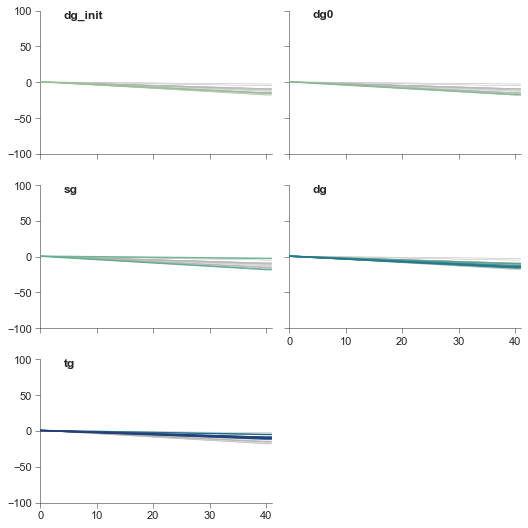

In [324]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_3"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Comparative Analysis Steps 1-3

In [335]:
df_ilcd_methods

Subcategory        Unit
Category          #                                                       
climate change    1                       climate change total   kg CO2-Eq
ecosystem quality 2                     freshwater ecotoxicity         CTU
                  3   freshwater and terrestrial acidification   mol H+-Eq
                  4                  freshwater eutrophication     kg P-Eq
                  5                      marine eutrophication     kg N-Eq
                  6                 terrestrial eutrophication    mol N-Eq
human health      7                   non-carcinogenic effects        CTUh
                  8                       carcinogenic effects        CTUh
                  9                         ionising radiation  kg U235-Eq
                  10                     ozone layer depletion  kg CFC-11.
                  11              photochemical ozone creation  kg NMVOC-.
                  12           respiratory effects, inorganics  disease i.
resources         13                       minerals and metals    kg Sb-Eq
                  14                          dissipated water  m3 water-.
                  15                                   fossils   megajoule
                  16                                  land use      points

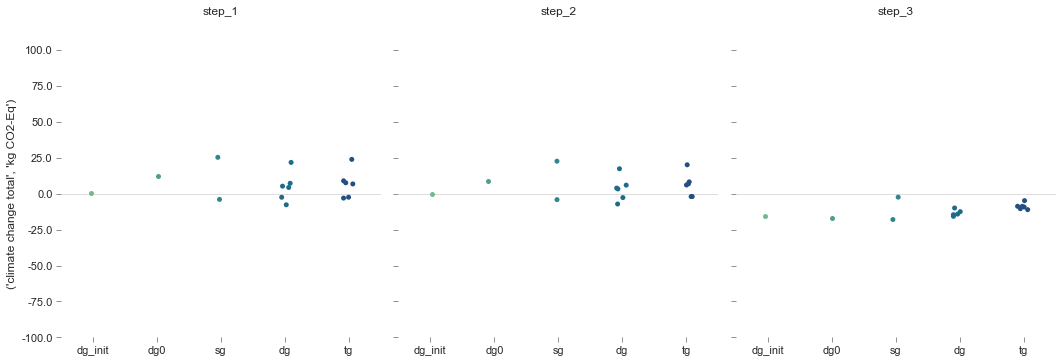

In [353]:
# Define the impact category:
n = 1

ic = df_ilcd_methods.xs(n, level=1)["Subcategory"][0]
i = df_ilcd_methods.index[df_ilcd_methods['Subcategory'] == ic][0][0]
ic_unit = df_ilcd_methods.xs(n, level=1)["Unit"][0]


# Keep the lca impact results at the end of life:
df_plot = df_lca_lifespan[['step_1', 'step_2', 'step_3']].xs(
    ic, axis=1, level=4, drop_level=False).loc[[41]]

# Transpose:
df_plot = df_plot.T.unstack(level=(4, 5))[41].reset_index()

# Category plot:
g = sns.catplot(data=df_plot, x="IGU",
                y=(ic, ic_unit),
                hue="IGU", col="Step",
                # kind="point", capsize=.1,
                palette="crest", height=5, aspect=1
                )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(thousand_divide))
    style_ax(ax)
    ax.axhline(y=0, c='lightgrey', linestyle='-', linewidth=0.75)

(g.set_titles("{col_name}", fontsize=17, y=1.1)
 .set(ylim=(-100000, 100000))
 .despine(left=True, bottom=True, offset=5)
 )

plt.show()

In [389]:
df_weighted = pd.DataFrame()

for step, run, igu, i, ic, unit in df_lca_lifespan.columns:
    ref = (step, run, igu)
    if ref not in df_weighted.columns:
        df_to_weight = df_lca_lifespan.xs(
            run, axis=1, level=1, drop_level=False).loc[[41]]

        df_to_weight.columns = df_to_weight.columns.droplevel([0, 1, 2])

        # Defining a new DataFrame with the weighted values,
        # i.e., multiplication of the impacts by df_weighting:
        df_weighted = df_weighted.append(pd.DataFrame(
            (df_to_weight.multiply(
                df_weighting["Weighting factor"].T, axis=1) / 100
             ).sum(axis=1), columns=[ref]
        ))

In [397]:
df_weighted.groupby(level = 0).max().sort_index(axis=1, level=0)

step_1                                                  \
     a_a_2126_dg_init    a_b_2126_dg0    a_c_2126_sg1    a_d_2126_sg2   
              dg_init             dg0              sg              sg   
      Weighted impact Weighted impact Weighted impact Weighted impact   
Year                                                                    
41           411.7051      61513.7811      65327.6452     -31267.9175   

                                                                      \
        a_e_2126_dg1    a_f_2126_dg2    a_g_2126_dg3    a_h_2126_dg4   
                  dg              dg              dg              dg   
     Weighted impact Weighted impact Weighted impact Weighted impact   
Year                                                                   
41       123368.9566      42335.5806      52664.9286     -20871.9799   

                                      ...                   step_9  \
        a_i_2126_dg5    a_j_2126_dg6  ... i_a_2126_dg_init_vav_int   
                  dg              dg  ...                  dg_init   
     Weighted impact Weighted impact  ...          Weighted impact   
Year                                  ...                            
41         4708.3578       38342.119  ...                -600.3781   

                                                                      \
       i_b_2126_dg5k   i_c_2126_tg5k   i_d_2126_tg5x    i_e_2126_ccf   
                  dg              tg              tg             ccf   
     Weighted impact Weighted impact Weighted impact Weighted impact   
Year                                                                   
41       -55820.4748     -80382.5593       -77684.79     -94907.0731   

                                                                              \
     i_f_2126_dg_vacuum i_g_2126_dg_smart i_h_2126_dsf_min i_i_2126_dsf_mean   
              dg_vacuum          dg_smart              dsf               dsf   
        Weighted impact   Weighted impact  Weighted impact   Weighted impact   
Year                                                                           
41          -51218.4024      -118623.2346      -76097.9404       -67410.4271   

                       
     i_j_2126_dsf_max  
                  dsf  
      Weighted impact  
Year                   
41        -59686.3046  

[1 rows x 186 columns]

In [387]:
df_weighted.columns = pd.MultiIndex.from_tuples(
        df_weighted.columns, names=['Step', 
                                     'Scenario', 
                                     'IGU', 
                                     'Weighted impact'
                                    ]
    )

In [388]:
df_weighted

Step                      step_1                                  \
Scenario        a_a_2126_dg_init    a_b_2126_dg0    a_c_2126_sg1   
IGU                      dg_init             dg0              sg   
Weighted impact  Weighted impact Weighted impact Weighted impact   
Year                                                               
41                      411.7051             NaN             NaN   
41                      411.7051             NaN             NaN   
41                      411.7051             NaN             NaN   
41                      411.7051             NaN             NaN   
41                      411.7051             NaN             NaN   
...                          ...             ...             ...   
41                           NaN             NaN             NaN   
41                           NaN             NaN             NaN   
41                           NaN             NaN             NaN   
41                           NaN             NaN             NaN   
41                           NaN             NaN             NaN   

Step                                                             \
Scenario           a_d_2126_sg2    a_e_2126_dg1    a_f_2126_dg2   
IGU                          sg              dg              dg   
Weighted impact Weighted impact Weighted impact Weighted impact   
Year                                                              
41                          NaN             NaN             NaN   
41                          NaN             NaN             NaN   
41                          NaN             NaN             NaN   
41                          NaN             NaN             NaN   
41                          NaN             NaN             NaN   
...                         ...             ...             ...   
41                          NaN             NaN             NaN   
41                          NaN             NaN             NaN   
41                          NaN             NaN             NaN   
41                          NaN             NaN             NaN   
41                          NaN             NaN             NaN   

Step                                                             \
Scenario           a_g_2126_dg3    a_h_2126_dg4    a_i_2126_dg5   
IGU                          dg              dg              dg   
Weighted impact Weighted impact Weighted impact Weighted impact   
Year                                                              
41                          NaN             NaN             NaN   
41                          NaN             NaN             NaN   
41                          NaN             NaN             NaN   
41                          NaN             NaN             NaN   
41                          NaN             NaN             NaN   
...                         ...             ...             ...   
41                          NaN             NaN             NaN   
41                          NaN             NaN             NaN   
41                          NaN             NaN             NaN   
41                          NaN             NaN             NaN   
41                          NaN             NaN             NaN   

Step                             ...                   step_9                  \
Scenario           a_j_2126_dg6  ... i_a_2126_dg_init_vav_int   i_b_2126_dg5k   
IGU                          dg  ...                  dg_init              dg   
Weighted impact Weighted impact  ...          Weighted impact Weighted impact   
Year                             ...                                            
41                          NaN  ...                      NaN             NaN   
41                          NaN  ...                      NaN             NaN   
41                          NaN  ...                      NaN             NaN   
41                          NaN  ...                      NaN             NaN   
41                          NaN  ...

In [375]:
df_weighted_test

,"(a_a_2126_dg_init, Weighted impact)"
Year,
41,411.7051


## Steps 4-7: HVAC System Optimisation, VAV and VRF

### Step 4: Efficient VAV HVAC System, w/o Shading Devices

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_4"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Step 5: Efficient VAV HVAC System, with interior shading devices

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_5"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Step 6: Efficient VRF HVAC System, w/o Shading Devices

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_6"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Step 7: Efficient VRF HVAC System, with interior shading devices

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_7"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Comparative Analysis According to HVAC System

In [ ]:
# Define the impact category:
n = 1

ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
ic

for i, j in [('step_1', 'step_2'),
             ('step_4', 'step_5'),
             ('step_6', 'step_7')]:

    # Keep the lca impact results at the end of life:
    df_plot = df_lca_lifespan[[i, j]].xs(
        ic, axis=1, level=3, drop_level=False).loc[[41]]

    # Transpose:
    df_plot = df_plot.T.unstack(level=(3, 4))[41].reset_index()

    # Category plot:
    g = sns.catplot(data=df_plot, x="IGU",
                    y=("Climate Change Total", "kg CO2-Eq"),
                    hue="IGU", col="Step",
                    # kind="point", capsize=.1,
                    palette="crest", height=5, aspect=1
                    )

    # palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(FuncFormatter(thousand_divide))
        style_ax(ax)
        ax.axhline(y=0, c='lightgrey', linestyle='-', linewidth=0.75)

    (g.set_titles("{col_name}", fontsize=17, y=1.1)
     .set(ylim=(-100000, 100000))
     .despine(left=True, bottom=True, offset=5)
     )

    plt.show()

## Steps 8: Reduction of the Window-to-Wall Ratio

### 75% of the Initial WtW Ratio

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_8"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Comparative Analysis According to WtW Ratio

Compare step 4 and 8. Difference comes from the window-to-wall ratio, 100% and 75% respectively.

In [ ]:
# Define the impact category:
n = 1

ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
ic

# Keep the lca impact results at the end of life:
df_plot = df_lca_lifespan[['step_4', 'step_8']].xs(
    ic, axis=1, level=3, drop_level=False).loc[[41]]

# Transpose:
df_plot = df_plot.T.unstack(level=(3, 4))[41].reset_index()

# Category plot:
g = sns.catplot(data=df_plot, x="IGU",
                y=("Climate Change Total", "kg CO2-Eq"),
                hue="IGU", col="Step",
                # kind="point", capsize=.1,
                palette="crest", height=5, aspect=1
                )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(thousand_divide))
    style_ax(ax)
    ax.axhline(y=0, c='lightgrey', linestyle='-', linewidth=0.75)

(g.set_titles("{col_name}", fontsize=17, y=1.1)
 .set(ylim=(-100000, 100000))
 .despine(left=True, bottom=True, offset=5)
 )

plt.show()

## Steps 9: High-Tech Glazing Units

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_9"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Comparative Analysis of High-Tech Glazing Units

In [ ]:
# Define the impact category:
n = 1

ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
ic

for step in ['step_4', 'step_9']:
    # Keep the lca impact results at the end of life:
    df_plot = df_lca_lifespan[[step]].xs(
        ic, axis=1, level=3, drop_level=False).loc[[41]]

    # Transpose:
    df_plot = df_plot.T.unstack(level=(3, 4))[41].reset_index()

    if step == 'step_4':
        p = "crest"
    else:
        p = "dark:salmon_r"

    # Category plot:
    g = sns.catplot(data=df_plot, x="IGU",
                    y=("Climate Change Total", "kg CO2-Eq"),
                    hue="IGU", col="Step",
                    # kind="point", capsize=.1,
                    palette=p, height=5, aspect=1
                    )

    # palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(FuncFormatter(thousand_divide))
        style_ax(ax)
        ax.axhline(y=0, c='lightgrey', linestyle='-', linewidth=0.75)

    (g.set_titles("{col_name}", fontsize=17, y=1.1)
     .set(ylim=(-100000, 100000))
     .despine(left=True, bottom=True, offset=5)
     )

    plt.show()

## Steps 10-11: Lifestyles

"Americanisation"

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_10"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

"Sufficiency"

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_11"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

## Steps 12-13: Internal Gains

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_12"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_13"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

# Energy Mix and Fully Electrified HVAC System: Sensitivity Analysis

In [ ]:
# List of activities to change, in this case electricity markets:
locations = ["FR", "DE", "PL", "NL", "CH"]

act_name = "market for electricity, low voltage"

elec_market = [('ecoinvent 3.7 cut-off', act['code'])
               for act in eicutdb.search(act_name, limit=200)
               for location in locations
               if act_name in act['name'] and location in act['location']
               and "US-FRCC" not in act['location']
               and "US-SERC" not in act['location']
               ]

# Remove "market for electricity, low voltage, label-certified" for CH:
elec_market.pop(5)

elec_market

In [ ]:
# Printing the exchanges
print('My activity is:\n', use_bldg_w_cw,
      '\n-------\nAnd its exchanges:\n-------')

for i in list(use_bldg_w_cw.exchanges()):
    print(i['type'])
    print(i)
    print(i['input'])
    print('-------')

In [ ]:
exc_elec = list(use_bldg_w_cw.exchanges())[0]
exc_elec

In [ ]:
# LCA according to energy mix:

# DF to save results:
df_results = pd.DataFrame()

n = 0

# to name the calculation steps according to location for elec mix:
ls_loc = []
for i in range(len(elec_market)):
    my_act_elec = Database('ecoinvent 3.7 cut-off').get(elec_market[i][1])
    ls_loc.append(my_act_elec['location'])

# Make a copy of the activity, substitute the background process
# save and calculate:
for m in elec_market:
    use_bldg_w_cw_copy = use_bldg_w_cw.copy()
    exc_elec['input'] = m
    exc_elec.save()
    step = "step_6_"+ls_loc[n]
    n += 1
    for act in [prod_cw, use_bldg_w_cw_copy, repair_cw, eol_cw]:
        ls = lca_cw_mlca_full(df_step6, act, 1)
        df_energymix_results = ls_to_df_mlca_full(
            step, ls, act, df_results
        )

In [ ]:
ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
df_energymix_results.loc[step].xs(ic, axis=1,
                                  level=1, drop_level=False
                                  )

In [ ]:
np.mean([(i/be_cw_elec_result) for i in cw_elec_results])

In [ ]:
pd.DataFrame(cw_elec_results).describe()

In [ ]:
plt.boxplot(cw_elec_results)
plt.ylabel(methods[('IPCC 2013', 'climate change', 'GWP 100a')]['unit'])
plt.xlabel('El Production')